# Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.sql.types import StructType,StructField,IntegerType,DoubleType,\
                              StringType
from pyspark.ml import Pipeline
from pyspark.sql.functions import expr
from pyspark.sql.functions import col, isnan
from pyspark.sql import Row, Column
from pyspark.sql.functions import lit
from pyspark.sql.functions import monotonically_increasing_id

import numpy as np

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans

from pyspark.ml.feature import RFormula


from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.window import Window
from pyspark.sql.functions import asc, desc, avg, percentile_approx, stddev, max, product, abs, sum, pow, min, sqrt
from functools import partial
from pyspark.sql.functions import udf

import scipy as scp

from pyspark.sql.functions import udf, struct, col
from pyspark.sql.types import *
import pyspark.sql.functions as func

import pyspark
from pathlib import Path

import random
import os

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Common utility functions

In [ ]:
# =============================================================================
# Describing
# =============================================================================

def class_distribution_inspection(dfs = None,
                                  df = None
                                 ):
    if dfs is not None:
        for idx, df_nts in enumerate(dfs_nts):
            print(f_print(f"Subject_id_{idx}"))
            df_nts.select("activity_id").toPandas()['activity_id'].plot.hist()
            plt.show()
    else:
        df.select("activity_id").toPandas()['activity_id'].plot.hist()
        plt.show()

def show(dfs, num_rows = 2):
    for df in dfs:
        df.show(num_rows)

def count(dfs):
    for idx, df in enumerate(dfs):
        print(f"number of rows of df_{idx} : {df.count()}")

def describe(df = None, dfs = None, single_features = False):
    if dfs:
        df = union(dfs)

    if df:
        if single_features:
            for feature_name in df.columns[1:]:
                print("feature: ", feature_name)
                feature_data = df.select(feature_name).toPandas()
                plt.boxplot(feature_data.values)
                plt.show()
                print("\n\n")
                print(feature_data.describe())

        else:
            print("Before normalisation")
            df_pd = df.toPandas()
            df_num = df_pd.iloc[:,1:]
            boxfig = plt.figure()
            plt.boxplot(df_num)
            plt.show()

            print("After normalisation")
            desc_stats = df_num.describe()
            print(desc_stats)
            df_norm = df_num

            print(desc_stats.columns)
            for c in desc_stats.columns:
                mean = desc_stats.loc['mean', c]
                sd = desc_stats.loc['std', c]
                df_norm.loc[:, c] = (df_pd.loc[:, c] - mean) / sd

            df_normarr = df_norm.values
            boxnfig = plt.figure()
            plt.boxplot(df_normarr)
            plt.show()

            corr = df_pd.corr()
            heatfig = plt.figure()
            plt.pcolor(corr)

def f_print(msg):
    msg_len = len(msg)
    to_be_printed = ["="*(msg_len + 6), " "*3 + msg + " "*3,"="*(msg_len + 6)]
    return "\n".join(to_be_printed)


# =============================================================================
# Pre-processing
# =============================================================================

def drop_nan(dfs):
    return [df.na.drop("any") for df in dfs]

def drop_time_stamp(dfs):
    return [df.drop("timestamp") for df in dfs]

def write(dfs,prefix):
    for idx, df in enumerate(dfs):
        filepath = Path(prefix + str(idx) + ".csv")
        df.toPandas().to_csv(filepath)

def write_read(dfs, prefix,
               formato = 'csv'):
    write(dfs, prefix)
    dfs = [spark.read.format(formato).option("header", "True").option("inferSchema", "True").option("delimiter",",").load(prefix + str(i) + "." + formato) for i in range(len(dfs))]
    dfs = [df.drop("_c0") for df in dfs]
    return dfs


In [ ]:
seed = 42

## Shared sub-workflows

### Getting train-test datasets

#### Train-test split

In [ ]:
def train_test_split(dfs = None,
                     df = None,
                     seed=seed,
                     train_split = 0.7):
    if dfs and df:
        print("Error")
    elif df:
        # dataframe train-test splitting
        df_train, df_test = df.randomSplit([train_split, 1 - train_split], seed)
        return df_train, df_test
    elif dfs:
        # dataframes train-test splitting
        dfs_train, dfs_test = [], []
        for df in dfs:
            df_train, df_test = df.randomSplit([train_split, 1 - train_split], seed)
            dfs_train += [df_train]
            dfs_test += [df_test]
        return dfs_train, dfs_test

#### Fit-transform

In [ ]:
def fit_transform(df):
    # rFormula definition
    rf = RFormula(formula="class ~ .")
    # fitting the dataframe to the rFormula
    rf_fit = rf.fit(df)
    # application of the rFormula
    rf_transfd = rf_fit.transform(df)
    return rf_transfd

#### Normalise

In [ ]:
def normalise(df):
    # definition of normaliser
    normaliser = StandardScaler(inputCol="features", outputCol="normFeatures")
    # fitting the dataframe to the normaliser
    normModel = normaliser.fit(df)
    # application of the normalisation
    df_norm = normModel.transform(df)
    # removing the previous column of non-normalised features and replacing it
    # with the new one with normalised features
    df_norm = df_norm.drop("features")
    df_norm = df_norm.withColumnRenamed("normFeatures","features")
    return df_norm

#### Assembly

In [ ]:
def assembly(df, inputs):
    # definition of the vectorAssembler
    vec_assembler = VectorAssembler(inputCols=inputs,outputCol="features")
    # application of the assembler: transform
    df_transfd = vec_assembler.transform(df)
    # selection of the assembled features and label
    df_transfd = df_transfd.select(['features', 'label'])
    return df_transfd

#### Assembly-normalise

In [ ]:
def assembly_normalise(df, inputs):
    # definition of the vectorAssembler
    vec_assembler = VectorAssembler(inputCols=inputs,outputCol="nn_features")
    # definition of the normaliser
    normaliser = StandardScaler(inputCol="nn_features", outputCol="features")
    # definition of two stages
    stages = [vec_assembler, normaliser]
    # definition of the pipeline with two stages: assembler of features and normalisation
    # of the assmbled features
    pipeline = Pipeline(stages = stages)
    # application of the pipeline: fitting and transform
    pipeline_mod = pipeline.fit(df)
    df_transfd = pipeline_mod.transform(df)
    # selection of the assembled features and label
    df_transfd = df_transfd.select(['features', 'label'])
    return df_transfd

#### Get train-test

In [ ]:
def get_train_test(df_tbp, normalisation):
    # train, test init
    train, test = None, None
    # string label indexer
    stringIndexer = StringIndexer(inputCol="activity_id", outputCol="activity_idx")
    # fitting string-indexer to dataframe
    si_df = stringIndexer.fit(df_tbp)
    # to be processed dataframe
    df_tbp = si_df.transform(df_tbp)
    if normalisation:
        # the normalisation is applied separately for the train and test sets, because it is necessary
        # separate them, due to the fact that the test set is made up of unseen data and it should
        # not be taken into account at training time
        if random.choice([0,1]) == 0:
            # =============================================================================
            # Assembly-normalise
            # =============================================================================
            print("Assembly-normalise")
            # renaming the column as "label" because it is needed by the classifiers
            print("Column renaming: activity_id --> label")
            df_tbp = df_tbp.withColumnRenamed("activity_idx","label")
            # train-test splitting
            print("Train-test splitting")
            train, test = train_test_split(df=df_tbp)
            # input columns needed to be assembled and normalised
            inputs = df_tbp.columns
            # assembly-normalise train
            print("Assembly-normalise train")
            train = assembly_normalise(train, inputs)
            # assembly-normalise test
            print("Assembly-normalise test")
            test = assembly_normalise(test, inputs)
        else:
            # =============================================================================
            # Fit-transform normalise
            # =============================================================================
            print("Fit-transform normalise")
            # renaming the column as "label" because it is needed by the classifiers
            print("Column renaming: activity_id --> label")
            df_tbp = df_tbp.withColumnRenamed("activity_idx","label")
            # fit-transform of the entire dataset
            print("Fit-transform")
            rf_transfd = fit_transform(df_tbp)
            print("Train-test split")
            # tran-test splitting
            train, test = train_test_split(df=rf_transfd)
            # train normalisation
            print("Normalise train")
            train = normalise(train)
            # test normalisation
            print("Normalise test")
            test = normalise(test)
    else:
        if random.choice([0,1]) == 0:
            # =============================================================================
            # Assembly
            # =============================================================================
            print("Assembly")
            # renaming the column as "label" because it is needed by the classifiers
            print("Column renaming: activity_id --> label")
            df_tbp = df_tbp.withColumnRenamed("activity_idx","label")
            # train-test splitting
            print("Train-test splitting")
            train, test = train_test_split(df=df_tbp)
            # input columns needed to be assembled and normalised
            inputs = df_tbp.columns
            # assembly-normalise train
            print("Assembly-normalise train")
            train = assembly(train, inputs)
            # assembly-normalise test
            print("Assembly-normalise test")
            test = assembly(test, inputs)
        else:
            # =============================================================================
            # Fit-transform
            # =============================================================================
            print("Fit-transform")
            # renaming the column as "class" because it is needed by the rFormula
            df_tbp = df_tbp.withColumnRenamed('activity_idx','class')
            # fit transform of the entire dataset
            rf_transfd = fit_transform(df_tbp)
            # train-test splitting
            print("Train-test split")
            train, test = train_test_split(df=rf_transfd)

    print("Train schema: ")
    train.printSchema()
    print("Test schema: ")
    test.printSchema()
    return train,test

### Get filtered columns
This function is used to filter the columns keeping the ones to be included and removing the ones to be excluded

In [ ]:
def get_filtered_columns(columns, toBeExcluded = None, toBeIncluded = None):
    # checking whether there is no overlap between the filtering by removal
    # or keeping
    if toBeExcluded is not None and toBeIncluded is not None:
        print("Error: the two lists are mutually exclusive")

    filtered_columns = []

    # support function to check whether the column is in the exclusion
    # list, so it has to be excluded
    def is_excluded(column, toBeExcluded):
        for filt in toBeExcluded:
            if column.find(filt) >= 0:
                return True
        return False

    # support function to check whether the column is in the keeping
    # list, so it has to be included in the final filtered list of
    # columns
    def is_included(column, toBeIncluded):
        for filt in toBeIncluded:
            if column.find(filt) >= 0:
                return True
        return False

    # checking whether to apply a filtering by exclusion or inclusion
    if toBeExcluded is not None:
        for column in columns:
            # if the column is not excluded then it is added to the
            # final filtered list
            if not is_excluded(column, toBeExcluded):
                filtered_columns += [column]
    elif toBeIncluded is not None:
         for column in columns:
            # if the column is included then it is added to the the
            # final filtered list
            if is_included(column, toBeIncluded):
                filtered_columns += [column]

    return filtered_columns

### Union of dataframes
This function is applied in order to unify the dataframes of the measuraments of different subjects

In [ ]:
def union(dfs):
    result = dfs[0]
    for df in dfs[1:]:
        result = result.union(df)
    return result

### Get aggregations
This function is used to compute the aggregations of the measuraments recorded according to the three different axis

In [ ]:
def get_aggregations(dfs,
                     toBeIncluded = None,
                     toBeExcluded = None,
                     include_singleAxis_columns = True):
    # =============================================================================
    # Column filtering
    # =============================================================================
    # columns extraction
    columns = dfs[0].columns
    # filtering columns according to the ones to be included or to be excluded
    filtered_columns = get_filtered_columns(columns,
                                            toBeIncluded = toBeIncluded,
                                            toBeExcluded = toBeExcluded)

    # =============================================================================
    # Axis separation
    # =============================================================================
    # definition of the lists of columns for each axis
    x = []
    y = []
    z = []
    for column in filtered_columns:
        if column.find("_x_") >= 0:
            x += [column]
        elif column.find("_y_") >= 0:
            y += [column]
        elif column.find("_z_") >= 0:
            z += [column]

    # =============================================================================
    # Axis aggregation (same body part)
    # =============================================================================
    # definition of the names for the aggregation
    axisAggregation_sameBodyPart_names = [columnX.replace("_x_","_xyz_") for columnX in x]
    # definition of the operations necessary to create the new axis aggregation columns
    axisAggregation_sameBodyPart = [sqrt(col(x)**2 + col(y)**2 + col(z)**2).alias(aggregation_name)
                                    for x,y,z,aggregation_name in zip(x, y, z,axisAggregation_sameBodyPart_names)]
    # adding the new axis aggregation columns to the final filtered list of columns
    to_be_selected = axisAggregation_sameBodyPart
    if include_singleAxis_columns:
        to_be_selected += filtered_columns

    return [df.select(to_be_selected)
            for df in dfs]

### Concatenate and merge

In [ ]:
# it concatenates dataframes with the same schema and merges dataframes with
# different columns
def concatenate_merge(dfs_raw, dfs_additional_list,
                      label = 'activity_id',
                      toBeExcluded = None,
                      toBeIncluded = None):
    # list of columns of raw time series dataframes
    raw_columns = dfs_raw[0].columns
    # the list of columns has to be filtered
    filtered_raw_columns = get_filtered_columns(raw_columns,
                                                toBeExcluded = toBeExcluded,
                                                toBeIncluded = toBeIncluded)
    # additional features [neither time nor frequency features]
    additional_columns = []
    for dfs_additional in dfs_additional_list:
        additional_columns += dfs_additional[0].columns

    # final list of columns
    final_columns = [label] + filtered_raw_columns + additional_columns

    # union of dataframes with raw data
    df_raw_final = union(dfs_raw)
    df_raw_final = df_raw_final.select(
                [col(column) for column in filtered_raw_columns] + [col(label).cast('double')])\
                               .withColumn("r_idx_raw",monotonically_increasing_id())

    # union of dataframes with additional data
    df_additional_final = union(dfs_additional_list[0])
    df_additional_final = df_additional_final.withColumn("r_idx_final_0", monotonically_increasing_id())

    # merge of dataframes with different schemas
    for i in range(len(dfs_additional_list[1:])):
        df_additional = union(dfs_additional_list[i + 1])
        df_additional = df_additional.withColumn(f"r_idx_final_{i + 1}", monotonically_increasing_id())
        df_additional_final = df_additional_final.join(df_additional, df_additional[f"r_idx_final_{i + 1}"] == df_additional_final['r_idx_final_0'])

    df_final = df_raw_final.join(df_additional_final, df_raw_final.r_idx_raw == df_additional_final.r_idx_final_0)

    to_be_selected = []
    for column in final_columns:
        to_be_selected += [col(column)]

    df_final = df_final.select(to_be_selected)

    return df_final

# Workflows

## Rows with NaNs dropping
This method simply
* unifies the dataframes of the different subjects
* gets rid of the rows containing at least one NaN value
* creates the train-test datasets

In [ ]:
def rows_with_NaNs_dropping(dfs_nts, normalisation
                           ):
    # =============================================================================
    # DataFrames union
    # =============================================================================
    print(f_print("DataFrames union"))
    # the different subjects dataframes are unified before dropping the rows with at
    # least one NaN value
    df_u = union(dfs_nts)

    # =============================================================================
    # Rows reduction checking
    # =============================================================================
    class_distribution_inspection(dfs = dfs_nts)
    print(f_print("Rows reduction checking"))
    print("Before dropping rows with NaNs: ")
    print("number of rows: ", df_u.count())
    df_tbp = df_u.na.drop("any")
    print("After dropping rows with NaNs: ")
    print("number of rows: ", df_tbp.count())
    class_distribution_inspection(df = df_tbp)

    # =============================================================================
    # Data description
    # =============================================================================
    print(f_print("Data description"))
    print(df_tbp.columns)
    describe(df = df_tbp, single_features = True)

    # =============================================================================
    # Getting train-test datasets
    # =============================================================================
    print(f_print("Getting train-test datasets"))
    train,test = get_train_test(df_tbp, normalisation)

    return train,test

## Axis feature aggregation and feature selection
This method is used for the selection of the columns that have a variance greater than a certain threshold. If the variance of a column is very low then it will not have a significant role for the discrimination. In this case, the higher the variance, the better the opporunity to discriminate between different classes.
It applies:

* union of dataframes
* rows with NaNs removal
* axis aggregation of the same body part
* feature selection: features with a variance greater than threshold are selected
* creation of train-test datasets

In [ ]:
def axisAggregation_featureSelection(dfs, normalise,
                                     threshold = 0.5):
    print(f_print("Feature aggregation and selection"))
    # =============================================================================
    # Dropping NaNs
    # =============================================================================
    print("Dropping NaNs")
    dfs_naDropped = drop_nan(dfs)

    # =============================================================================
    # Union of dataframes
    # =============================================================================
    print("Union of DataFrames")
    df = union(dfs_naDropped)

    # =============================================================================
    # Axis aggregation of dataframes
    # =============================================================================
    print("Axis aggregation of DataFrames")
    dfs_axisAggregation = get_aggregations(dfs_naDropped,
                                           toBeExcluded = [],
                                           include_singleAxis_columns = False)

    # =============================================================================
    # Concatenation and merge of DataFrames
    # =============================================================================
    print("Concatenation and merge of DataFrames")
    df_final = concatenate_merge(dfs_naDropped, [dfs_axisAggregation],
                                 label = 'activity_id',
                                 toBeExcluded = None,
                                 toBeIncluded = ["heart_rate", 'chest_temperature (°C)', 'ankle_temperature (°C)'])
    describe(df = df_final, single_features = True)

    # =============================================================================
    # Feature selection
    # =============================================================================
    print("Feature selection: features with a variance greater than threshold")
    over_threshold = [col('activity_id')]
    for column in df_final.columns:
        if column != 'activity_id':
            feature_description = df_final.select(col(column)).toPandas().describe()
            # only the features with a variance greater than a certain threshold
            # are selected
            if feature_description.loc[feature_description.index == 'std'].values[0][0] > threshold:
                over_threshold += [col(column)]
    # selection of the filtered columns
    df_final = df_final.select(over_threshold)
    # this is applied for sake of computational efficiency
    df_final.toPandas().to_csv(Path("temp.csv"))
    df_final = spark.read.format("csv").option("inferSchema", "True").option("header", "True").option("delimiter",",").load("temp.csv")
    df_final = df_final.drop("_c0")

    # =============================================================================
    # Train-test creation
    # =============================================================================
    print("Train-test creation")
    train,test = get_train_test(df_final, normalise)
    return train,test

## Axis feature aggregation, feature selection and body parts aggregation
This method not only aggregates the measuraments of different axis of the same body part but it also aggregates some processed features of different body parts
This process applies:
* dropping rows with NaN values
* union of DataFrames
* axis aggregation of the same body part
* time-features computation
* body parts weighted accumulation
* feature selection: features with a variance greater than threshold are selected

### Get weighted accumulation
Features like mean, standard deviation, absolute integral and energy calculated on 3
axes of each of the IMUs are pairwise (e.g. hand + chest sensor placement) weighted accumulated, and a weighted sum
for all the 3 sensors together is also added

In [ ]:
def get_weightedAccumulation(dfs,
                             measurings = ['avg','std','absolute','energy'],
                             all_axis = ['xyz'],
                             bodyParts = ['hand','chest','ankle'],
                             accumulation_weights_2 = None,
                             accumulation_weights_3 = None
                            ):
    # support function for the extraction of the type of measuring the column
    # in question is related to
    def get_measuring(column):
        result = None
        for measuring in measurings:
            if column.find(measuring) >= 0:
                result = measuring
                break
        return result

    # support function for the extraction of the body part the column in question is
    # related to
    def get_bodyPart(column):
        result = None
        for bodyPart in bodyParts:
            if column.find(bodyPart) >= 0:
                result = bodyPart
                break
        return result

    # =============================================================================
    # Column filtering
    # =============================================================================
    # columns extraction
    columns = dfs[0].columns
    # the first filtering phase is about the selection of the columns related to the
    # measurings in question
    filtered_columns = get_filtered_columns(columns, toBeIncluded = measurings)
    # the second filtering phase is about the selection of the all axis aggregation
    # columns
    filtered_columns = get_filtered_columns(filtered_columns, toBeIncluded = all_axis)

    # =============================================================================
    # Measuring separation
    # =============================================================================
    # for each measuring is created a dictionary storing the columns related to
    # each body part
    measuring_bodyParts = {measuring : {bodyPart : None for bodyPart in bodyParts}   for measuring in measurings}
    for column in filtered_columns:
        measuring = get_measuring(column)
        bodyPart = get_bodyPart(column)
        measuring_bodyParts[measuring][bodyPart] = column

    # definition of the accumulation weights for just two body parts at time, if
    # none is provided
    if accumulation_weights_2 == None:
        accumulation_weights_2 = np.ones((len(bodyParts), len(bodyParts),2))
    # definition of the accumulation weights for all the body parts together, if
    # none is provided
    if accumulation_weights_3 == None:
        accumulation_weights_3 = np.ones((len(bodyParts)))

    # =============================================================================
    # Body parts aggregation
    # =============================================================================
    bodyParts_accumulations = []
    for measuring in measurings:
        # for each measuring and for each couple of bodyParts, their accumulation is
        # computed
        for i,bodyPartA in enumerate(bodyParts):
            for j,bodyPartB in enumerate(bodyParts):
                if i < j:
                    colA = measuring_bodyParts[measuring][bodyPartA]
                    colB = measuring_bodyParts[measuring][bodyPartB]
                    bodyParts_accumulations += [abs(col(colA)*accumulation_weights_2[i,j,0] +
                                               col(colB)*accumulation_weights_2[i,j,1]).alias(f"{colA}_{colB}")]

        # for each measuring the aggregation of the three different body parts is
        # computed
        colA = measuring_bodyParts[measuring][bodyParts[0]]
        colB = measuring_bodyParts[measuring][bodyParts[1]]
        colC = measuring_bodyParts[measuring][bodyParts[2]]
        bodyParts_accumulations += [abs(col(colA)*accumulation_weights_3[0] +
                                       col(colB)*accumulation_weights_3[1] +
                                       col(colC)*accumulation_weights_3[2]).alias(f"{colA}_{colB}_{colC}")]


    return [df.select(bodyParts_accumulations)
            for df in dfs]

### Axis aggregation-body parts accumulation-feature selection


In [ ]:
def axisAggregation_bodyPartsAccumulation_featureSelection(dfs, normalise, threshold = 0.5):
    print(f_print("Feature aggregation and selection"))
    # =============================================================================
    # Dropping NaNs
    # =============================================================================
    print("Dropping NaNs")
    dfs_naDropped = drop_nan(dfs)

    # =============================================================================
    # Union of DataFrames
    # =============================================================================
    print("Union of DataFrames")
    df = union(dfs_naDropped)

    # =============================================================================
    # Axis aggregation of DataFrames
    # =============================================================================
    print("Axis aggregation of DataFrames")
    dfs_aggregations = get_aggregations(dfs_naDropped,
                                        toBeExcluded = [],
                                        include_singleAxis_columns = False)

    # =============================================================================
    # Time features computation
    # =============================================================================
    print("Time features computation")
    dfs_timeFeatures = apply_functions(dfs_aggregations,
                                       ['avg','median','stddev','peak_acceleration','absolute_integral','energy'],
                                       ['acceleration'],
                                       True)

    # =============================================================================
    # Body parts weighted accumulation
    # =============================================================================
    print("Body parts weighted accumulation")
    dfs_weightedAccumulation = get_weightedAccumulation(dfs_timeFeatures)

    # =============================================================================
    # Concatenation and merge of DataFrames
    # =============================================================================
    print("Concatenation and merge of DataFrames")
    df_final = concatenate_merge(dfs_naDropped, [dfs_aggregations, dfs_weightedAccumulation, dfs_timeFeatures],
                                 label = 'activity_id',
                                 toBeExcluded = None,
                                 toBeIncluded = ["heart_rate", 'chest_temperature (°C)', 'ankle_temperature (°C)'])

    # =============================================================================
    # Feature selection
    # =============================================================================
    print("Feature selection: features with a variance greater than threshold")
    over_threshold = [col('activity_id')]
    for column in df_final.columns:
        if column != 'activity_id':
            feature_description = df_final.select(col(column)).toPandas().describe()
            if feature_description.loc[feature_description.index == 'std'].values[0][0] > threshold:
                over_threshold += [col(column)]

    df_final = df_final.select(over_threshold)

    df_final.toPandas().to_csv(Path("temp.csv"))
    df_final = spark.read.format("csv").option("inferSchema", "True").option("header", "True").option("delimiter",",").load("temp.csv")
    df_final = df_final.drop("_c0")

    # =============================================================================
    # Train-test creation
    # =============================================================================
    print("Train-test creation")
    train,test = get_train_test(df_final, normalise)
    return train,test

## Dropping heart-rate column and then dropping rows with NaNs
This method removes the column with the greatest number of NaNs in order to avoid loosing too much data that could be useful for the classification.
It looks for a trade-off between the loss of an important column for the discriminative task and avoiding loosing too many rows that might provide important information for the task.

In [ ]:
def dropping_hr_nans(dfs_nts, normalise):
    print(f_print("Dropping heart-rate column and then dropping rows with NaNs"))
    # =============================================================================
    # Union of DataFrames
    # =============================================================================
    print("Union of DataFrames")
    df_u = union(dfs_nts)

    # =============================================================================
    # Dropping heart_rate column
    # =============================================================================
    print("Dropping heart_rate column")
    df_nhr = df_u.drop("heart_rate")
    print("Before dropping rows with NaNs: ")
    print("number of rows: ", df_nhr.count())
    df_tbp = df_nhr.na.drop("any")
    print("After dropping rows with NaNs: ")
    print("number of rows: ", df_tbp.count())

    # =============================================================================
    # Train-test computation
    # =============================================================================
    train, test = get_train_test(df_tbp, normalise)
    return train, test

## Time domain and frequency domain features extraction

### Window creation
Signal feautures were calculated over a window of 512 samples (about 5 s of data), in both time and frequency domain.

In [ ]:
def get_window(num_samples = 512):
    # left bound of the window
    left = -int(num_samples/2)
    # right bound of the window
    right = int(num_samples/2) - 1
    # window creation
    win = Window.rowsBetween(left, right)
    return win

### Spectral entropy
Spectral entropy encodes the spectral density (distribution of power in the frequency domain) into one value based on Shannon entropy.
The spectral entropy (SE) of a signal is a measure of its spectral power distribution. The concept is based on the Shannon entropy, or information entropy, in information theory. The SE treats the signal's normalized power distribution in the frequency domain as a probability distribution, and calculates the Shannon entropy of it. The Shannon entropy in this context is the spectral entropy of the signal. This property can be useful for feature extraction in fault detection and diagnosis

In [ ]:
def get_spectral_entropy(psd):
    spectral_entropy = 0
    for probability in psd:
        # when the probability is zero, the logarithm is equal to -infinity
        # this must be avoided
        if probability != 0:
            spectral_entropy -= probability * np.log2(probability)
    return spectral_entropy

### Power spectral density
The power spectral density (PSD) of the signal describes the power present in the signal as a function of frequency, per unit frequency

In [ ]:
def compute_psd(values):
    f, psd = scp.signal.welch(values,
                              window = 'boxcar',
                              nfft =2000,
                              fs=100,
                              scaling='density')
    return f,psd

### Heart rate features extraction
From the heart rate data, the features mean and normalized
mean (normalization is done on the interval defined by resting and maximum HR) are calculated. The resting HR of
a test subject is extracted from the 3 minutes lying task of
the data collection protocol, and is defined as the lowest HR
value measured over this period. As for the maximum HR, a
subject’s age-predicted maximum HR (M HR = 220 − age)
is used.

In [ ]:
def get_hrFeatures(dfs, subjects):
    dfs_hr = []
    # retrieving the age of each subject from the subjects dataframes containing personal data
    ages = np.array([age["Age(years)"] for age in subjects.select(col("Age(years)")).collect()])
    # retrieving the MHRs of each subject from the subjects dataframes containing personal data
    MHRs = np.array([age["MaxHR(bpm)"] for age in subjects.select(col("MaxHR(bpm)")).collect()])
    # retrieving the RHRs of each subject from the subjects dataframes containing personal data
    RHRs = np.array([age["RestingHR(bpm)"] for age in subjects.select(col("RestingHR(bpm)")).collect()])

    # window creation for the computation of mean and normalised mean
    win = get_window()

    for idx, df in enumerate(dfs):
        MHR = MHRs[idx]
        RHR = RHRs[idx]
        dfs_hr += [df.select([
            # computation of the normalised mean
            avg((col("heart_rate") - RHR)/(MHR-RHR)).over(win).alias("normalized avg hr"),
            # computation of the mean
            avg(col("heart_rate")).over(win).alias("avg hr")])]

    return dfs_hr

### Computation of time domain features
Time-domain features are:
* mean
* median
* standard deviation
* peak acceleration
* absolute integral

In [ ]:
def apply_function(fun_name, column, win = None):
    # definition of the functions to be applied
    funs = {'avg' : lambda column: avg(col(column)),
          'median' : lambda column: partial(percentile_approx, percentage = 0.5)(col(column)),
          'stddev' : lambda column: stddev(col(column)),
          'peak_acceleration' : lambda column: max(col(column)),
          'absolute_integral' : lambda column: sum(abs(col(column))),
          'energy' : lambda column: sum((abs(col(column))**2))
          }

    to_be_selected = None
    if win:
        # if the function has to be applied in a windowed way, so a window with a
        # certain number of samples is created and the function is computed over that window
        to_be_selected = funs[fun_name](column).over(win).alias(fun_name + " " + column)
    else:
        # if the function has to be applied to the entire column values
        to_be_selected = funs[fun_name](column).alias(fun_name + " " + column)

    return to_be_selected

In [ ]:
def apply_functions(dfs, funs_to_be_applied, filters, windowed):
    win = None
    # if the function has to be applied in windowed way, a window is created
    if windowed:
        win = get_window()

    to_be_selected = []
    for fun_name in funs_to_be_applied:
        for column in dfs[0].columns:
            for filt in filters:
                # the function can be applied to only a certain type of columns
                if column.find(filt) >=0:
                    to_be_selected += [apply_function(fun_name, column, win)]

    return [df.select(to_be_selected) for df in dfs]

### Computation of frequency domain features
Frequency-domain features are:
* peak frequency of the PSD
* power ratio of the frequency bands 0–2.75 Hz and
0–5 Hz
* energy of the frequency band 0–10 Hz
* spectral entropy of the normalized PSD on the frequency band 0–10 Hz.

Due to the fact that pyspark does not provide the implementation of the necessary functions, in order to overcome this limitation, the values from the dataframes are extracted and then processed. At the end a dataframe with the frequency features is created

In [ ]:
def get_frequencyFeatures(dfs, filters,
                          window_size = 512,
                          interval_acquisition = 0.01, # seconds
                          epsilon = 0.0001):
    left_window = int(window_size/2)
    right_window = int(window_size/2) - 1
    # column filtering: the frequency features can be extracted only from
    # a certain type of columns
    columns = dfs[0].columns
    filtered_columns = []
    for column in columns:
        for filt in filters:
            if column.find(filt) >= 0:
                filtered_columns += [column]

    # frequency features' names definition
    frequencyFeatures_names = ['peak_frequency',"power_ratio_[0–2,75]Hz",
                               "power_ratio_[0–5]Hz", "energy_frequency_band[0–10]Hz",
                               "entropy_normalized_PSD[0–10]Hz"]
    frequencyFeatures_schemaNames = []
    for column in filtered_columns:
        for feature_name in frequencyFeatures_names:
            frequencyFeatures_schemaNames += [feature_name + " " + column]

    # frequency features' schema definition
    num_features = len(frequencyFeatures_schemaNames)
    frequencyFeatures_types = [DoubleType()]*num_features
    frequencyFeatures_schema = StructType([StructField(f_name, f_type) for f_name, f_type
                                           in zip(frequencyFeatures_schemaNames, frequencyFeatures_types)])

    # computation of the frequency features for each of the dataframes
    dfs_frequencyFeatures = []
    for idx, df in enumerate(dfs):
        # creation of a 2d matrix for storing the values of the frequency features
        num_rows = df.count()
        df_pd = df.select(filtered_columns).toPandas()
        frequency_features = np.zeros(shape = (num_rows, num_features))

        for col in range(len(filtered_columns)):
            # manual implementation of the sliding window: it is necessary to pad the missing values of the
            # first and last window. The last window is created with the last value + a certain number
            # of zeros equal to the half of sliding window dimension
            values = np.concatenate((np.concatenate((np.zeros(left_window), df_pd[filtered_columns[col]].values)),
                                     np.zeros(right_window)))
            for starter in range(left_window, len(values) - right_window):
                # computation of the power spectral density
                f,psd = compute_psd(values[starter - left_window:starter + right_window])
                # peak frequency computation
                peak_frequency_idx = np.argmax(psd)
                peak_frequency = f[peak_frequency_idx]
                frequency_features[starter - left_window,col*len(frequencyFeatures_names)] = peak_frequency
                # the psd squared is necessary for the computation of the power
                psd_squared = psd**2
                # the power ratio has to be computed with two upper bound frequency limits
                for j,limit in enumerate([2.75, 5], start = 1):
                    mask = f <= limit
                    # the total power is computed with all the psd
                    total_power = np.sum(psd_squared)/(window_size*interval_acquisition)
                    # the band power is computed with just the values of the psd
                    # in a certain range of frequencies
                    band_power = np.sum(psd_squared[mask])/(window_size*interval_acquisition)
                    # the total power could be 0. In order to avoid dividing by 0, the power ratio
                    # is set to 1. If the total power is 0, for sure, since the fact that the power
                    # is computed with the psd values sqaured, then the band power will be 0 as well.
                    # Since the fact that band_power = total_power --> the ratio is approximated to 1
                    power_ratio = 1
                    if total_power != 0:
                        power_ratio = band_power / total_power
                    frequency_features[starter - left_window,j + col*len(frequencyFeatures_names)] = power_ratio
                # mask computation for the inclusion of the values of the psd just in the interval 0-10 Hz
                mask = f <= 10
                psd_band = psd[mask]
                psd_band_squared = psd_band**2
                psd_band_squared_sum = np.sum(psd_band_squared)
                energy_frequency_band = psd_band_squared_sum
                frequency_features[starter - left_window,col*len(frequencyFeatures_names) + 3] = energy_frequency_band
                # computation of the spectral entropy
                psd_normalized_band = psd_band_squared
                spectral_entropy = 0
                # in order to avoid dividing by zero
                if psd_band_squared_sum != 0:
                    psd_normalized_band = psd_band_squared / psd_band_squared_sum
                    spectral_entropy = get_spectral_entropy(psd_normalized_band)
                frequency_features[starter - left_window:col*len(frequencyFeatures_names) + 4] = spectral_entropy

        # frquency features dataframe creation
        dfs_frequencyFeatures += [spark.createDataFrame(frequency_features, schema = frequencyFeatures_schema)]
        #np.savetxt(f"{prefix}_{idx}.csv",frequency_features, delimiter = ',')
        #dfs_frequencyFeatures += [spark.read.format("csv").option("header", "False").option("inferSchema", "True").option("delimiter",",").schema(frequencyFeatures_schema).load(f"{prefix}_{idx}.csv")]

    return dfs_frequencyFeatures

### Removal of DC component
The DC component refers to the zero-frequency
component of the signal in the frequency domain. In other words, it is the average
value or the offset of the signal in the time domain. In signal processing, DC refers
to a signal component that does not vary with time or changes very slowly, such as a
constant or a slowly varying offset. In the context of the provided information, the
DC component refers to the zero-frequency component of the signal in the frequency
domain. Before calculating the power spectral density (PSD) in the frequency domain,
the DC component is removed from the signal. This is a common pre-processing step in
signal analysis to eliminate the effect of any offset or bias in the signal

In [ ]:
def remove_DC(dfs, windowed):
    # feature extraction
    columns = dfs[0].columns
    # definition of dfs with DC removed
    dfs_removed_DC = []
    # computation of processing functions on the acceleration column in a
    # windowed or not way
    dfs_averages = apply_functions(dfs, ['avg'], ['acceleration'], windowed)
    #dfs_averages = write_read(dfs_averages, "dfs_averages", "csv")
    if windowed:
        # removal for each window of 512 samples
        dfs = [df.withColumn("row_index_0", monotonically_increasing_id()) for df in dfs]
        dfs_averages = [df_averages.withColumn("row_index_1", monotonically_increasing_id())
                        for df_averages in dfs_averages]
        dfs_dfsAverages = [df.join(df_averages, col("row_index_0") == df_averages.row_index_1)
                           for df, df_averages in zip(dfs, dfs_averages)]
        to_be_computed = {"no_DC" + column : col(column) - col("avg " + column)  for column in columns}
        for df_dfAverage in dfs_dfsAverages:
            dfs_removed_DC += [df_dfAverage.withColumns(to_be_computed)]
    else:
        # removeal for directly the entire column
        # definition of the columns with DC removed
        to_be_computed = [{"no_DC " + column: col(column) - df_avg.select("avg " + column).collect()[0]["avg " + column]
                           for column in columns}
                          for df, df_avg in zip(dfs, dfs_averages)]
        to_be_selected = list(to_be_computed[0].keys())
        # computation of the columns without DC component
        for idx, df in enumerate(dfs):
            dfs_removed_DC += [df.withColumns(to_be_computed[idx]).select(to_be_selected)]
    return dfs_removed_DC

### Computation of the number of samples for each label of the dataset for each subject
This function is used to compute the number of samples for each label and for each subject

In [ ]:
def get_label_numSamples(dfs):
    label_numSamples = []
    for idx, df in enumerate(dfs):
        label_numSamples += [{}]
        labels = [label_row['activity_id'] for label_row in df.select('activity_id').collect()]
        for label in labels:
            numSamples = label_numSamples[idx].get(label)
            if not numSamples:
                numSamples = 0
            label_numSamples[idx][label] = numSamples + 1
    return label_numSamples

### Computation of the total number of samples for each label of all subject datasets
This function is used to compute the total number of samples for each label

In [ ]:
def get_label_totalSamples(labels, label_numSamples):
    label_totalSamples = {}
    for i in range(len(label_numSamples)):
        for label in label_numSamples[i]:
            numSamples = label_totalSamples.get(label)
            if not numSamples:
                numSamples = 0
            label_totalSamples[label] = numSamples + label_numSamples[i][label]
    return label_totalSamples

### Reduction of the dataset
This is done to avoid OutOfMemoryException

In [ ]:
def get_reduced_set(dfs, majority_label, prefix = None):
    dfs_reduced = []
    for df in dfs:
        # extraction of all the labels for each subject
        labels = [row_label['activity_id'] for row_label in df.select('activity_id').collect()]
        # mask definition for the reduction of the label column along with the row features
        mask = np.zeros(len(labels))
        # computation of the unique labels
        unique_labels = np.unique(labels)
        idxs = []
        # for each unique label the indexes are computed
        for label in unique_labels:
            label_idxs = list(np.where(labels == label)[0])
            reduction = 0.05
            if label == majority_label:
                reduction = 0.025
            idxs += label_idxs[:int(reduction*len(label_idxs))]
        for idx in idxs:
            mask[idx] = 1
        df_mask = spark.createDataFrame(mask)
        df_mask = df_mask.withColumn("row_index_1", monotonically_increasing_id())
        dfs_reduced += [df.withColumn("row_index_2", monotonically_increasing_id())\
                             .join(df_mask, col("row_index_2") == df_mask.row_index_1)\
                             .filter(col('value') == 1).select(df.columns)]
    return dfs_reduced

### Feature extraction

In [ ]:
def feature_extraction(dfs, subjects, prefix, additional_features = None):
    # =============================================================================
    # Dropping rows with NaNs
    # =============================================================================
    print("Before dropping rows with NaNs: ")
    print("The number of rows of the dataset is equal to: ", np.sum(count(dfs)))
    dfs = drop_nan(dfs)
    print("After dropping NaNs:")
    print("The number of rows the dataset is equal to: ", np.sum(count(dfs)))

    # =============================================================================
    # Axis aggregation
    # =============================================================================
    print("Axis aggregation")
    dfs_aggregations = get_aggregations(dfs, ['acceleration'])
    #dfs_aggregations = write_read(dfs_aggregations, "dfs_aggregations", "csv")

    # =============================================================================
    # Time features computation
    # =============================================================================
    print("Time features computation:")
    dfs_timeFeatures = apply_functions(dfs_aggregations,
                                       ['avg','median','stddev','peak_acceleration','absolute_integral','energy'],
                                       ['acceleration'],
                                       True)
    #dfs_timeFeatures = write_read(dfs_timeFeatures, "dfs_timeFeatures", "csv")

    # =============================================================================
    # Removal of DC
    # =============================================================================
    print("Removal of DC")
    dfs_noDC = remove_DC(dfs_aggregations,True) # the mean is computed within a window
    #dfs_noDC = remove_DC(dfs_aggregations,False) # the mean is computed over all the signal
    #dfs_noDC = write_read(dfs_noDC, "dfs_noDC", "csv")

    # =============================================================================
    # Frequency features extraction
    # =============================================================================
    print("Frequency features extraction")
    dfs_frequencyFeatures = get_frequencyFeatures(dfs_noDC, ['acceleration'])
    #dfs_frequencyFeatures = write_read(dfs_frequencyFeatures, "dfs_frequencyFeatures", "csv")

    # =============================================================================
    # Additional aggregations
    # =============================================================================
    print("Additional aggregations: " + ",".join(['gyroscope','magnetometer']))
    dfs_additionalAggregations = get_aggregations(dfs, ['gyroscope','magnetometer'],
                                                  include_singleAxis_columns = False)
    #dfs_additionalAggregations = write_read(dfs_additionalAggregations, "dfs_additionalAggregations", "csv")

    # =============================================================================
    # Heart-rate features extraction
    # =============================================================================
    print("Heart-rate features extraction")
    dfs_hrFeatures = get_hrFeatures(dfs, subjects)
    #dfs_hrFeatures = write_read(dfs_hrFeatures, "dfs_hrFeatures", "csv")

    # =============================================================================
    # Dataset creation
    # =============================================================================
    print("Dataset creation")
    df = concatenate_merge(dfs, [dfs_hrFeatures, dfs_timeFeatures, dfs_frequencyFeatures, dfs_additionalAggregations],
                           label = 'activity_id',
                           toBeExcluded = None,
                           toBeIncluded =['gyroscope','magnetometer'])
    df = df.withColumnRenamed("activity_id", "class")
    #df = write_read([df], prefix, "csv")[0]
    return df

In [ ]:
def time_frequency_features_extraction(dfs_nts, subjects, normalise, fromFile = False):
    df_train = None
    df_test = None
    # the final processed is saved in a file. In order to avoid re-computing again the final dataframe,
    # the data is loaded directly from the file
    if fromFile:
        df_train = spark.read.format("csv").option("header", "True").option("inferSchema", "True").option("delimiter",",").load("df_train0.csv")
        df_train = df_train.drop("_c0")
        df_test = spark.read.format("csv").option("header", "True").option("inferSchema", "True").option("delimiter",",").load("df_test0.csv")
        df_test = df_test.drop("_c0")
    else:
        print(f_print("Time domain and frequency domain features extraction"))
        # =============================================================================
        # Train-test splitting
        # =============================================================================
        print("Train test splitting")
        dfs_train, dfs_test = train_test_split(dfs=dfs_nts)

        # =============================================================================
        # Reduction of the datasets
        # =============================================================================
        # this is applied in order to avoid the out of memory exception. This is due to
        # the presence of a huge number of features
        print("Training-set label extraction")
        labels = activity_id_name.toPandas()['activity_id'].values
        print("Training-set label --> number of samples for each subject")
        label_numSamples = get_label_numSamples(dfs_train)
        print("Training-set label --> total number of samples")
        label_totalSamples = get_label_totalSamples(labels, label_numSamples)
        print("Training-set number of labels computation")
        num_labels = len(list(label_totalSamples.keys()))
        print("Training-set majority label computation")
        majority_label = list(label_totalSamples.keys())[np.argmax(label_totalSamples.values())]
        print("Reduction of training set")
        dfs_train_reduced = get_reduced_set(dfs_train, majority_label, prefix = 'dfs_train_reduced_')
        print("Reduction of test set")
        dfs_test_reduced = get_reduced_set(dfs_test, majority_label, prefix = 'dfs_test_reduced_')


        # =============================================================================
        # Feature extraction
        # =============================================================================
        print("Training-set feature extraction")
        df_train = feature_extraction(dfs_train_reduced, subjects, "df_train")
        print("Test-set: feature extraction")
        df_test = feature_extraction(dfs_test_reduced, subjects, "df_test")

    # =============================================================================
    # Train-test datasets creation
    # =============================================================================
    print("Training-set: fit-transform")
    df_train_transfd = fit_transform(df_train).select('label','features')
    print("Test-set: fit-transform")
    df_test_transfd = fit_transform(df_test).select('label','features')

    return df_train_transfd, df_test_transfd

## Values prediction
This method tries to avoid loosing too many rows by operating on the column with the greatest number of NaN values: the `heart_rate` column, by predicting the missing values with:
* nearest neighbour
* linear interpolation

### Values predictors
These functions are used to predict the missing values in different ways.
* **Nearest neighbour**: looks at the nearest non-NaN value
* **Linear interpolation**: fitting and interpolating a line between the nearest left and right non NaN values

In [ ]:
def nn(left_bound, right_bound, nan_idx):
    # bounds of the first left non NaN values and the first right one
    bounds = np.array([left_bound, right_bound])
    # for each NaN value the distance between its position and the position of the left bound is computed
    left_distance = np.abs(nan_idx - left_bound)
    # for each NaN value the distance between its position and the position of the right bound is computed
    right_distance = np.abs(right_bound - nan_idx)
    # distances formalisation
    distances = np.array([left_distance, right_distance])
    # computation of the nearest neighbour
    nearest_idx = bounds[np.argmin(distances)]
    return nearest_idx

def li(left_bound, right_bound, nan_idx, values):
    # computation of the number of steps between
    steps = right_bound - left_bound
    # distance between the current nan_idx and the left bound
    current = nan_idx - left_bound
    # the slope of the interpolating line
    slope = (values[right_bound] - values[left_bound])/steps
    # prediction computation
    prediction = float(slope*current + left_bound)
    return prediction

### Replacing NaNs
This function is used to fill the missing values by replacing the new column with the old one

In [ ]:
def replace_nans(dfs, feature, method):
    for i in range(len(dfs)):
        df = dfs[i]
        # values extraction from the column of interest
        values = [row[feature] for row in df.select(feature).collect()]
        # boolean mask for nan values
        nan_mask = np.array(np.isnan(values), dtype = int)
        # computation of the NaN values positions
        nan_indexes = np.nonzero(nan_mask)[0]
        # computation of the non NaN values positions
        non_nan_indexes = np.array(sorted(list(set(range(len(values))) - set(nan_indexes))))

        # moving by non_nan_indexes bounds
        # the j counter is pointing onto the position of the left bound
        j = 0
        # fixing the first left non_nan_bound
        left_bound = non_nan_indexes[j]
        # fixing the first right non_nan_bound
        right_bound = non_nan_indexes[j + 1]

        # moving the left bound
        j += 1
        # bounds definition
        bounds = np.array([left_bound, right_bound])

        # for each nan_idx
        for nan_idx in nan_indexes:
            if j == len(non_nan_indexes)-1:
                # the left bound is set equal to the right one
                left_bound = right_bound
            # otherwise if the left non_nan_idx is the last but one
            elif j < len(non_nan_indexes)-1:
                # and the nan idx is next to the right bound
                if nan_idx > right_bound:
                    # the left bound is set to the right one
                    left_bound = right_bound
                    # and the right bound is set to the last non_nan value
                    right_bound = non_nan_indexes[j + 1]
                    j += 1

                if method == 'nn':
                    idx = nn(left_bound, right_bound, nan_idx)
                    values[nan_idx] = values[idx]
                elif method == 'li':
                    value = li(left_bound, right_bound, nan_idx, values)
                    values[nan_idx] = value

        # column values update
        values_schema = StructType([StructField(feature,DoubleType(),False)])
        values_data = [Row(value)  for value in values]
        df_values = spark.createDataFrame(values_data, values_schema)
        df_values = df_values.select("*").withColumn("index", monotonically_increasing_id())

        df = df.select("*").withColumn("index", monotonically_increasing_id())
        df = df.drop(feature)
        df = df.join(df_values, df.index == df_values.index)
        df = df.drop('index')
        dfs[i] = df
    return dfs

### Values filling

In [ ]:
def fill_values(dfs, feature, method, normalisation):
    dfs_featureFilled = replace_nans(dfs, feature, method)
    #dfs_featureFilled = write_read(dfs_featureFilled, prefix = f'values_prediction_dfs_{feature}Filled')
    dfs_nts = drop_time_stamp(dfs_featureFilled)
    #dfs_nts = write_read(dfs_nts, prefix = 'values_prediction_dfs_nts')
    train,test = rows_with_NaNs_dropping(dfs_nts, normalisation)
    return train,test

## Training

In [ ]:
def trainer(classifiers, train, id_name,
            seed = 42):
    train_results = {}

    for c in classifiers:
        print(c.explainParams())
        # fitting the model to the data
        c_fitted = c.fit(train)
        # learning patterns from the data
        train_result = c_fitted.transform(train).select("label",col("prediction").cast('double'))
        # training results
        train_results[c] = {'cls' : c_fitted,
                            'train_result' : train_result}

        # metric evaluation
        for metric in ['accuracy','f1']:
            evaluator = MulticlassClassificationEvaluator(
                labelCol="label", predictionCol="prediction", metricName=metric)
            train_results[c][metric] = evaluator.evaluate(train_result)

    return train_results

In [ ]:
def training(train, id_name):
    num_labels = len(np.unique([r["label"] for r in train.select("label").collect()]))
    print(f_print("Training"))
    # classifiers definition
    train_results = trainer([DecisionTreeClassifier(seed = seed),
                             RandomForestClassifier(seed = seed),
                             KMeans().setK(num_labels).setSeed(seed)
                           ], train,  id_name)
    print(f_print("Train results"))
    print(train_results)
    return train_results

## Testing

In [ ]:
def tester(classifiers, test, id_name):
    test_results = {}

    for classifier in classifiers:
        cls = classifiers[classifier]['cls']
        print("Classifier: ", classifier)
        # testing the classifier on the test set
        test_result = cls.transform(test).select("label",col("prediction").cast('double'))
        test_result.show()
        # test results
        test_results[classifier] = {'cls' : cls,
                                    'test_result' : test_result}

        # metric evaluation
        for metric in ['accuracy','f1']:
            evaluator = MulticlassClassificationEvaluator(
              labelCol="label", predictionCol="prediction", metricName=metric)
            test_results[classifier][metric] = evaluator.evaluate(test_result)

    return test_results

In [ ]:
def testing(test, train_results, id_name):
    print(f_print("Testing"))
    # testing the trained model on the test set
    test_results = tester(train_results, test, id_name)
    print(f_print("Test results"))
    print(test_results)

# Session creation

In [ ]:
spark = SparkSession.builder.appName("freeproj").master("yarn").getOrCreate() # from node-master

In [ ]:
spark = SparkSession.builder.appName("freeproj").master("spark://node-master:7777").getOrCreate() # from node-user

# Schema definition

## Data schema definition

In [ ]:
imu_sensories = ["temperature (°C)"] +\
[f"{axis}_acceleration (ms-2) scale: ±16g" for axis in ["x", "y", "z"]] +\
[f"{axis}_acceleration (ms-2) scale: ±6g" for axis in ["x", "y", "z"]] +\
[f"{axis}_gyroscope data (rad/s)" for axis in ["x","y","z"]] +\
[f"{axis}_magnetometer data (μT)" for axis in ["x","y","z"]]
imu_sensories

['temperature (°C)',
 'x_acceleration (ms-2) scale: ±16g',
 'y_acceleration (ms-2) scale: ±16g',
 'z_acceleration (ms-2) scale: ±16g',
 'x_acceleration (ms-2) scale: ±6g',
 'y_acceleration (ms-2) scale: ±6g',
 'z_acceleration (ms-2) scale: ±6g',
 'x_gyroscope data (rad/s)',
 'y_gyroscope data (rad/s)',
 'z_gyroscope data (rad/s)',
 'x_magnetometer data (μT)',
 'y_magnetometer data (μT)',
 'z_magnetometer data (μT)']

In [ ]:
imu_sensories_types = [DoubleType()]*(1 + 4*3)
imu_sensories_types

[DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType()]

In [ ]:
data_schema_names = ["timestamp","activity_id","heart_rate"] + \
[f"hand_{sensory}" for sensory in imu_sensories] + \
[f"chest_{sensory}" for sensory in imu_sensories] + \
[f"ankle_{sensory}" for sensory in imu_sensories]

data_schema_names

['timestamp',
 'activity_id',
 'heart_rate',
 'hand_temperature (°C)',
 'hand_x_acceleration (ms-2) scale: ±16g',
 'hand_y_acceleration (ms-2) scale: ±16g',
 'hand_z_acceleration (ms-2) scale: ±16g',
 'hand_x_acceleration (ms-2) scale: ±6g',
 'hand_y_acceleration (ms-2) scale: ±6g',
 'hand_z_acceleration (ms-2) scale: ±6g',
 'hand_x_gyroscope data (rad/s)',
 'hand_y_gyroscope data (rad/s)',
 'hand_z_gyroscope data (rad/s)',
 'hand_x_magnetometer data (μT)',
 'hand_y_magnetometer data (μT)',
 'hand_z_magnetometer data (μT)',
 'chest_temperature (°C)',
 'chest_x_acceleration (ms-2) scale: ±16g',
 'chest_y_acceleration (ms-2) scale: ±16g',
 'chest_z_acceleration (ms-2) scale: ±16g',
 'chest_x_acceleration (ms-2) scale: ±6g',
 'chest_y_acceleration (ms-2) scale: ±6g',
 'chest_z_acceleration (ms-2) scale: ±6g',
 'chest_x_gyroscope data (rad/s)',
 'chest_y_gyroscope data (rad/s)',
 'chest_z_gyroscope data (rad/s)',
 'chest_x_magnetometer data (μT)',
 'chest_y_magnetometer data (μT)',
 'chest

In [ ]:
data_schema_types = [StringType(), IntegerType(), DoubleType()] + imu_sensories_types*3
data_schema_types

[StringType(),
 IntegerType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType()]

In [ ]:
data_schema = StructType([StructField(f_name, f_type) for f_name, f_type in zip(data_schema_names, data_schema_types)])
data_schema

StructType([StructField('timestamp', StringType(), True), StructField('activity_id', IntegerType(), True), StructField('heart_rate', DoubleType(), True), StructField('hand_temperature (°C)', DoubleType(), True), StructField('hand_x_acceleration (ms-2) scale: ±16g', DoubleType(), True), StructField('hand_y_acceleration (ms-2) scale: ±16g', DoubleType(), True), StructField('hand_z_acceleration (ms-2) scale: ±16g', DoubleType(), True), StructField('hand_x_acceleration (ms-2) scale: ±6g', DoubleType(), True), StructField('hand_y_acceleration (ms-2) scale: ±6g', DoubleType(), True), StructField('hand_z_acceleration (ms-2) scale: ±6g', DoubleType(), True), StructField('hand_x_gyroscope data (rad/s)', DoubleType(), True), StructField('hand_y_gyroscope data (rad/s)', DoubleType(), True), StructField('hand_z_gyroscope data (rad/s)', DoubleType(), True), StructField('hand_x_magnetometer data (μT)', DoubleType(), True), StructField('hand_y_magnetometer data (μT)', DoubleType(), True), StructField

# Activity IDs - activity names schema definition

The activity names are contained in a separate file, and they are loaded in a separate df. They are not necessary for the task due to the fact that in the data schema there is already the activity id. This is done in order to make the data more human readable.

In [ ]:
schema_id_name = StructType([StructField("activity_id", IntegerType()), StructField("activity_name", StringType())])

In [ ]:
schema_id_name

StructType([StructField('activity_id', IntegerType(), True), StructField('activity_name', StringType(), True)])

# Subject loading

In [ ]:
subjects = spark.read.format("csv").option("header", "True").option("inferSchema", "True").option("delimiter"," ").load("hdfs://node-master:9000/PAMAP2_Dataset/PAMAP2_Dataset/subject_info.txt")
subjects.show()

+---------+------+----------+----------+----------+--------------+----------+------------+
|SubjectID|   Sex|Age(years)|Height(cm)|Weight(kg)|RestingHR(bpm)|MaxHR(bpm)|DominantHand|
+---------+------+----------+----------+----------+--------------+----------+------------+
|      101|  Male|        27|       182|        83|            75|       193|       right|
|      102|Female|        25|       169|        78|            74|       195|       right|
|      103|  Male|        31|       187|        92|            68|       189|       right|
|      104|  Male|        24|       194|        95|            58|       196|       right|
|      105|  Male|        26|       180|        73|            70|       194|       right|
|      106|  Male|        26|       183|        69|            60|       194|       right|
|      107|  Male|        23|       173|        86|            60|       197|       right|
|      108|  Male|        32|       179|        87|            66|       188|        left|

In [ ]:
subjects.schema

StructType([StructField('SubjectID', IntegerType(), True), StructField('Sex', StringType(), True), StructField('Age(years)', IntegerType(), True), StructField('Height(cm)', IntegerType(), True), StructField('Weight(kg)', IntegerType(), True), StructField('RestingHR(bpm)', IntegerType(), True), StructField('MaxHR(bpm)', IntegerType(), True), StructField('DominantHand', StringType(), True)])

In [ ]:
subjects.dtypes

[('SubjectID', 'int'),
 ('Sex', 'string'),
 ('Age(years)', 'int'),
 ('Height(cm)', 'int'),
 ('Weight(kg)', 'int'),
 ('RestingHR(bpm)', 'int'),
 ('MaxHR(bpm)', 'int'),
 ('DominantHand', 'string')]

# Data loading

Each .dat file contains the measuraments about a single subject. Since the fact that the files contain null values and it is better not getting rid of rows with nan values. In addition, filling these NaN values with a fixed one is a bad way of hadling the NaNs.
Therefore, each subject measurament is loaded into different dataframes and then the NaNs are solved separately

In [ ]:
dfs = [spark.read.format("csv").option("header", "False").schema(data_schema).option("inferSchema", "True").option("delimiter"," ").load(f"hdfs://node-master:9000/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject10{i}.dat") for i in range(1,10)]

In [ ]:
show(dfs)

+---------+-----------+----------+---------------------+--------------------------------------+--------------------------------------+--------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+----------------------+---------------------------------------+---------------------------------------+---------------------------------------+--------------------------------------+--------------------------------------+--------------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+----------------------+---------------------------------------+------------------------

In [ ]:
activity_id_name = spark.read.format("csv").option("header", "False").option("inferSchema", "True").schema(schema_id_name).option("delimiter"," ").load("hdfs://node-master:9000/PAMAP2_Dataset/PAMAP2_Dataset/activity_ids.txt")

In [ ]:
activity_id_name.show()

+-----------+--------------------+
|activity_id|       activity_name|
+-----------+--------------------+
|          1|               lying|
|          2|             sitting|
|          3|            standing|
|          4|             walking|
|          5|             running|
|          6|             cycling|
|          7|      Nordic-walking|
|          9|         watching-TV|
|         10|       computer-work|
|         11|         car-driving|
|         12|    ascending-stairs|
|         13|   descending-stairs|
|         16|     vacuum-cleaning|
|         17|             ironing|
|         18|     folding-laundry|
|         19|      house-cleaning|
|         20|      playing-soccer|
|         24|        rope-jumping|
|          0|other-(transient-...|
+-----------+--------------------+



In [ ]:
dfs_activity_names = [df.join(activity_id_name, df.activity_id == activity_id_name.activity_id) for df in dfs]

In [ ]:
show(dfs_activity_names)

+---------+-----------+----------+---------------------+--------------------------------------+--------------------------------------+--------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+----------------------+---------------------------------------+---------------------------------------+---------------------------------------+--------------------------------------+--------------------------------------+--------------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+----------------------+---------------------------------------+------------------------

# Raw Data

## General pre-processing

### Timestamp

The timestamp just indicates when the measurement was taken. It does not add any further information for the classifier, preventing in this way the classifier to learn spurious correlations and patterns among the data.

In [ ]:
dfs_nts = drop_time_stamp(dfs)
show(dfs_nts)

+-----------+----------+---------------------+--------------------------------------+--------------------------------------+--------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+----------------------+---------------------------------------+---------------------------------------+---------------------------------------+--------------------------------------+--------------------------------------+--------------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+----------------------+---------------------------------------+----------------------------------

### Class distribution analysis

In [ ]:
class_distribution_inspection(dfs_nts)

### Union of dataframes

In [ ]:
df_u = union(dfs_nts)
df_u.show(2)
print("number of rows: ", df_u.count())
print("check (df_f_erwNaNs.count() == sum(dfs_nts.count())) : ", df_u.count() == np.sum([df_nts.count() for df_nts in dfs_nts]))

## NaNs handling

### Features with NaNs

In [ ]:
num_nans = {f"subject_{subject}" : {feature : df.select(feature).filter(isnan(feature)).count() for feature in df.columns} for subject, df in enumerate(dfs, start = 1)}
num_nans

The features columns are full of NaNs
There are several options:
* Getting rid of the columns with a very high number of NaNs, like the _heart-rate_ one. But it might contain useful information for the task.
* Getting rid of the rows where there are the NaNs. Since there are many rows with NaN heart values, it is a bad idea of eliminating them because they are useful data for the training
* Filling NaN values with predictions based on Nearest Neighbour or Linear Interpolation technigues.

### Rows with NaNs dropping

#### Normalised

   DataFrames union   
   Subject_id_0   


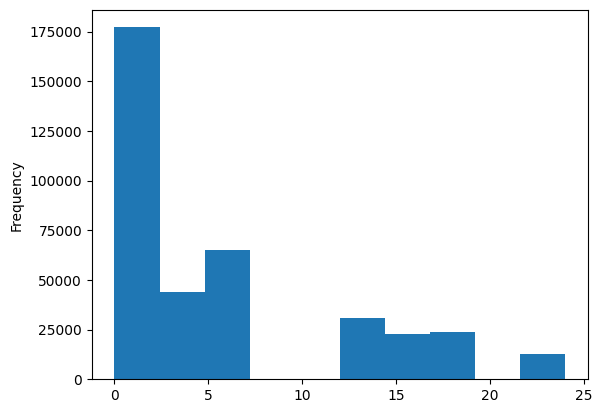

   Subject_id_1   


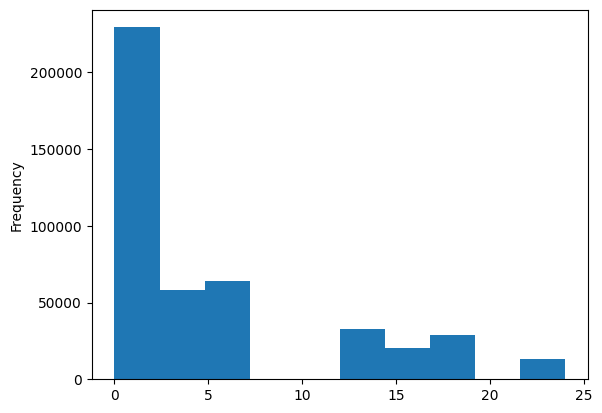

   Subject_id_2   


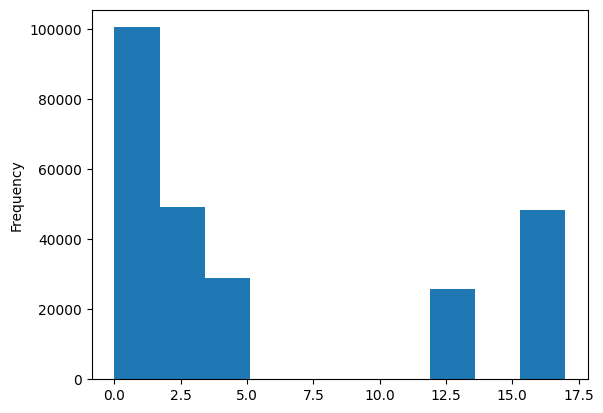

   Subject_id_3   


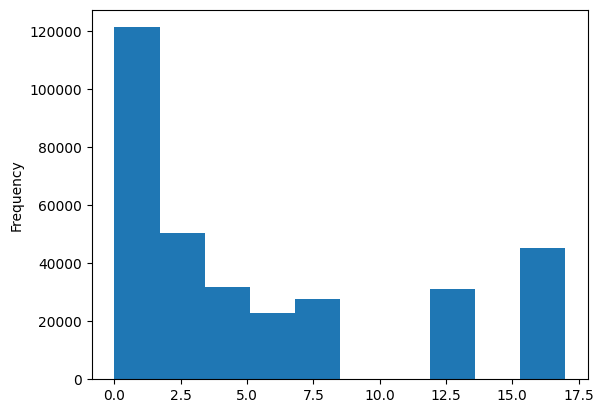

   Subject_id_4   


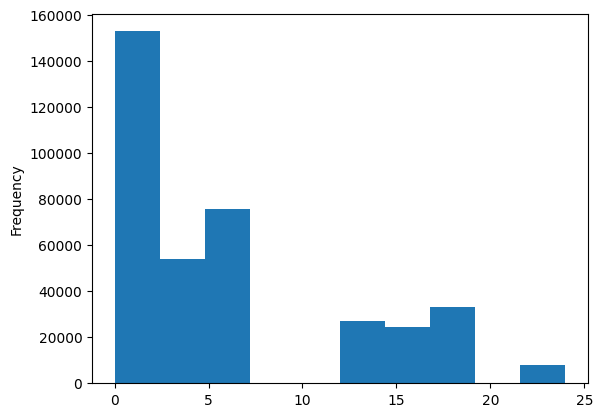

   Subject_id_5   


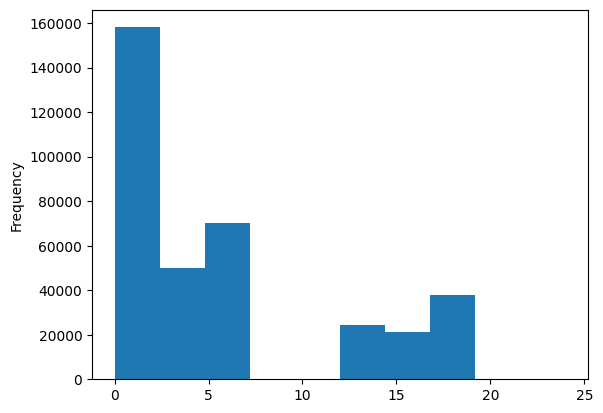

   Subject_id_6   


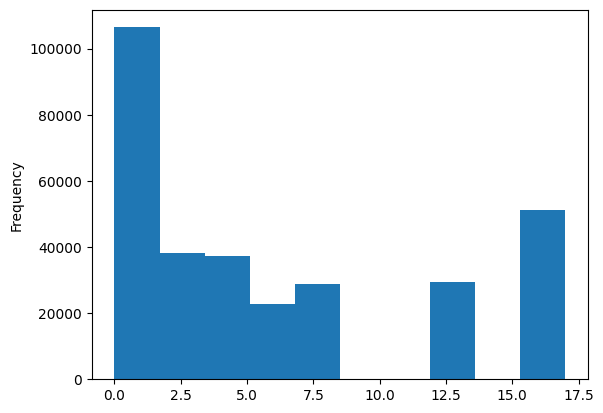

   Subject_id_7   


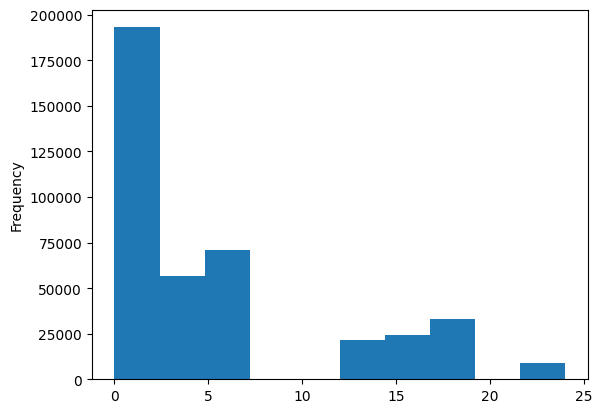

   Subject_id_8   


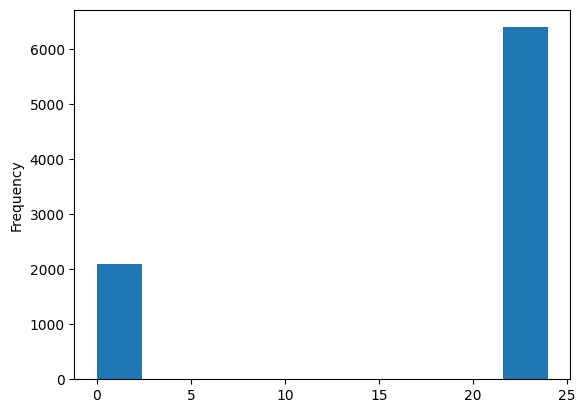

   Rows reduction checking   
Before dropping rows with NaNs: 
number of rows:  2872533
After dropping rows with NaNs: 
number of rows:  259803


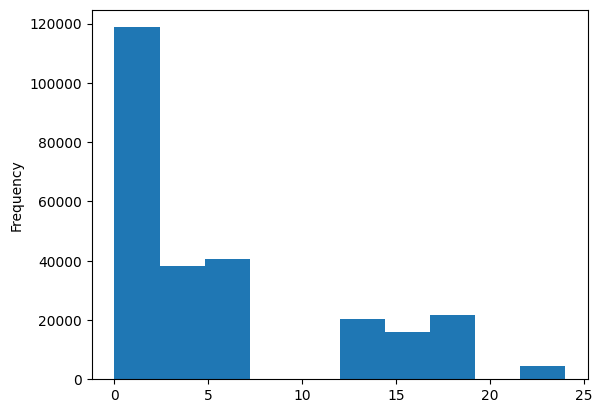

   Data description   
['activity_id', 'heart_rate', 'hand_temperature (°C)', 'hand_x_acceleration (ms-2) scale: ±16g', 'hand_y_acceleration (ms-2) scale: ±16g', 'hand_z_acceleration (ms-2) scale: ±16g', 'hand_x_acceleration (ms-2) scale: ±6g', 'hand_y_acceleration (ms-2) scale: ±6g', 'hand_z_acceleration (ms-2) scale: ±6g', 'hand_x_gyroscope data (rad/s)', 'hand_y_gyroscope data (rad/s)', 'hand_z_gyroscope data (rad/s)', 'hand_x_magnetometer data (μT)', 'hand_y_magnetometer data (μT)', 'hand_z_magnetometer data (μT)', 'chest_temperature (°C)', 'chest_x_acceleration (ms-2) scale: ±16g', 'chest_y_acceleration (ms-2) scale: ±16g', 'chest_z_acceleration (ms-2) scale: ±16g', 'chest_x_acceleration (ms-2) scale: ±6g', 'chest_y_acceleration (ms-2) scale: ±6g', 'chest_z_acceleration (ms-2) scale: ±6g', 'chest_x_gyroscope data (rad/s)', 'chest_y_gyroscope data (rad/s)', 'chest_z_gyroscope data (rad/s)', 'chest_x_magnetometer data (μT)', 'chest_y_magnetometer data (μT)', 'chest_z_magnetometer da

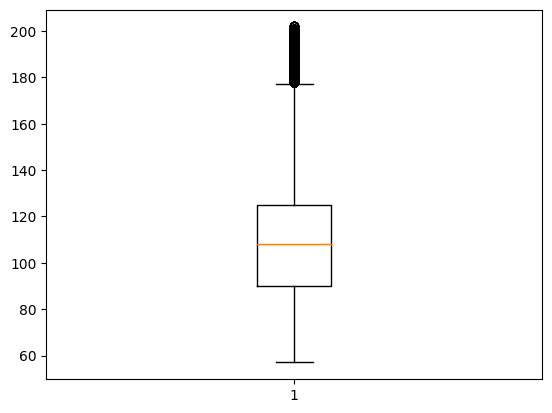




          heart_rate
count  259803.000000
mean      109.754768
std        25.849100
min        57.000000
25%        90.000000
50%       108.000000
75%       125.000000
max       202.000000
feature:  hand_temperature (°C)


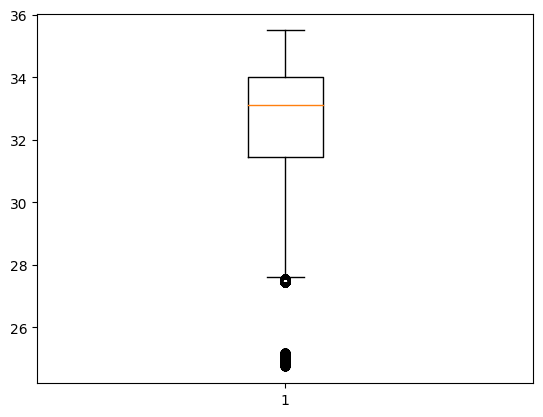




       hand_temperature (°C)
count          259803.000000
mean               32.656258
std                 1.842878
min                24.750000
25%                31.437500
50%                33.125000
75%                34.000000
max                35.500000
feature:  hand_x_acceleration (ms-2) scale: ±16g


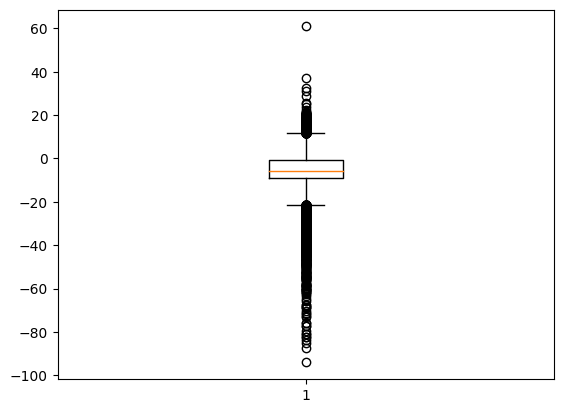




       hand_x_acceleration (ms-2) scale: ±16g
count                           259803.000000
mean                                -4.965971
std                                  6.000285
min                                -94.135900
25%                                 -9.026815
50%                                 -5.781040
75%                                 -0.781142
max                                 60.912600
feature:  hand_y_acceleration (ms-2) scale: ±16g


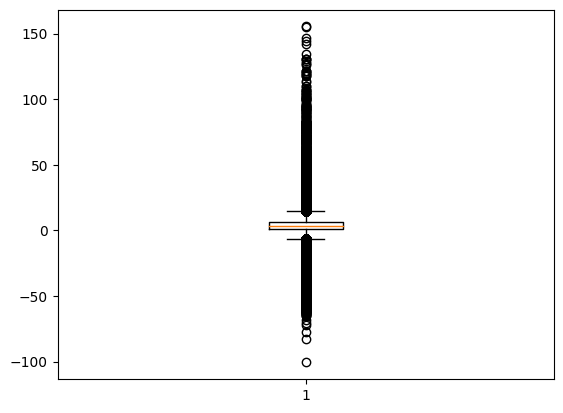




       hand_y_acceleration (ms-2) scale: ±16g
count                           259803.000000
mean                                 3.578970
std                                  6.331939
min                               -100.704000
25%                                  1.295055
50%                                  3.571320
75%                                  6.604360
max                                155.354000
feature:  hand_z_acceleration (ms-2) scale: ±16g


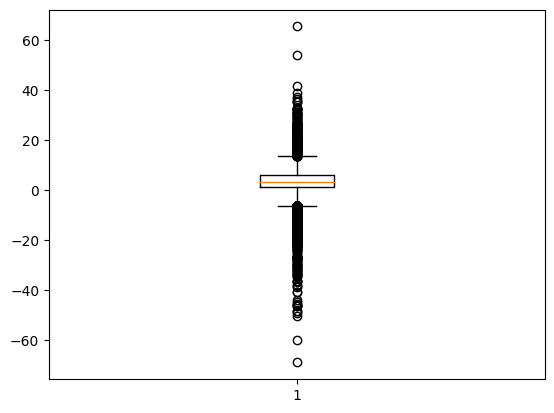




       hand_z_acceleration (ms-2) scale: ±16g
count                           259803.000000
mean                                 3.170602
std                                  3.837709
min                                -69.093500
25%                                  0.968783
50%                                  2.959840
75%                                  6.006205
max                                 65.302700
feature:  hand_x_acceleration (ms-2) scale: ±6g


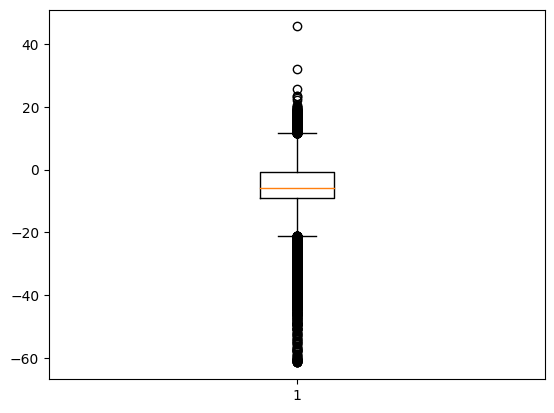




       hand_x_acceleration (ms-2) scale: ±6g
count                          259803.000000
mean                               -4.894586
std                                 6.003259
min                               -61.394800
25%                                -8.929190
50%                                -5.733840
75%                                -0.732209
max                                45.548400
feature:  hand_y_acceleration (ms-2) scale: ±6g


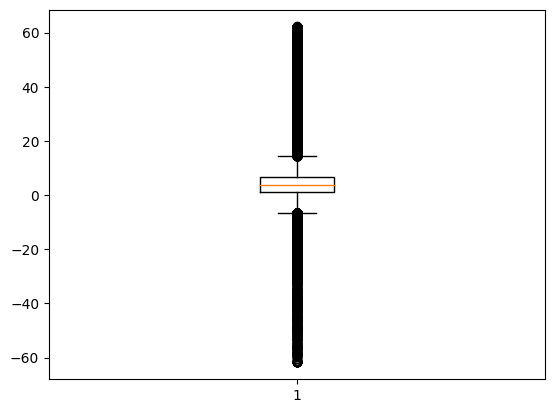




       hand_y_acceleration (ms-2) scale: ±6g
count                          259803.000000
mean                                3.572668
std                                 6.064286
min                               -61.812200
25%                                 1.293860
50%                                 3.613920
75%                                 6.596185
max                                62.247100
feature:  hand_z_acceleration (ms-2) scale: ±6g


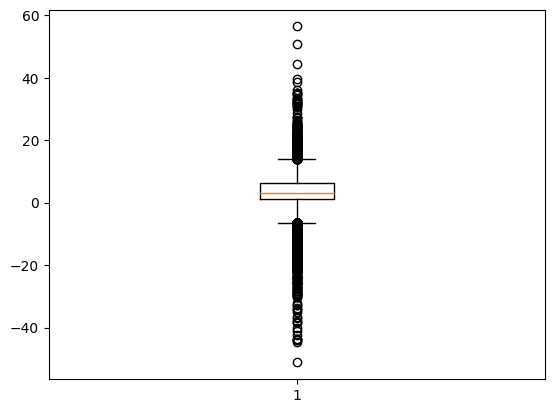




       hand_z_acceleration (ms-2) scale: ±6g
count                          259803.000000
mean                                3.354586
std                                 3.839110
min                               -51.202300
25%                                 1.165020
50%                                 3.134430
75%                                 6.261805
max                                56.449300
feature:  hand_x_gyroscope data (rad/s)


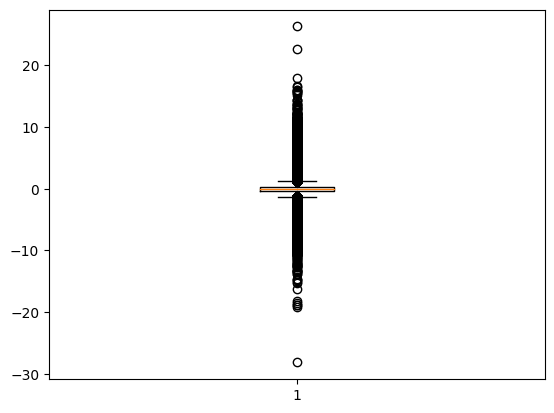




       hand_x_gyroscope data (rad/s)
count                  259803.000000
mean                       -0.002264
std                         1.297821
min                       -28.135400
25%                        -0.348505
50%                        -0.006203
75%                         0.304331
max                        26.259100
feature:  hand_y_gyroscope data (rad/s)


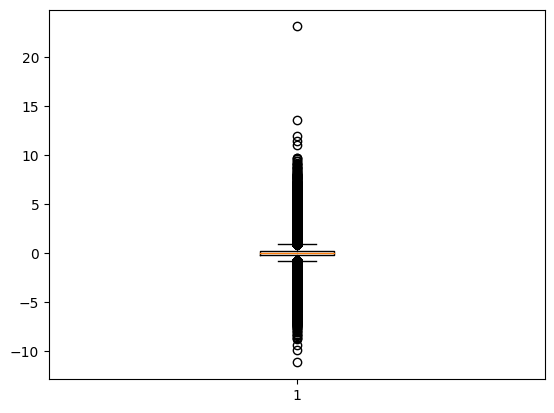




       hand_y_gyroscope data (rad/s)
count                  259803.000000
mean                        0.032976
std                         0.883807
min                       -11.163300
25%                        -0.196396
50%                         0.006248
75%                         0.237177
max                        23.077900
feature:  hand_z_gyroscope data (rad/s)


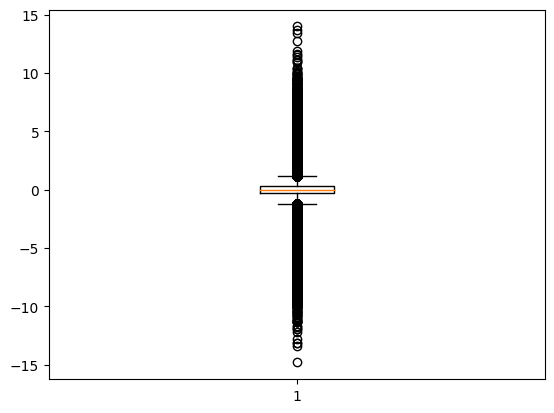




       hand_z_gyroscope data (rad/s)
count                  259803.000000
mean                       -0.007037
std                         1.453454
min                       -14.807300
25%                        -0.299558
50%                        -0.005464
75%                         0.291137
max                        14.002800
feature:  hand_x_magnetometer data (μT)


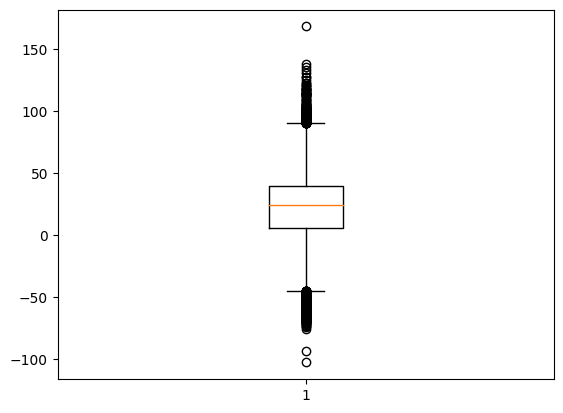




       hand_x_magnetometer data (μT)
count                  259803.000000
mean                       21.153439
std                        24.020813
min                      -102.914000
25%                         5.242620
50%                        24.121700
75%                        39.141650
max                       168.125000
feature:  hand_y_magnetometer data (μT)


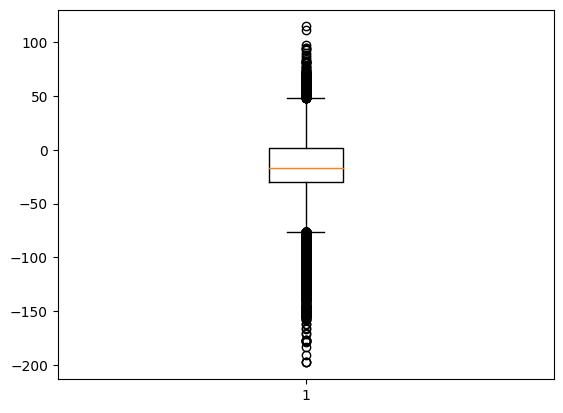




       hand_y_magnetometer data (μT)
count                  259803.000000
mean                      -14.394734
std                        24.074188
min                      -197.803000
25%                       -29.574650
50%                       -16.510600
75%                         1.701830
max                       114.833000
feature:  hand_z_magnetometer data (μT)


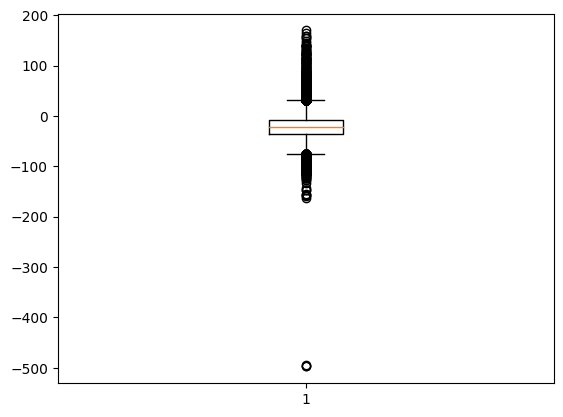




       hand_z_magnetometer data (μT)
count                  259803.000000
mean                      -21.663929
std                        20.620371
min                      -497.343000
25%                       -35.307000
50%                       -21.512600
75%                        -8.475555
max                       169.686000
feature:  chest_temperature (°C)


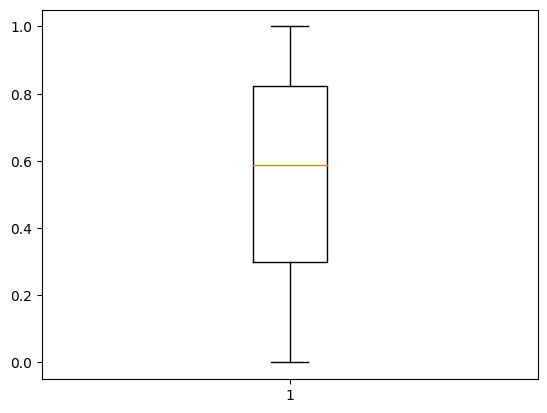




       chest_temperature (°C)
count           259803.000000
mean                 0.566697
std                  0.305419
min                  0.000006
25%                  0.300192
50%                  0.587232
75%                  0.823797
max                  1.000000
feature:  chest_x_acceleration (ms-2) scale: ±16g


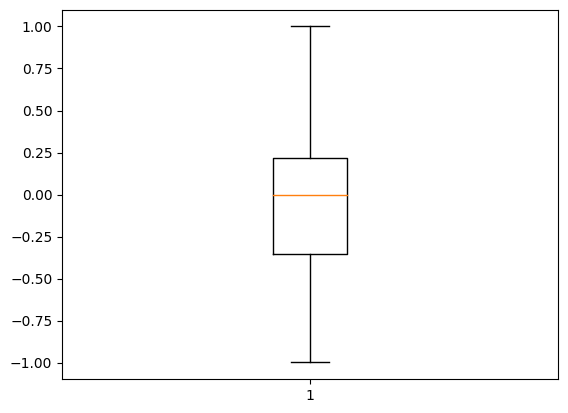




       chest_x_acceleration (ms-2) scale: ±16g
count                            259803.000000
mean                                 -0.056344
std                                   0.377789
min                                  -0.999066
25%                                  -0.354537
50%                                   0.000000
75%                                   0.219701
max                                   0.999943
feature:  chest_y_acceleration (ms-2) scale: ±16g


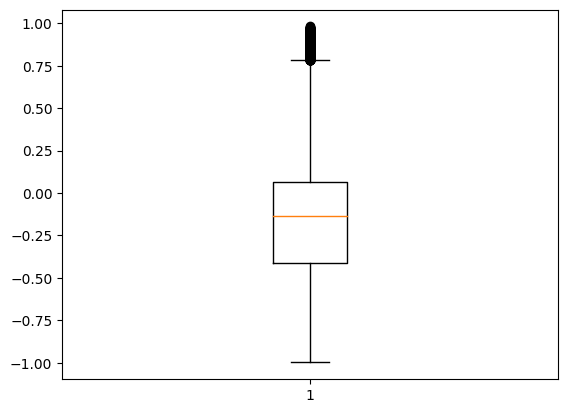




       chest_y_acceleration (ms-2) scale: ±16g
count                            259803.000000
mean                                 -0.138652
std                                   0.335414
min                                  -0.998245
25%                                  -0.412961
50%                                  -0.137367
75%                                   0.065385
max                                   0.981068
feature:  chest_z_acceleration (ms-2) scale: ±16g


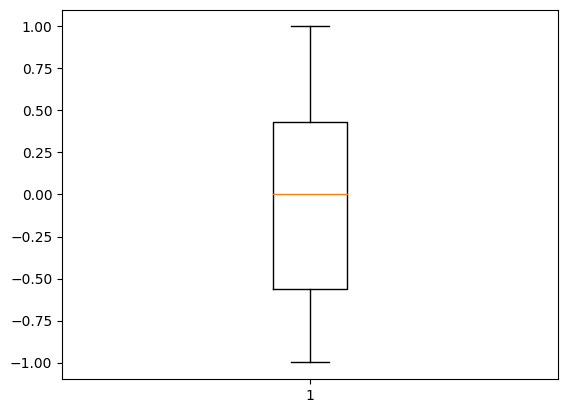




       chest_z_acceleration (ms-2) scale: ±16g
count                            259803.000000
mean                                 -0.032628
std                                   0.553973
min                                  -0.999176
25%                                  -0.560726
50%                                   0.000000
75%                                   0.431800
max                                   0.999336
feature:  chest_x_acceleration (ms-2) scale: ±6g


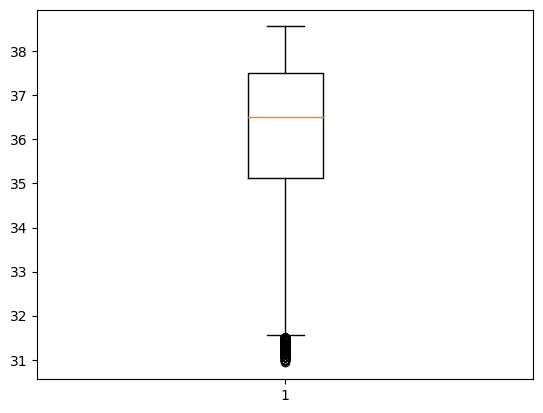




       chest_x_acceleration (ms-2) scale: ±6g
count                           259803.000000
mean                                36.153004
std                                  1.583808
min                                 30.937500
25%                                 35.125000
50%                                 36.500000
75%                                 37.500000
max                                 38.562500
feature:  chest_y_acceleration (ms-2) scale: ±6g


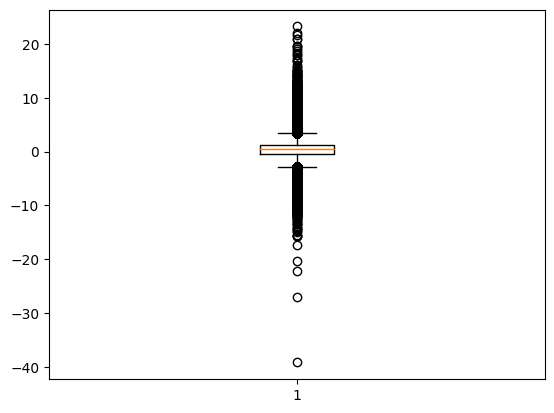




       chest_y_acceleration (ms-2) scale: ±6g
count                           259803.000000
mean                                 0.377182
std                                  1.629299
min                                -39.203400
25%                                 -0.416720
50%                                  0.447528
75%                                  1.153910
max                                 23.274600
feature:  chest_z_acceleration (ms-2) scale: ±6g


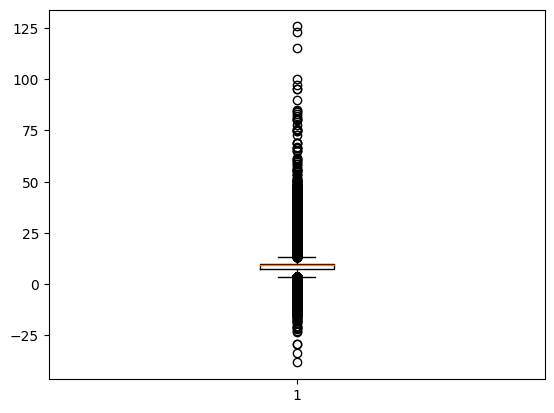




       chest_z_acceleration (ms-2) scale: ±6g
count                           259803.000000
mean                                 8.521217
std                                  4.226980
min                                -38.165700
25%                                  7.321435
50%                                  9.393400
75%                                  9.800695
max                                125.735000
feature:  chest_x_gyroscope data (rad/s)


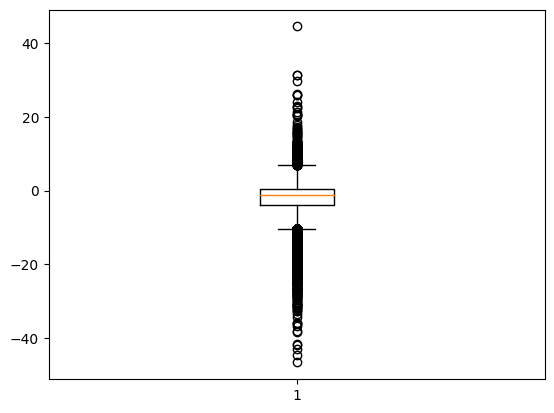




       chest_x_gyroscope data (rad/s)
count                   259803.000000
mean                        -1.510486
std                          4.182911
min                        -46.599900
25%                         -3.876970
50%                         -1.282430
75%                          0.400967
max                         44.498900
feature:  chest_y_gyroscope data (rad/s)


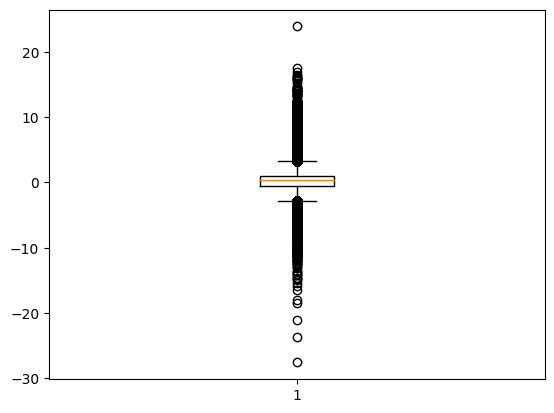




       chest_y_gyroscope data (rad/s)
count                   259803.000000
mean                         0.244593
std                          1.620128
min                        -27.598400
25%                         -0.532498
50%                          0.319247
75%                          1.003800
max                         23.910100
feature:  chest_z_gyroscope data (rad/s)


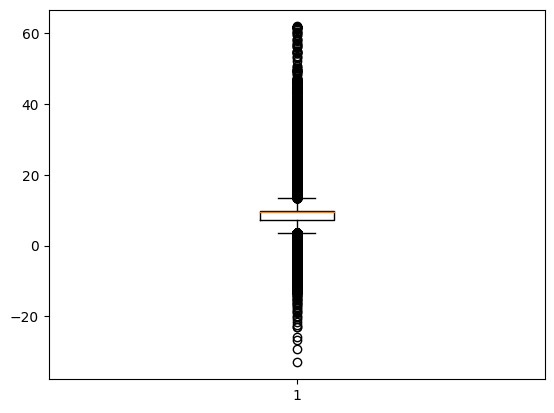




       chest_z_gyroscope data (rad/s)
count                   259803.000000
mean                         8.512339
std                          4.193043
min                        -33.053100
25%                          7.303050
50%                          9.355990
75%                          9.811510
max                         61.937300
feature:  chest_x_magnetometer data (μT)


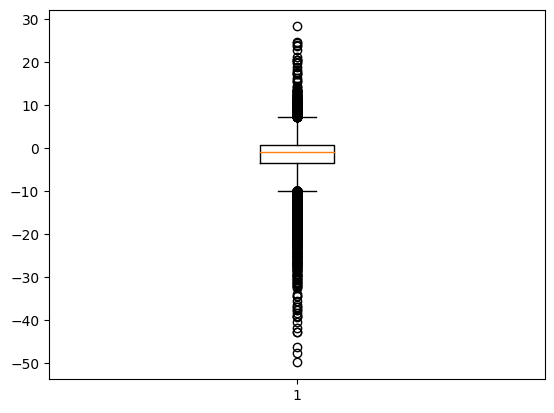




       chest_x_magnetometer data (μT)
count                   259803.000000
mean                        -1.177747
std                          4.200642
min                        -49.776500
25%                         -3.562895
50%                         -0.916958
75%                          0.761874
max                         28.252000
feature:  chest_y_magnetometer data (μT)


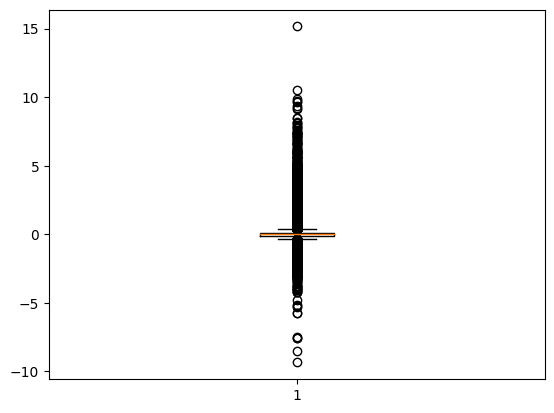




       chest_y_magnetometer data (μT)
count                   259803.000000
mean                         0.005688
std                          0.398084
min                         -9.343510
25%                         -0.092057
50%                          0.003245
75%                          0.098429
max                         15.152200
feature:  chest_z_magnetometer data (μT)


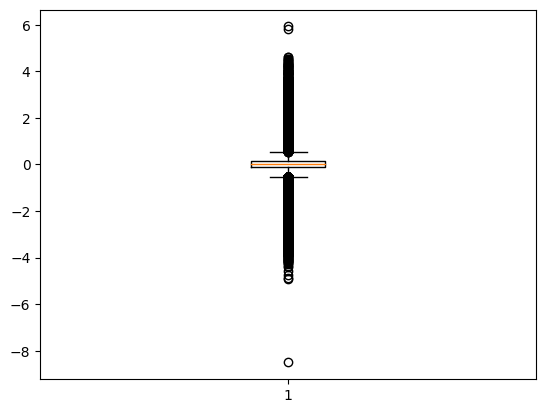




       chest_z_magnetometer data (μT)
count                   259803.000000
mean                         0.008133
std                          0.539031
min                         -8.499900
25%                         -0.125937
50%                          0.000012
75%                          0.147044
max                          5.923320
feature:  ankle_temperature (°C)


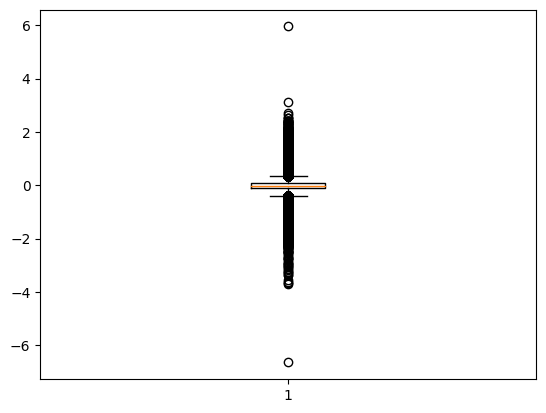




       ankle_temperature (°C)
count           259803.000000
mean                -0.021312
std                  0.291768
min                 -6.640760
25%                 -0.112283
50%                 -0.016381
75%                  0.070927
max                  5.954330
feature:  ankle_x_acceleration (ms-2) scale: ±16g


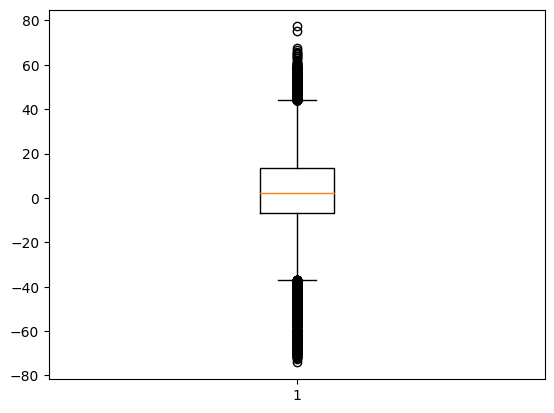




       ankle_x_acceleration (ms-2) scale: ±16g
count                            259803.000000
mean                                  3.609813
std                                  16.466561
min                                 -74.147200
25%                                  -6.748465
50%                                   2.268050
75%                                  13.532250
max                                  77.300300
feature:  ankle_y_acceleration (ms-2) scale: ±16g


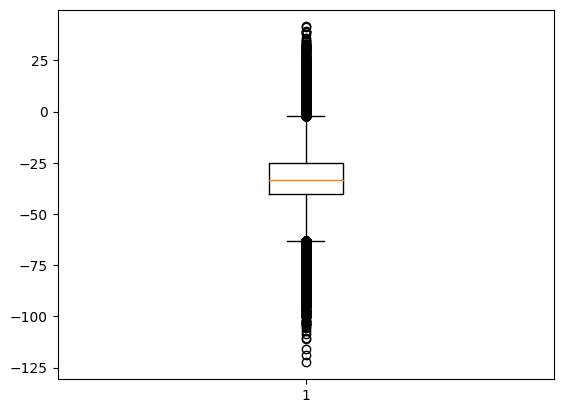




       ankle_y_acceleration (ms-2) scale: ±16g
count                            259803.000000
mean                                -31.817371
std                                  16.143496
min                                -122.480000
25%                                 -40.189950
50%                                 -33.468200
75%                                 -24.952600
max                                  41.565400
feature:  ankle_z_acceleration (ms-2) scale: ±16g


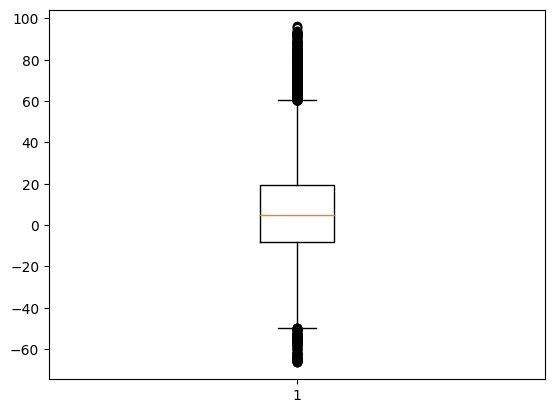




       ankle_z_acceleration (ms-2) scale: ±16g
count                            259803.000000
mean                                  5.495052
std                                  19.943562
min                                 -66.428400
25%                                  -8.335410
50%                                   5.069670
75%                                  19.229450
max                                  96.102200
feature:  ankle_x_acceleration (ms-2) scale: ±6g


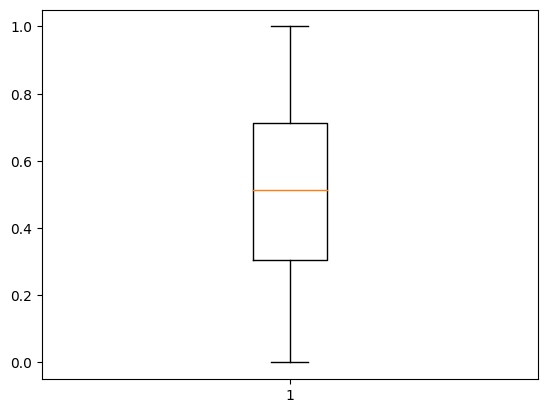




       ankle_x_acceleration (ms-2) scale: ±6g
count                           259803.000000
mean                                 0.532607
std                                  0.289807
min                                  0.000017
25%                                  0.305582
50%                                  0.512581
75%                                  0.712287
max                                  1.000000
feature:  ankle_y_acceleration (ms-2) scale: ±6g


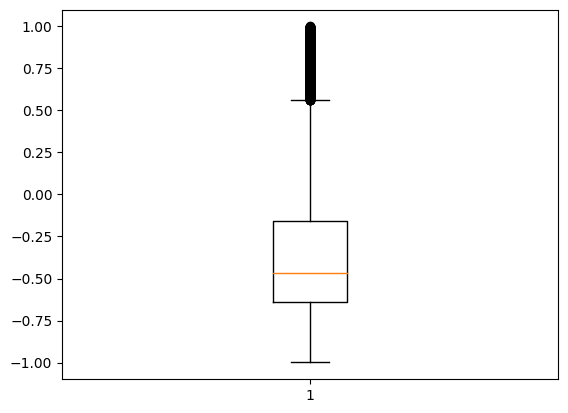




       ankle_y_acceleration (ms-2) scale: ±6g
count                           259803.000000
mean                                -0.406671
std                                  0.294856
min                                 -0.999294
25%                                 -0.640659
50%                                 -0.468319
75%                                 -0.159475
max                                  0.998773
feature:  ankle_z_acceleration (ms-2) scale: ±6g


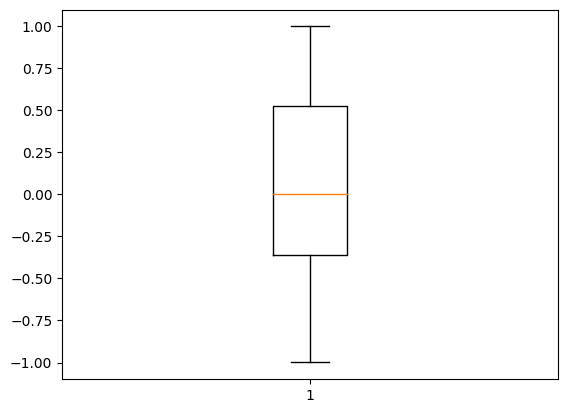




       ankle_z_acceleration (ms-2) scale: ±6g
count                           259803.000000
mean                                 0.054972
std                                  0.476136
min                                 -0.999621
25%                                 -0.358320
50%                                  0.000000
75%                                  0.521702
max                                  0.996031
feature:  ankle_x_gyroscope data (rad/s)


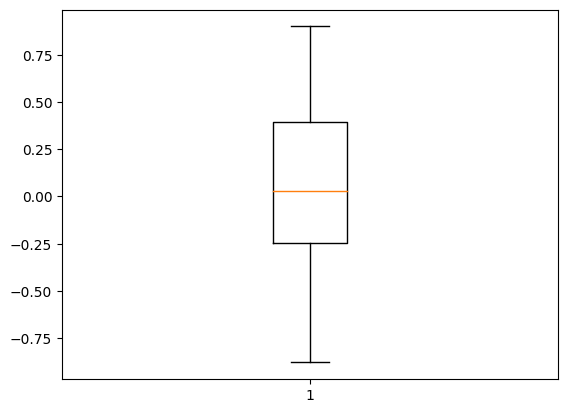




       ankle_x_gyroscope data (rad/s)
count                   259803.000000
mean                         0.048367
std                          0.384649
min                         -0.878761
25%                         -0.247869
50%                          0.027814
75%                          0.394159
max                          0.900024
feature:  ankle_y_gyroscope data (rad/s)


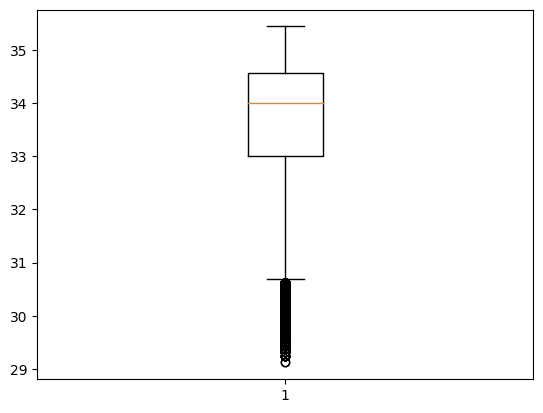




       ankle_y_gyroscope data (rad/s)
count                   259803.000000
mean                        33.687459
std                          1.183771
min                         29.125000
25%                         33.000000
50%                         34.000000
75%                         34.562500
max                         35.437500
feature:  ankle_z_gyroscope data (rad/s)


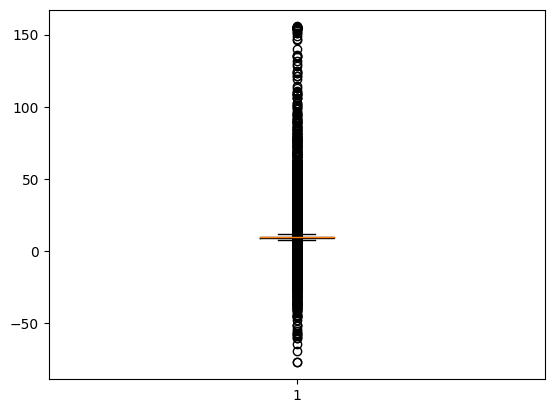




       ankle_z_gyroscope data (rad/s)
count                   259803.000000
mean                         9.527137
std                          5.797091
min                        -77.324900
25%                          9.025780
50%                          9.570960
75%                          9.995700
max                        155.655000
feature:  ankle_x_magnetometer data (μT)


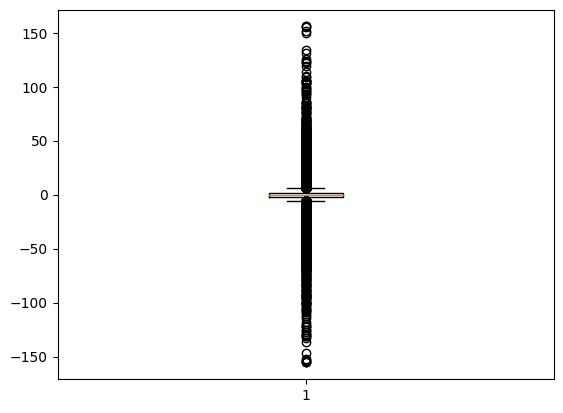




       ankle_x_magnetometer data (μT)
count                   259803.000000
mean                        -0.128176
std                          6.814865
min                       -155.513000
25%                         -1.759470
50%                         -0.271777
75%                          1.263620
max                        155.799000
feature:  ankle_y_magnetometer data (μT)


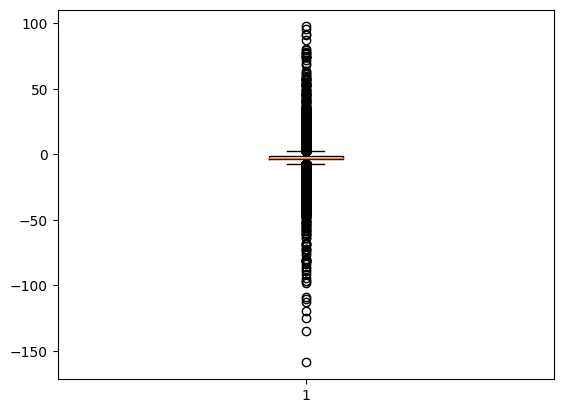




       ankle_y_magnetometer data (μT)
count                   259803.000000
mean                        -2.463972
std                          3.587473
min                       -158.830000
25%                         -3.642550
50%                         -2.358300
75%                         -1.059695
max                         97.672100
feature:  ankle_z_magnetometer data (μT)


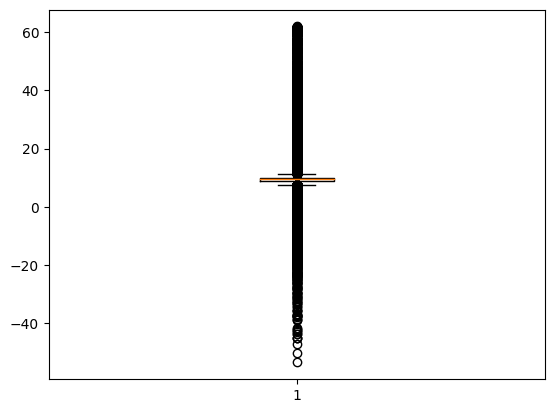




       ankle_z_magnetometer data (μT)
count                   259803.000000
mean                         9.505924
std                          5.364949
min                        -53.405700
25%                          9.000800
50%                          9.583560
75%                          9.983225
max                         61.922600
   Getting train-test datasets   
Assembly-normalise
Train-test splitting
Assembly-normalise train
Assembly-normalise test
Train schema: 
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)

Test schema: 
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
train,test = rows_with_NaNs_dropping(dfs_nts, True)

##### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

##### Testing

In [ ]:
testing(test,train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_42ecff874ced
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_430ec028c480
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|

#### Non-normalised

   DataFrames union   
   Subject_id_0   


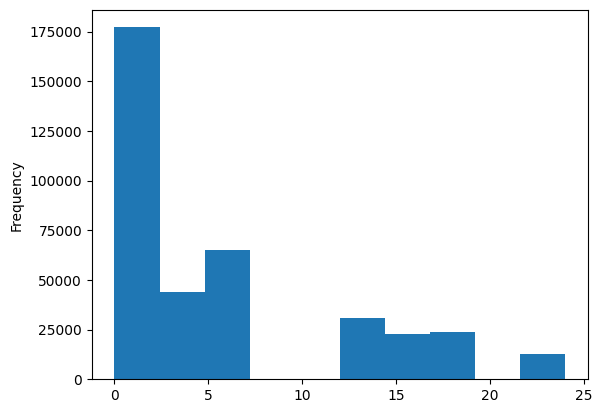

   Subject_id_1   


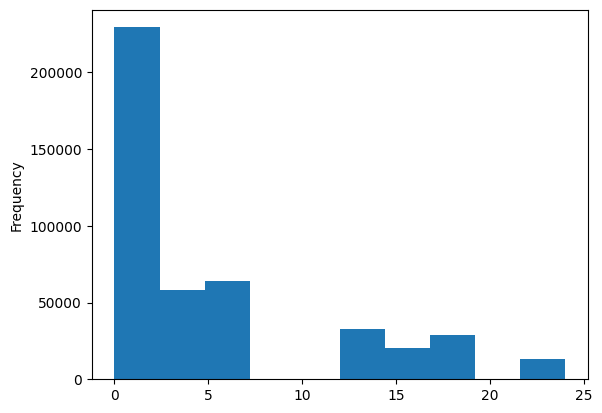

   Subject_id_2   


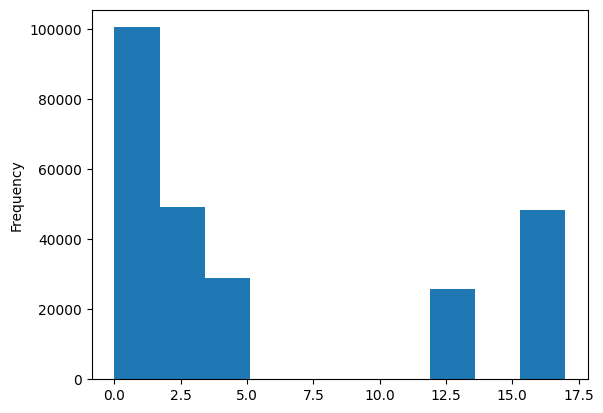

   Subject_id_3   


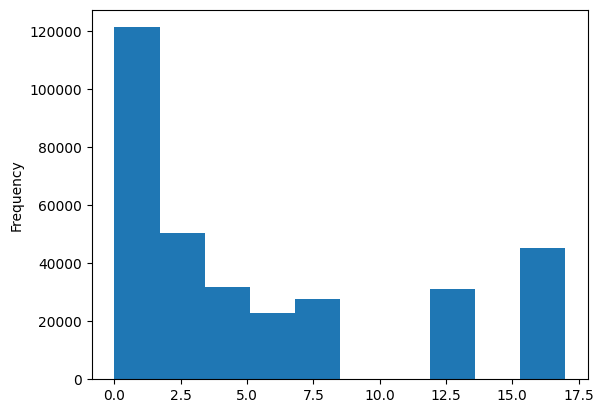

   Subject_id_4   


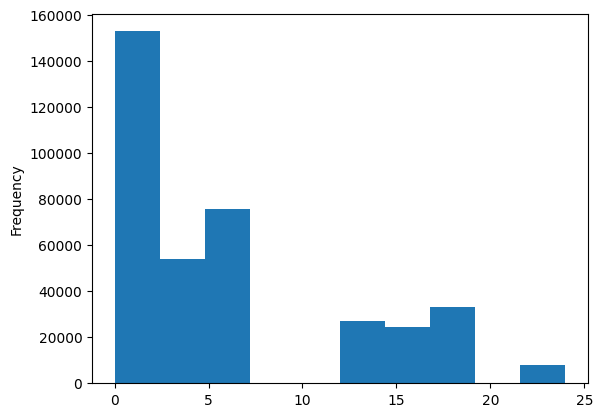

   Subject_id_5   


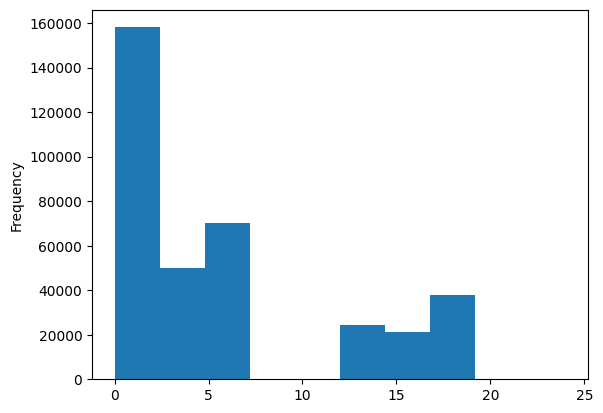

   Subject_id_6   


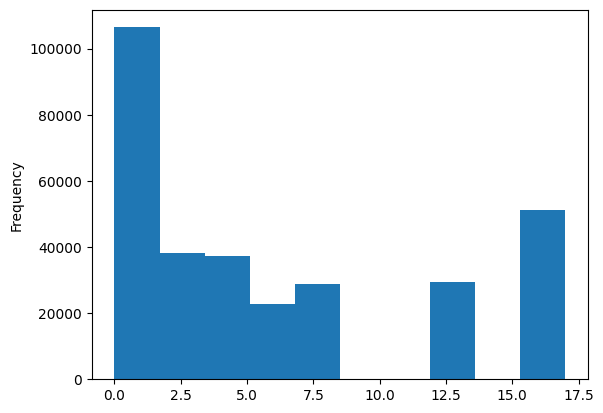

   Subject_id_7   


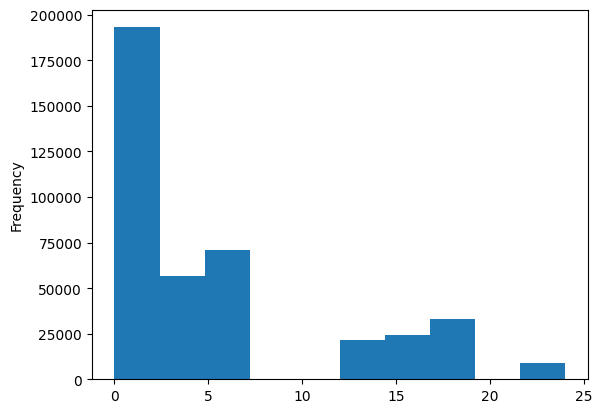

   Subject_id_8   


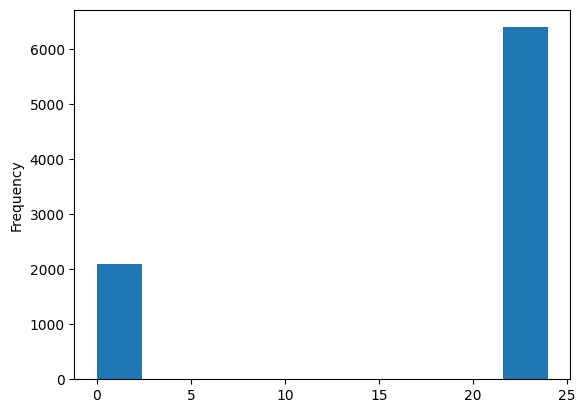

   Rows reduction checking   
Before dropping rows with NaNs: 
number of rows:  2872533
After dropping rows with NaNs: 
number of rows:  259803


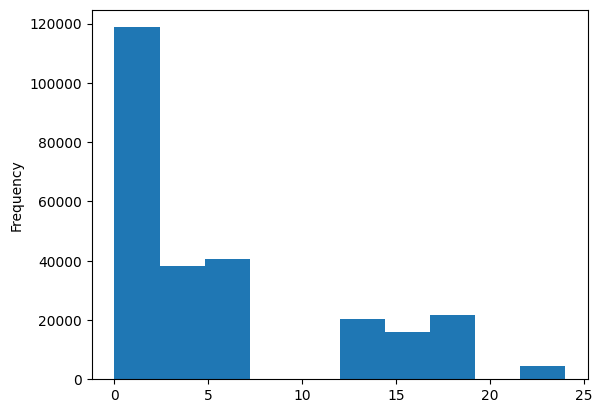

   Data description   
['activity_id', 'heart_rate', 'hand_temperature (°C)', 'hand_x_acceleration (ms-2) scale: ±16g', 'hand_y_acceleration (ms-2) scale: ±16g', 'hand_z_acceleration (ms-2) scale: ±16g', 'hand_x_acceleration (ms-2) scale: ±6g', 'hand_y_acceleration (ms-2) scale: ±6g', 'hand_z_acceleration (ms-2) scale: ±6g', 'hand_x_gyroscope data (rad/s)', 'hand_y_gyroscope data (rad/s)', 'hand_z_gyroscope data (rad/s)', 'hand_x_magnetometer data (μT)', 'hand_y_magnetometer data (μT)', 'hand_z_magnetometer data (μT)', 'chest_temperature (°C)', 'chest_x_acceleration (ms-2) scale: ±16g', 'chest_y_acceleration (ms-2) scale: ±16g', 'chest_z_acceleration (ms-2) scale: ±16g', 'chest_x_acceleration (ms-2) scale: ±6g', 'chest_y_acceleration (ms-2) scale: ±6g', 'chest_z_acceleration (ms-2) scale: ±6g', 'chest_x_gyroscope data (rad/s)', 'chest_y_gyroscope data (rad/s)', 'chest_z_gyroscope data (rad/s)', 'chest_x_magnetometer data (μT)', 'chest_y_magnetometer data (μT)', 'chest_z_magnetometer da

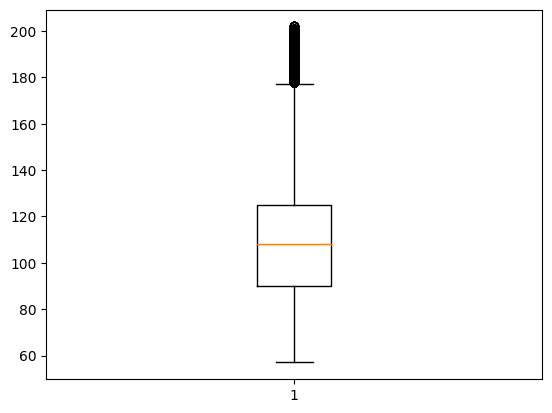




          heart_rate
count  259803.000000
mean      109.754768
std        25.849100
min        57.000000
25%        90.000000
50%       108.000000
75%       125.000000
max       202.000000
feature:  hand_temperature (°C)


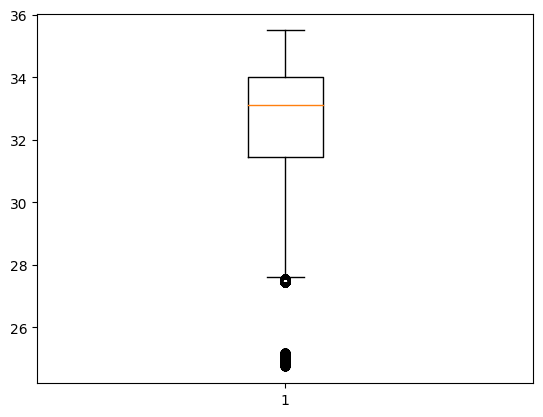




       hand_temperature (°C)
count          259803.000000
mean               32.656258
std                 1.842878
min                24.750000
25%                31.437500
50%                33.125000
75%                34.000000
max                35.500000
feature:  hand_x_acceleration (ms-2) scale: ±16g


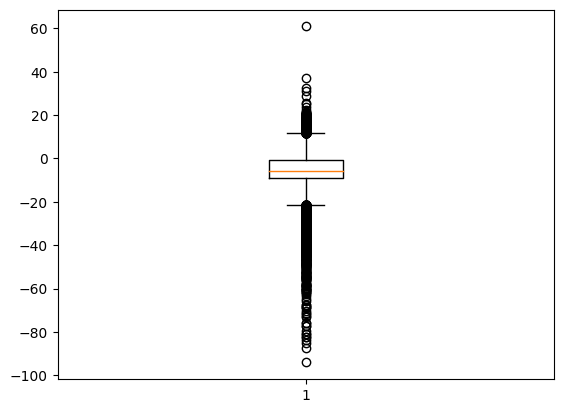




       hand_x_acceleration (ms-2) scale: ±16g
count                           259803.000000
mean                                -4.965971
std                                  6.000285
min                                -94.135900
25%                                 -9.026815
50%                                 -5.781040
75%                                 -0.781142
max                                 60.912600
feature:  hand_y_acceleration (ms-2) scale: ±16g


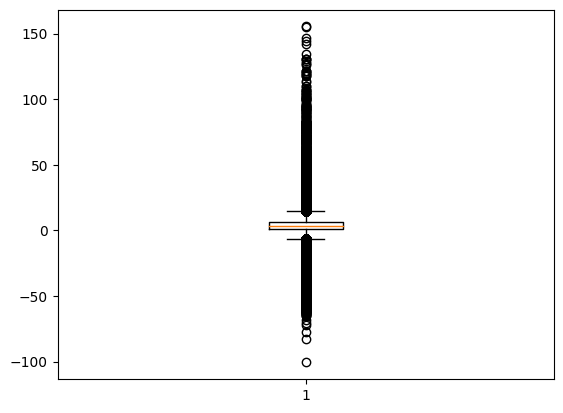




       hand_y_acceleration (ms-2) scale: ±16g
count                           259803.000000
mean                                 3.578970
std                                  6.331939
min                               -100.704000
25%                                  1.295055
50%                                  3.571320
75%                                  6.604360
max                                155.354000
feature:  hand_z_acceleration (ms-2) scale: ±16g


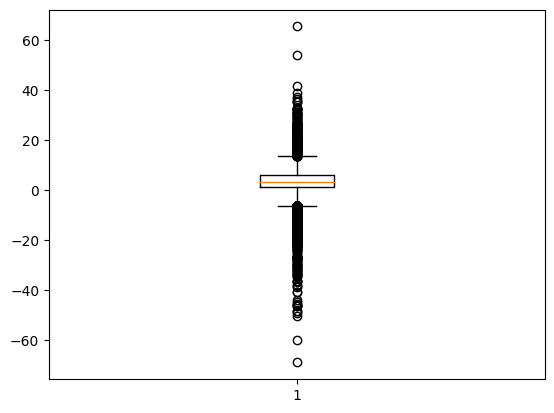




       hand_z_acceleration (ms-2) scale: ±16g
count                           259803.000000
mean                                 3.170602
std                                  3.837709
min                                -69.093500
25%                                  0.968783
50%                                  2.959840
75%                                  6.006205
max                                 65.302700
feature:  hand_x_acceleration (ms-2) scale: ±6g


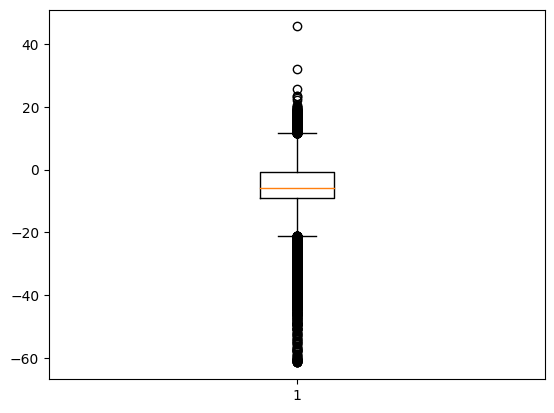




       hand_x_acceleration (ms-2) scale: ±6g
count                          259803.000000
mean                               -4.894586
std                                 6.003259
min                               -61.394800
25%                                -8.929190
50%                                -5.733840
75%                                -0.732209
max                                45.548400
feature:  hand_y_acceleration (ms-2) scale: ±6g


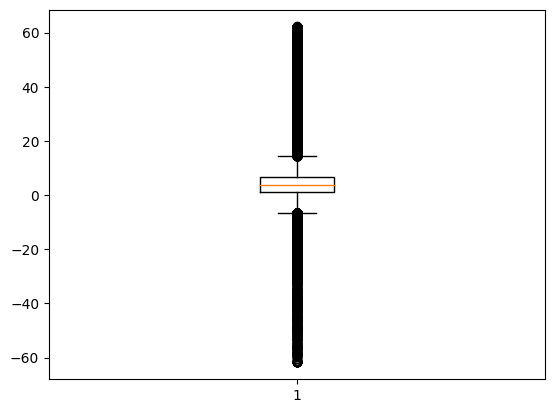




       hand_y_acceleration (ms-2) scale: ±6g
count                          259803.000000
mean                                3.572668
std                                 6.064286
min                               -61.812200
25%                                 1.293860
50%                                 3.613920
75%                                 6.596185
max                                62.247100
feature:  hand_z_acceleration (ms-2) scale: ±6g


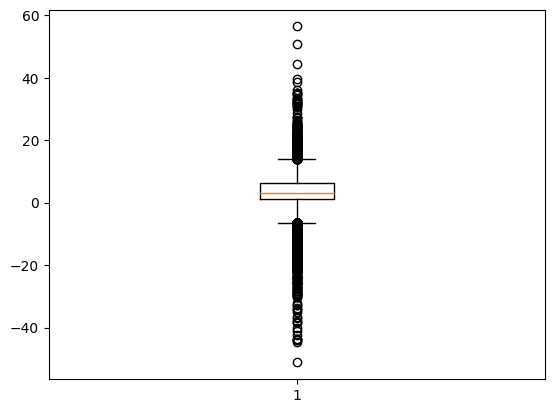




       hand_z_acceleration (ms-2) scale: ±6g
count                          259803.000000
mean                                3.354586
std                                 3.839110
min                               -51.202300
25%                                 1.165020
50%                                 3.134430
75%                                 6.261805
max                                56.449300
feature:  hand_x_gyroscope data (rad/s)


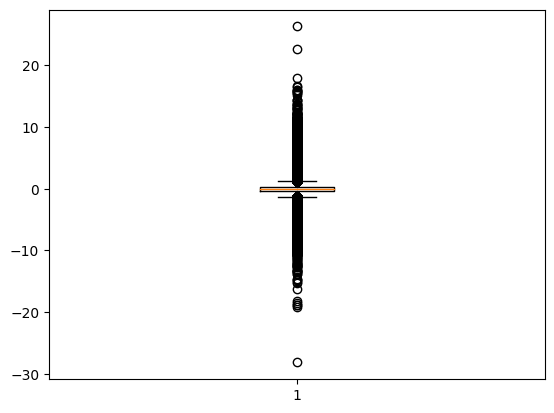




       hand_x_gyroscope data (rad/s)
count                  259803.000000
mean                       -0.002264
std                         1.297821
min                       -28.135400
25%                        -0.348505
50%                        -0.006203
75%                         0.304331
max                        26.259100
feature:  hand_y_gyroscope data (rad/s)


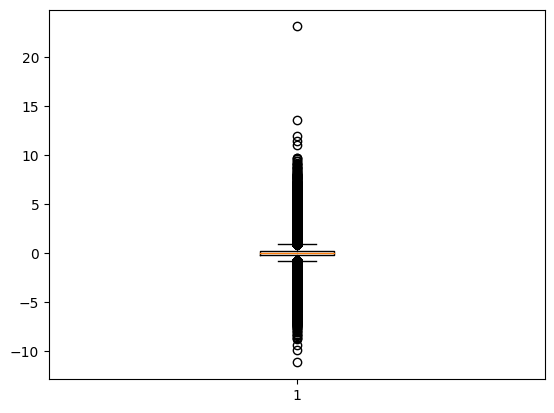




       hand_y_gyroscope data (rad/s)
count                  259803.000000
mean                        0.032976
std                         0.883807
min                       -11.163300
25%                        -0.196396
50%                         0.006248
75%                         0.237177
max                        23.077900
feature:  hand_z_gyroscope data (rad/s)


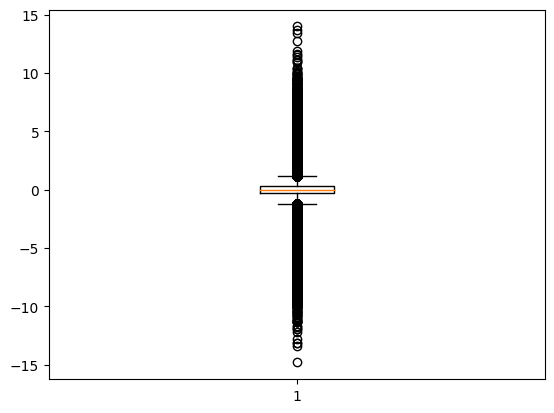




       hand_z_gyroscope data (rad/s)
count                  259803.000000
mean                       -0.007037
std                         1.453454
min                       -14.807300
25%                        -0.299558
50%                        -0.005464
75%                         0.291137
max                        14.002800
feature:  hand_x_magnetometer data (μT)


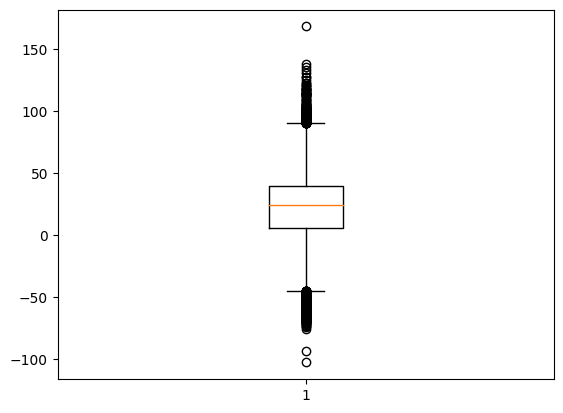




       hand_x_magnetometer data (μT)
count                  259803.000000
mean                       21.153439
std                        24.020813
min                      -102.914000
25%                         5.242620
50%                        24.121700
75%                        39.141650
max                       168.125000
feature:  hand_y_magnetometer data (μT)


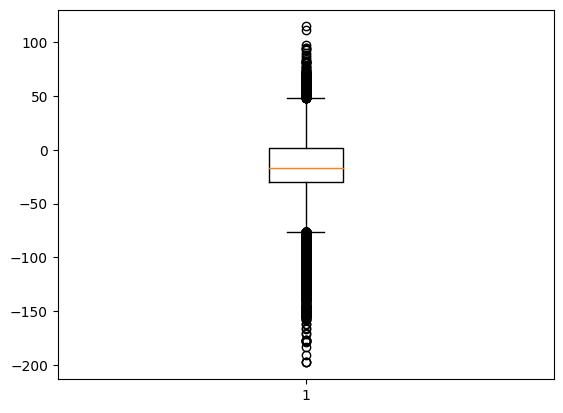




       hand_y_magnetometer data (μT)
count                  259803.000000
mean                      -14.394734
std                        24.074188
min                      -197.803000
25%                       -29.574650
50%                       -16.510600
75%                         1.701830
max                       114.833000
feature:  hand_z_magnetometer data (μT)


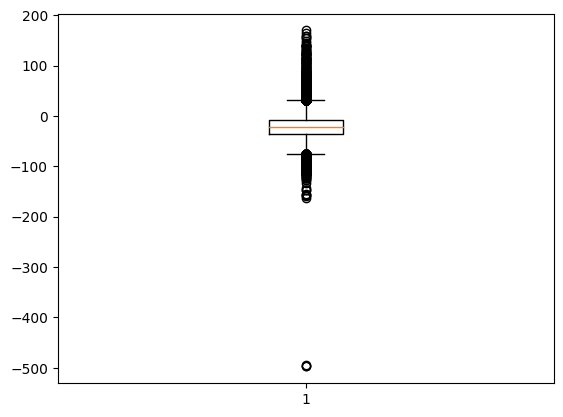




       hand_z_magnetometer data (μT)
count                  259803.000000
mean                      -21.663929
std                        20.620371
min                      -497.343000
25%                       -35.307000
50%                       -21.512600
75%                        -8.475555
max                       169.686000
feature:  chest_temperature (°C)


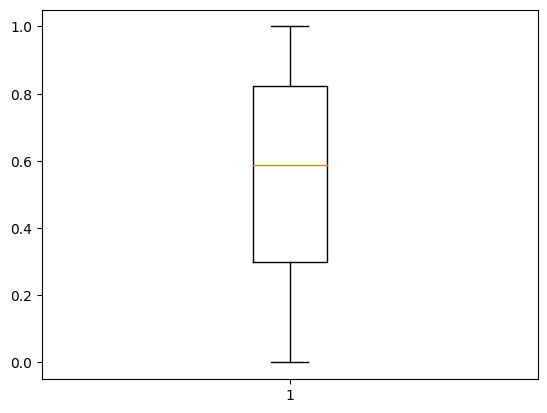




       chest_temperature (°C)
count           259803.000000
mean                 0.566697
std                  0.305419
min                  0.000006
25%                  0.300192
50%                  0.587232
75%                  0.823797
max                  1.000000
feature:  chest_x_acceleration (ms-2) scale: ±16g


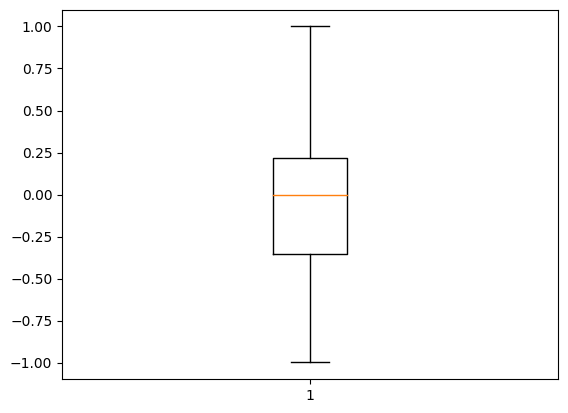




       chest_x_acceleration (ms-2) scale: ±16g
count                            259803.000000
mean                                 -0.056344
std                                   0.377789
min                                  -0.999066
25%                                  -0.354537
50%                                   0.000000
75%                                   0.219701
max                                   0.999943
feature:  chest_y_acceleration (ms-2) scale: ±16g


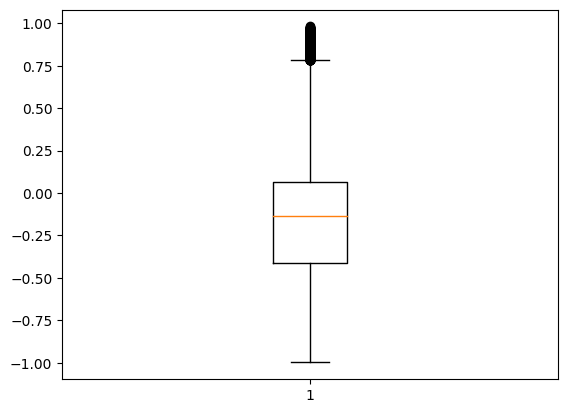




       chest_y_acceleration (ms-2) scale: ±16g
count                            259803.000000
mean                                 -0.138652
std                                   0.335414
min                                  -0.998245
25%                                  -0.412961
50%                                  -0.137367
75%                                   0.065385
max                                   0.981068
feature:  chest_z_acceleration (ms-2) scale: ±16g


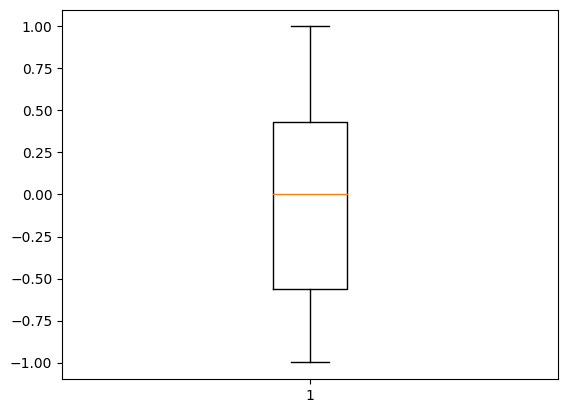




       chest_z_acceleration (ms-2) scale: ±16g
count                            259803.000000
mean                                 -0.032628
std                                   0.553973
min                                  -0.999176
25%                                  -0.560726
50%                                   0.000000
75%                                   0.431800
max                                   0.999336
feature:  chest_x_acceleration (ms-2) scale: ±6g


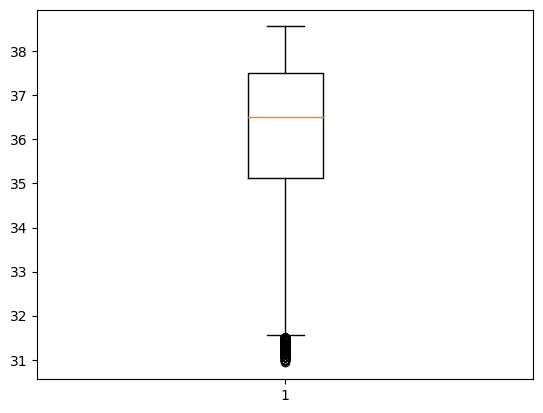




       chest_x_acceleration (ms-2) scale: ±6g
count                           259803.000000
mean                                36.153004
std                                  1.583808
min                                 30.937500
25%                                 35.125000
50%                                 36.500000
75%                                 37.500000
max                                 38.562500
feature:  chest_y_acceleration (ms-2) scale: ±6g


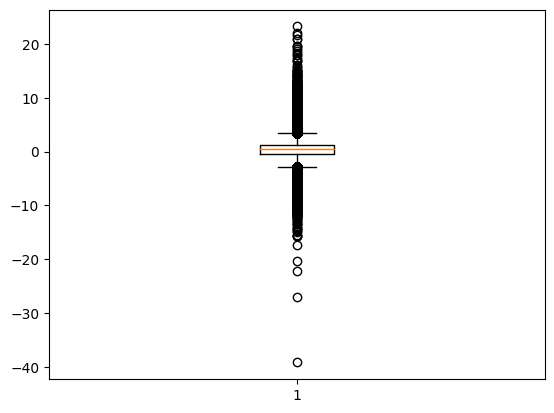




       chest_y_acceleration (ms-2) scale: ±6g
count                           259803.000000
mean                                 0.377182
std                                  1.629299
min                                -39.203400
25%                                 -0.416720
50%                                  0.447528
75%                                  1.153910
max                                 23.274600
feature:  chest_z_acceleration (ms-2) scale: ±6g


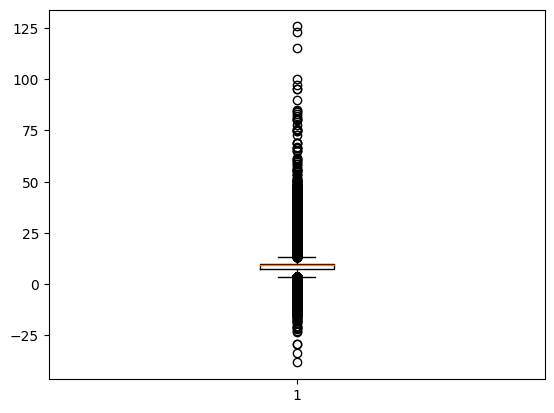




       chest_z_acceleration (ms-2) scale: ±6g
count                           259803.000000
mean                                 8.521217
std                                  4.226980
min                                -38.165700
25%                                  7.321435
50%                                  9.393400
75%                                  9.800695
max                                125.735000
feature:  chest_x_gyroscope data (rad/s)


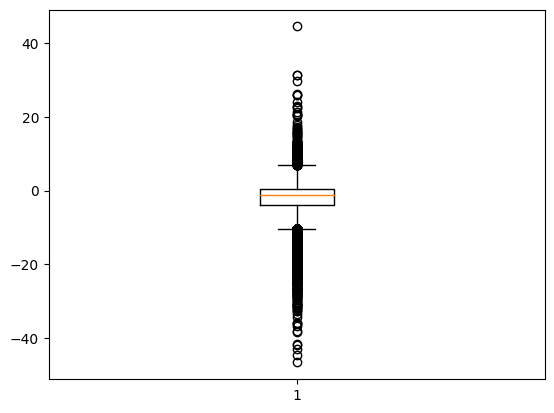




       chest_x_gyroscope data (rad/s)
count                   259803.000000
mean                        -1.510486
std                          4.182911
min                        -46.599900
25%                         -3.876970
50%                         -1.282430
75%                          0.400967
max                         44.498900
feature:  chest_y_gyroscope data (rad/s)


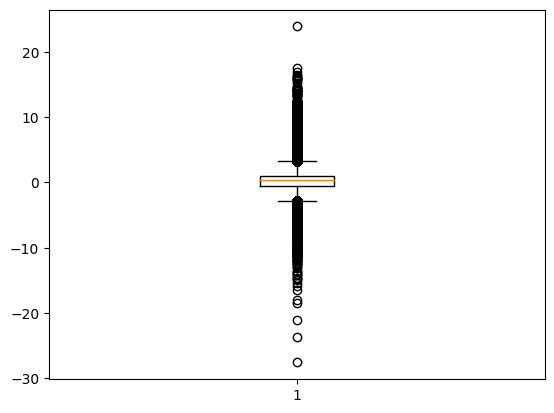




       chest_y_gyroscope data (rad/s)
count                   259803.000000
mean                         0.244593
std                          1.620128
min                        -27.598400
25%                         -0.532498
50%                          0.319247
75%                          1.003800
max                         23.910100
feature:  chest_z_gyroscope data (rad/s)


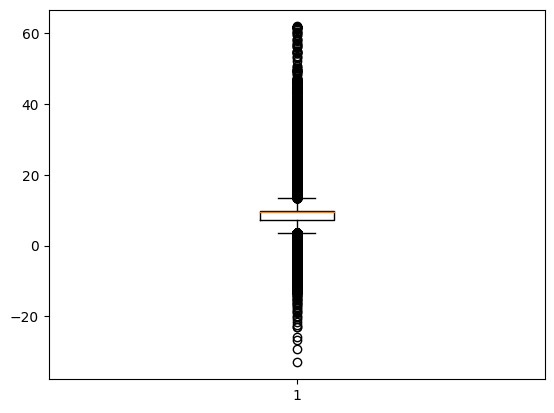




       chest_z_gyroscope data (rad/s)
count                   259803.000000
mean                         8.512339
std                          4.193043
min                        -33.053100
25%                          7.303050
50%                          9.355990
75%                          9.811510
max                         61.937300
feature:  chest_x_magnetometer data (μT)


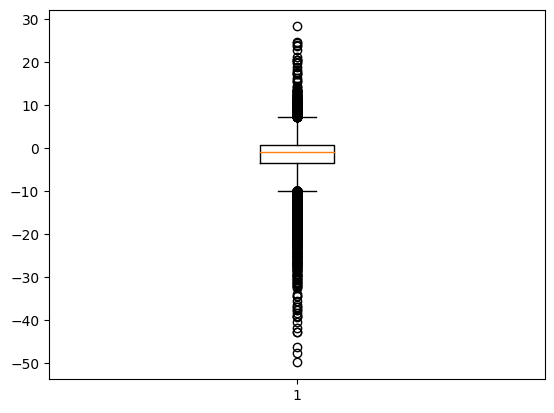




       chest_x_magnetometer data (μT)
count                   259803.000000
mean                        -1.177747
std                          4.200642
min                        -49.776500
25%                         -3.562895
50%                         -0.916958
75%                          0.761874
max                         28.252000
feature:  chest_y_magnetometer data (μT)


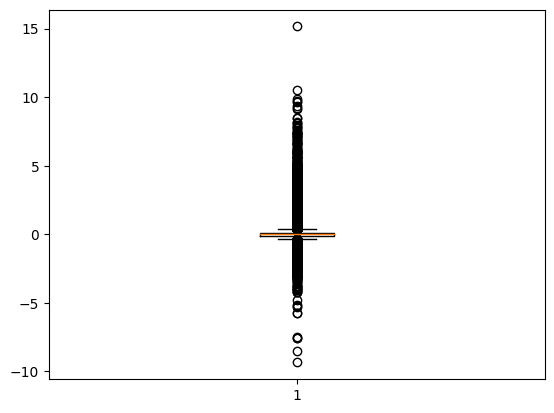




       chest_y_magnetometer data (μT)
count                   259803.000000
mean                         0.005688
std                          0.398084
min                         -9.343510
25%                         -0.092057
50%                          0.003245
75%                          0.098429
max                         15.152200
feature:  chest_z_magnetometer data (μT)


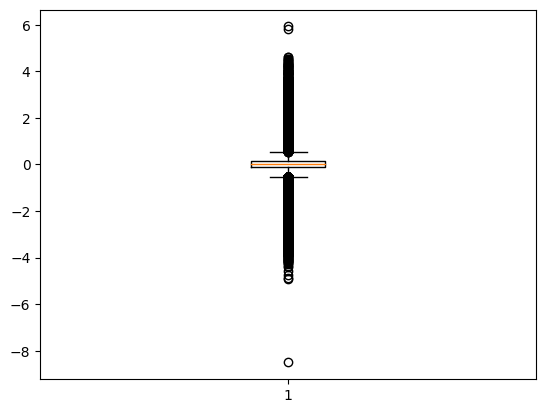




       chest_z_magnetometer data (μT)
count                   259803.000000
mean                         0.008133
std                          0.539031
min                         -8.499900
25%                         -0.125937
50%                          0.000012
75%                          0.147044
max                          5.923320
feature:  ankle_temperature (°C)


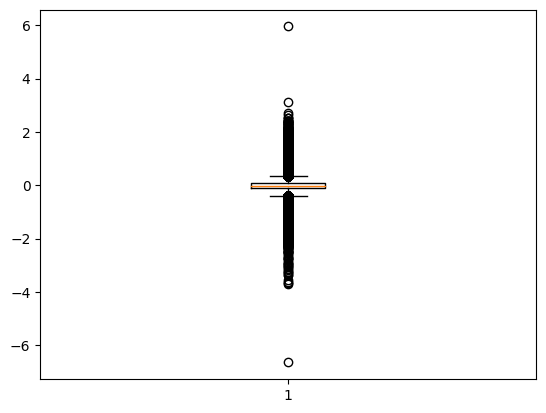




       ankle_temperature (°C)
count           259803.000000
mean                -0.021312
std                  0.291768
min                 -6.640760
25%                 -0.112283
50%                 -0.016381
75%                  0.070927
max                  5.954330
feature:  ankle_x_acceleration (ms-2) scale: ±16g


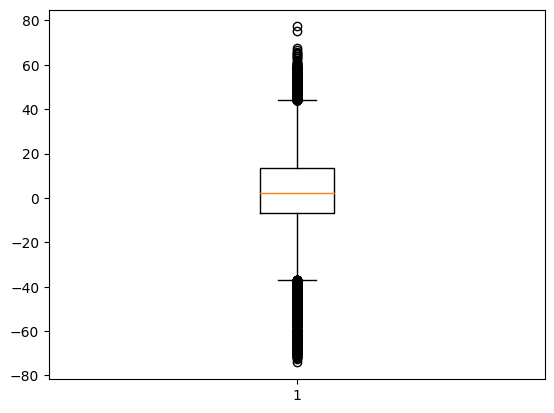




       ankle_x_acceleration (ms-2) scale: ±16g
count                            259803.000000
mean                                  3.609813
std                                  16.466561
min                                 -74.147200
25%                                  -6.748465
50%                                   2.268050
75%                                  13.532250
max                                  77.300300
feature:  ankle_y_acceleration (ms-2) scale: ±16g


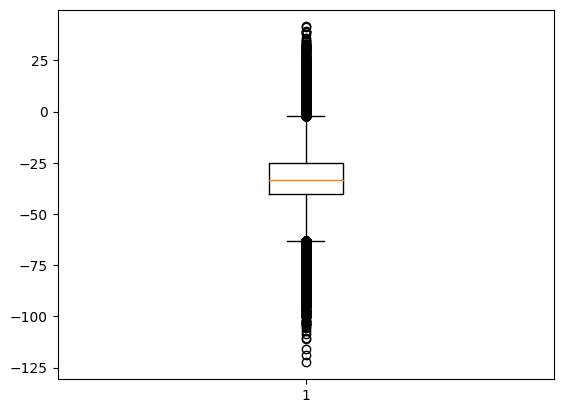




       ankle_y_acceleration (ms-2) scale: ±16g
count                            259803.000000
mean                                -31.817371
std                                  16.143496
min                                -122.480000
25%                                 -40.189950
50%                                 -33.468200
75%                                 -24.952600
max                                  41.565400
feature:  ankle_z_acceleration (ms-2) scale: ±16g


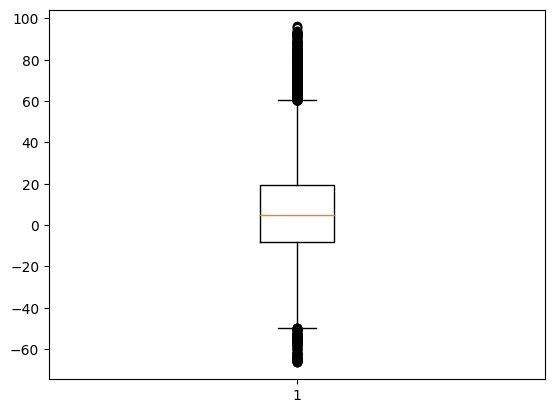




       ankle_z_acceleration (ms-2) scale: ±16g
count                            259803.000000
mean                                  5.495052
std                                  19.943562
min                                 -66.428400
25%                                  -8.335410
50%                                   5.069670
75%                                  19.229450
max                                  96.102200
feature:  ankle_x_acceleration (ms-2) scale: ±6g


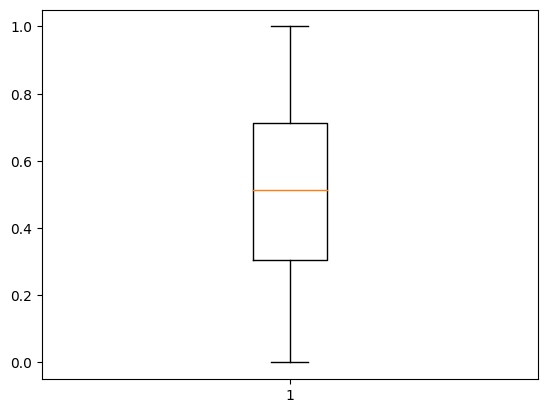




       ankle_x_acceleration (ms-2) scale: ±6g
count                           259803.000000
mean                                 0.532607
std                                  0.289807
min                                  0.000017
25%                                  0.305582
50%                                  0.512581
75%                                  0.712287
max                                  1.000000
feature:  ankle_y_acceleration (ms-2) scale: ±6g


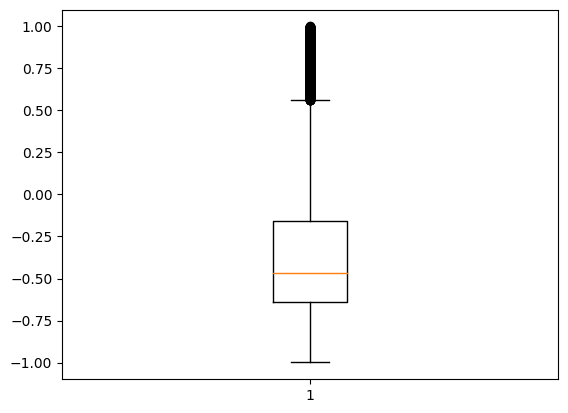




       ankle_y_acceleration (ms-2) scale: ±6g
count                           259803.000000
mean                                -0.406671
std                                  0.294856
min                                 -0.999294
25%                                 -0.640659
50%                                 -0.468319
75%                                 -0.159475
max                                  0.998773
feature:  ankle_z_acceleration (ms-2) scale: ±6g


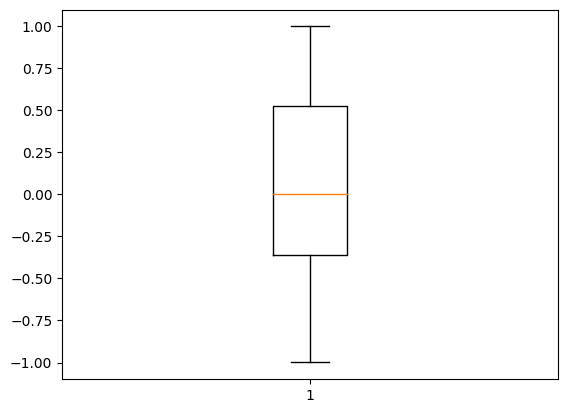




       ankle_z_acceleration (ms-2) scale: ±6g
count                           259803.000000
mean                                 0.054972
std                                  0.476136
min                                 -0.999621
25%                                 -0.358320
50%                                  0.000000
75%                                  0.521702
max                                  0.996031
feature:  ankle_x_gyroscope data (rad/s)


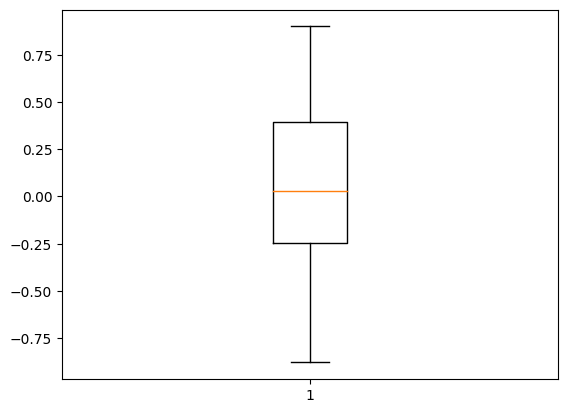




       ankle_x_gyroscope data (rad/s)
count                   259803.000000
mean                         0.048367
std                          0.384649
min                         -0.878761
25%                         -0.247869
50%                          0.027814
75%                          0.394159
max                          0.900024
feature:  ankle_y_gyroscope data (rad/s)


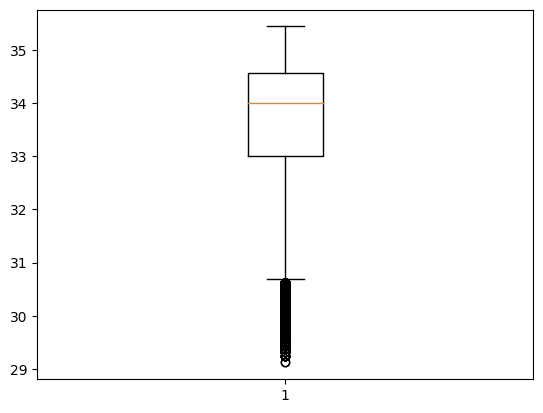




       ankle_y_gyroscope data (rad/s)
count                   259803.000000
mean                        33.687459
std                          1.183771
min                         29.125000
25%                         33.000000
50%                         34.000000
75%                         34.562500
max                         35.437500
feature:  ankle_z_gyroscope data (rad/s)


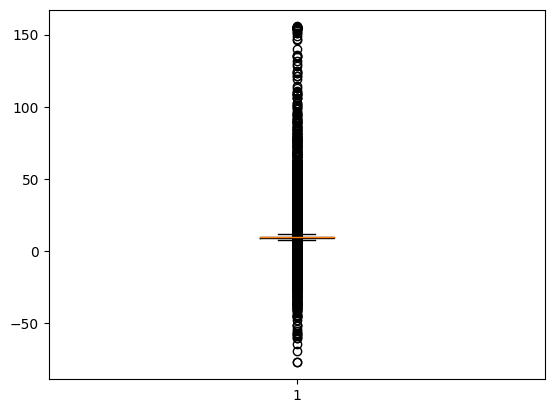




       ankle_z_gyroscope data (rad/s)
count                   259803.000000
mean                         9.527137
std                          5.797091
min                        -77.324900
25%                          9.025780
50%                          9.570960
75%                          9.995700
max                        155.655000
feature:  ankle_x_magnetometer data (μT)


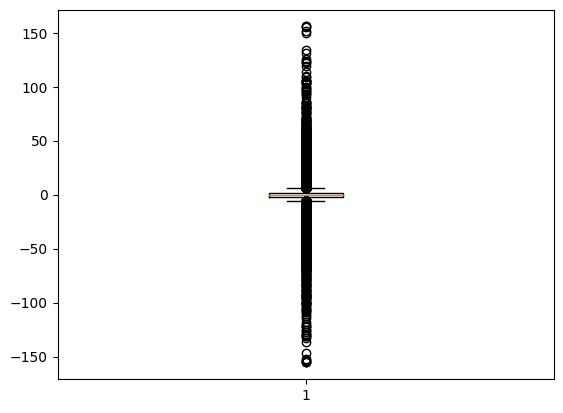




       ankle_x_magnetometer data (μT)
count                   259803.000000
mean                        -0.128176
std                          6.814865
min                       -155.513000
25%                         -1.759470
50%                         -0.271777
75%                          1.263620
max                        155.799000
feature:  ankle_y_magnetometer data (μT)


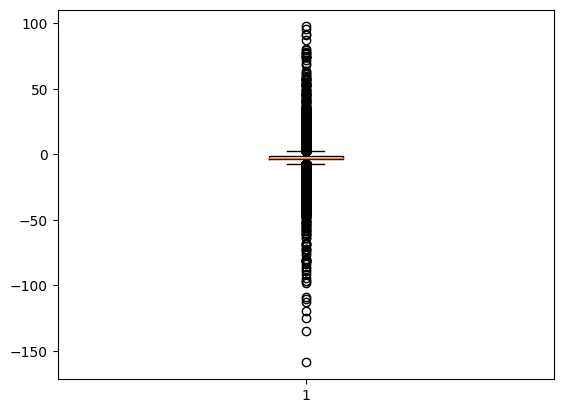




       ankle_y_magnetometer data (μT)
count                   259803.000000
mean                        -2.463972
std                          3.587473
min                       -158.830000
25%                         -3.642550
50%                         -2.358300
75%                         -1.059695
max                         97.672100
feature:  ankle_z_magnetometer data (μT)


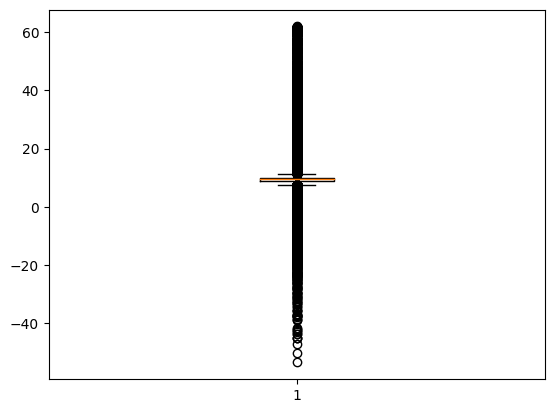




       ankle_z_magnetometer data (μT)
count                   259803.000000
mean                         9.505924
std                          5.364949
min                        -53.405700
25%                          9.000800
50%                          9.583560
75%                          9.983225
max                         61.922600
   Getting train-test datasets   
Assembly
Train-test splitting
Assembly-normalise train
Assembly-normalise test
Train schema: 
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)

Test schema: 
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
train,test = rows_with_NaNs_dropping(dfs_nts, False)

##### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

##### Testing

In [ ]:
testing(test,train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_aeb5232d402b
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_5fa645ae69c1
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|

### Values prediction

The data is in the form of a time-series and it is possible to notice from the non NaN value that the values are smoothly increasing and decreasing.

In [ ]:
for df in dfs:
    for value in df.select("heart_rate").filter(isnan(col("heart_rate")) == False).collect():
        print(value)

It is like there is this time-series and the measurament of the heart_rate is done at time intervals, like a sampling and this sampling is performed less frequently rather than the other measuraments. Usually, in these cases, it is assumed that nothing extreme happens in the middle and a linear interpolation or nearest neighbour is performed

#### Non-normalised [Nearest-neighbour]

   DataFrames union   
   Subject_id_0   


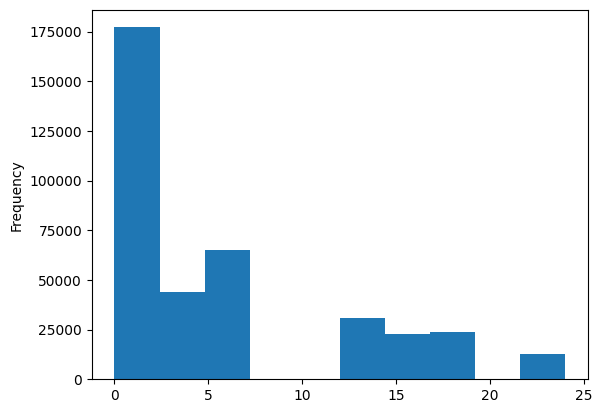

   Subject_id_1   


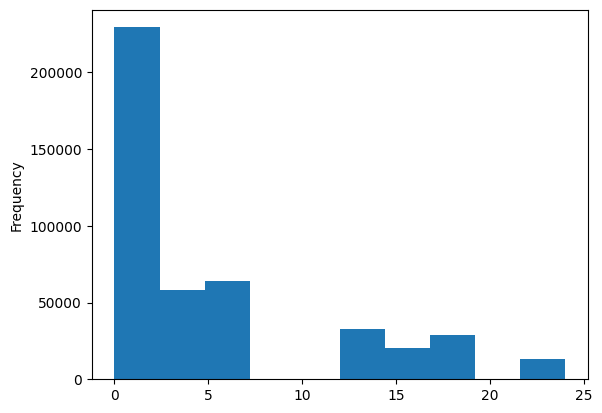

   Subject_id_2   


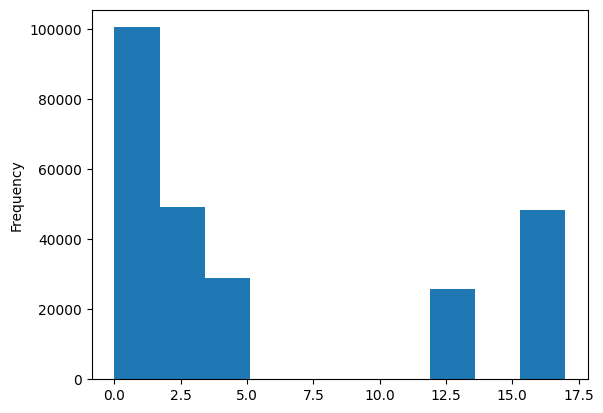

   Subject_id_3   


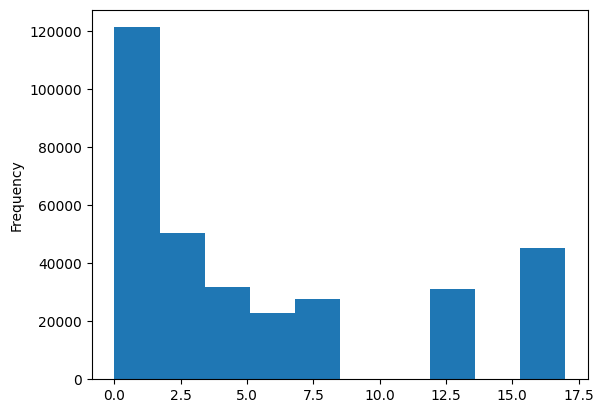

   Subject_id_4   


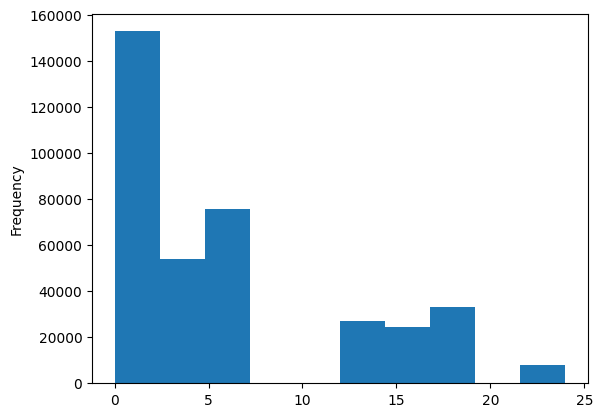

   Subject_id_5   


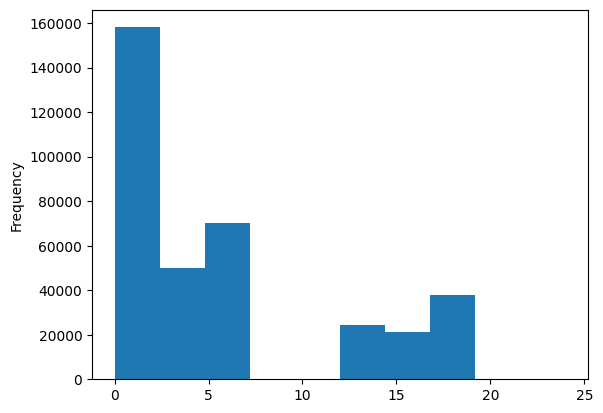

   Subject_id_6   


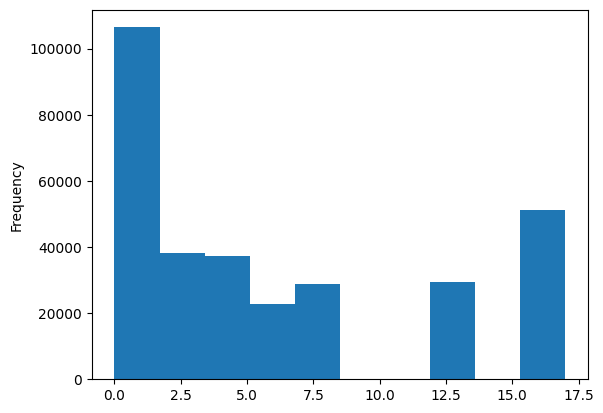

   Subject_id_7   


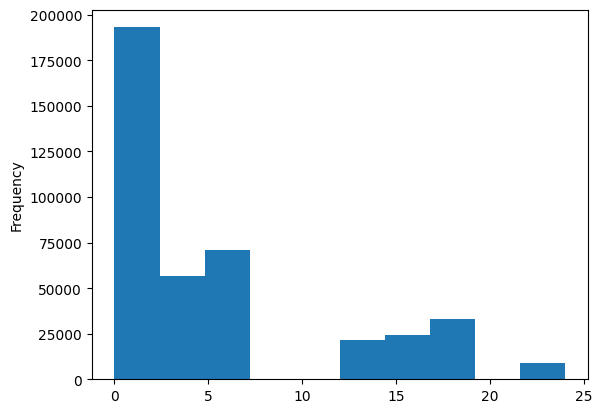

   Subject_id_8   


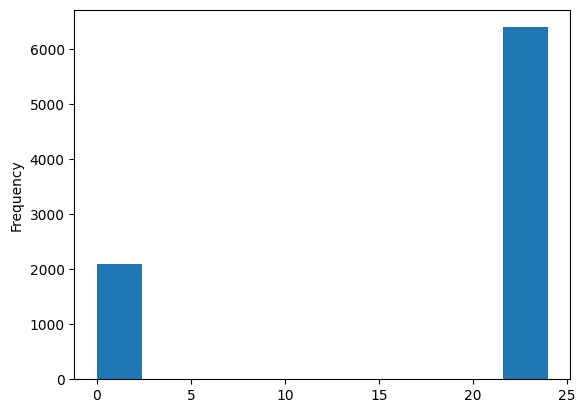

   Rows reduction checking   
Before dropping rows with NaNs: 
number of rows:  2791472
After dropping rows with NaNs: 
number of rows:  2764560


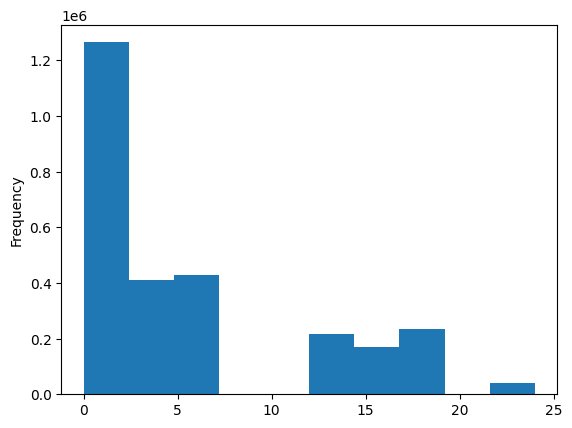

   Data description   
['activity_id', 'hand_temperature (°C)', 'hand_x_acceleration (ms-2) scale: ±16g', 'hand_y_acceleration (ms-2) scale: ±16g', 'hand_z_acceleration (ms-2) scale: ±16g', 'hand_x_acceleration (ms-2) scale: ±6g', 'hand_y_acceleration (ms-2) scale: ±6g', 'hand_z_acceleration (ms-2) scale: ±6g', 'hand_x_gyroscope data (rad/s)', 'hand_y_gyroscope data (rad/s)', 'hand_z_gyroscope data (rad/s)', 'hand_x_magnetometer data (μT)', 'hand_y_magnetometer data (μT)', 'hand_z_magnetometer data (μT)', 'chest_temperature (°C)', 'chest_x_acceleration (ms-2) scale: ±16g', 'chest_y_acceleration (ms-2) scale: ±16g', 'chest_z_acceleration (ms-2) scale: ±16g', 'chest_x_acceleration (ms-2) scale: ±6g', 'chest_y_acceleration (ms-2) scale: ±6g', 'chest_z_acceleration (ms-2) scale: ±6g', 'chest_x_gyroscope data (rad/s)', 'chest_y_gyroscope data (rad/s)', 'chest_z_gyroscope data (rad/s)', 'chest_x_magnetometer data (μT)', 'chest_y_magnetometer data (μT)', 'chest_z_magnetometer data (μT)', 'ank

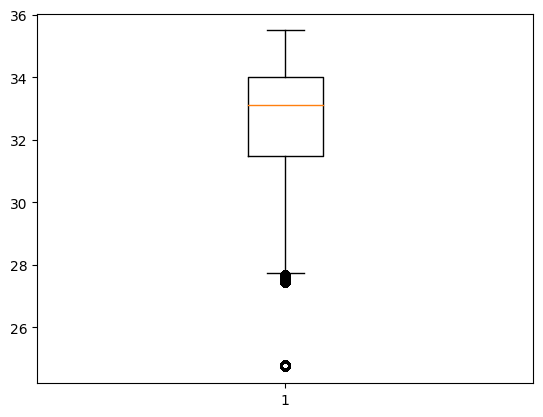




       hand_temperature (°C)
count           2.764560e+06
mean            3.268527e+01
std             1.799058e+00
min             2.475000e+01
25%             3.150000e+01
50%             3.312500e+01
75%             3.400000e+01
max             3.550000e+01
feature:  hand_x_acceleration (ms-2) scale: ±16g


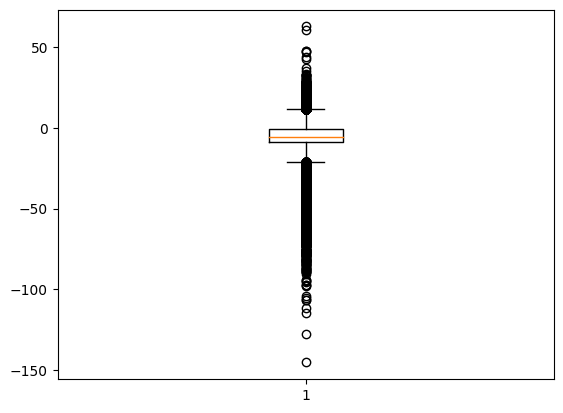




       hand_x_acceleration (ms-2) scale: ±16g
count                            2.764560e+06
mean                            -4.967707e+00
std                              5.980077e+00
min                             -1.453670e+02
25%                             -9.032180e+00
50%                             -5.799250e+00
75%                             -7.883710e-01
max                              6.285960e+01
feature:  hand_y_acceleration (ms-2) scale: ±16g


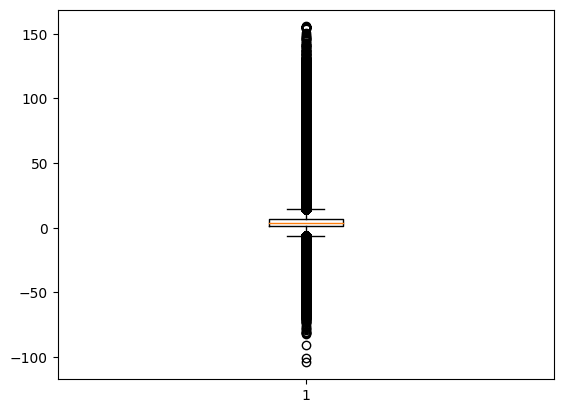




       hand_y_acceleration (ms-2) scale: ±16g
count                            2.764560e+06
mean                             3.572707e+00
std                              6.235315e+00
min                             -1.043010e+02
25%                              1.298580e+00
50%                              3.570990e+00
75%                              6.599440e+00
max                              1.556990e+02
feature:  hand_z_acceleration (ms-2) scale: ±16g


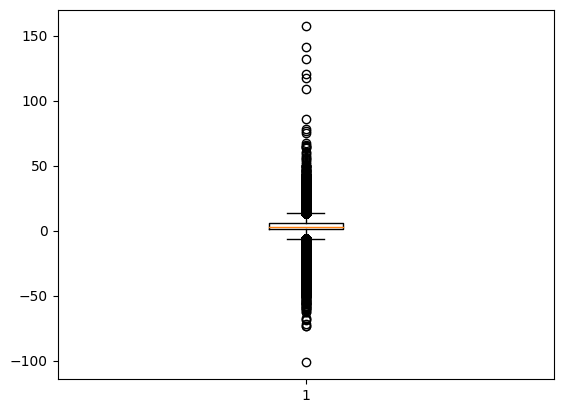




       hand_z_acceleration (ms-2) scale: ±16g
count                            2.764560e+06
mean                             3.180870e+00
std                              3.827906e+00
min                             -1.014520e+02
25%                              9.769498e-01
50%                              2.963445e+00
75%                              6.011107e+00
max                              1.569490e+02
feature:  hand_x_acceleration (ms-2) scale: ±6g


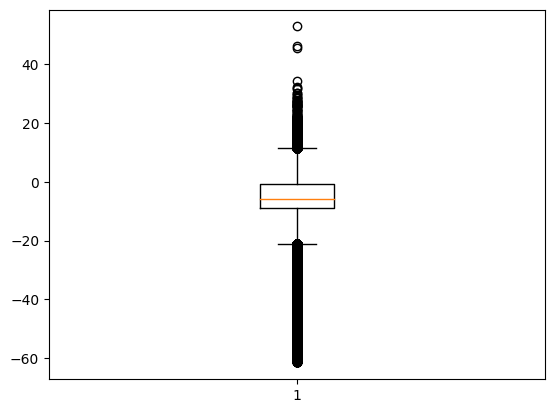




       hand_x_acceleration (ms-2) scale: ±6g
count                           2.764560e+06
mean                           -4.895294e+00
std                             5.987766e+00
min                            -6.148950e+01
25%                            -8.935893e+00
50%                            -5.747670e+00
75%                            -7.296260e-01
max                             5.282140e+01
feature:  hand_y_acceleration (ms-2) scale: ±6g


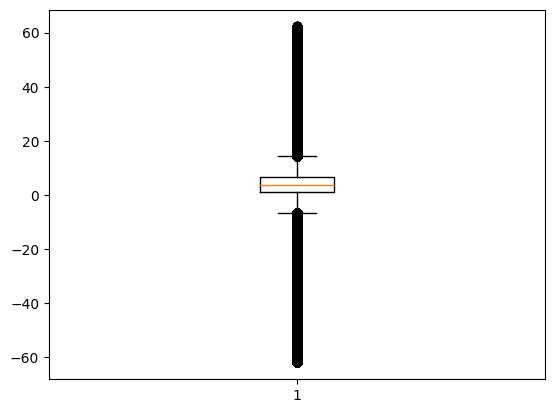




       hand_y_acceleration (ms-2) scale: ±6g
count                           2.764560e+06
mean                            3.569105e+00
std                             6.014209e+00
min                            -6.186800e+01
25%                             1.292178e+00
50%                             3.613480e+00
75%                             6.598380e+00
max                             6.225980e+01
feature:  hand_z_acceleration (ms-2) scale: ±6g


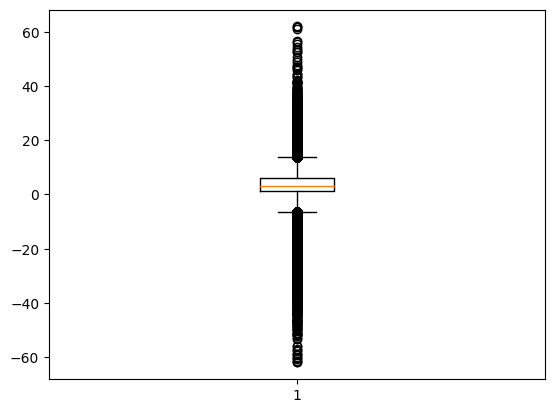




       hand_z_acceleration (ms-2) scale: ±6g
count                           2.764560e+06
mean                            3.363231e+00
std                             3.824965e+00
min                            -6.193470e+01
25%                             1.175920e+00
50%                             3.137860e+00
75%                             6.261150e+00
max                             6.194460e+01
feature:  hand_x_gyroscope data (rad/s)


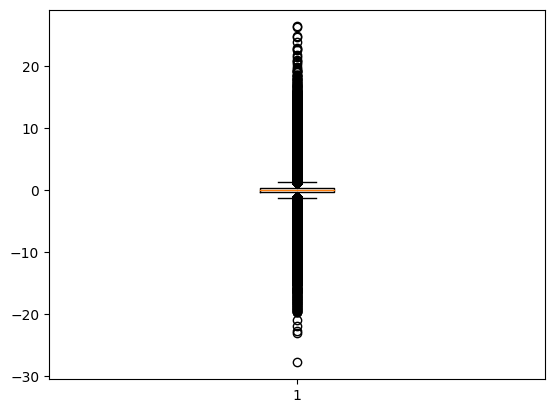




       hand_x_gyroscope data (rad/s)
count                   2.764560e+06
mean                   -4.471352e-03
std                     1.294144e+00
min                    -2.780440e+01
25%                    -3.436172e-01
50%                    -6.103725e-03
75%                     2.980563e-01
max                     2.641580e+01
feature:  hand_y_gyroscope data (rad/s)


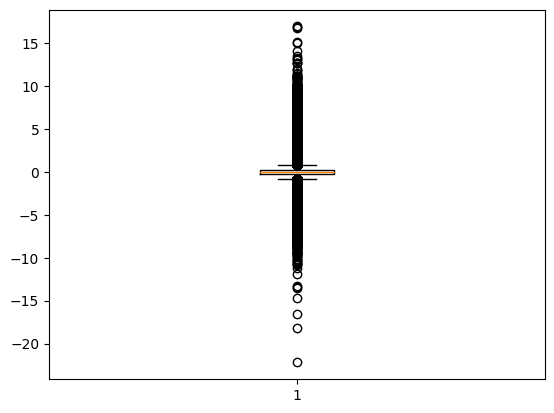




       hand_y_gyroscope data (rad/s)
count                   2.764560e+06
mean                    3.142994e-02
std                     8.798647e-01
min                    -2.221270e+01
25%                    -1.940760e-01
50%                     6.052800e-03
75%                     2.325540e-01
max                     1.698350e+01
feature:  hand_z_gyroscope data (rad/s)


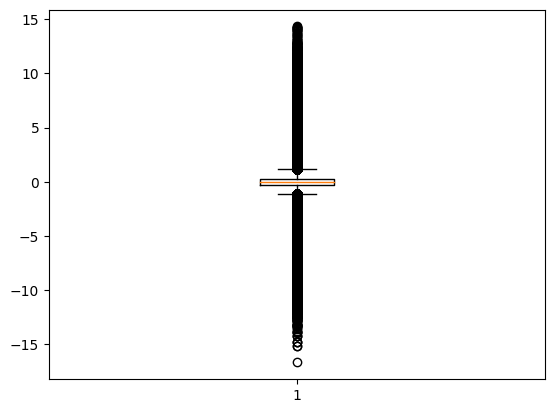




       hand_z_gyroscope data (rad/s)
count                   2.764560e+06
mean                   -7.015729e-03
std                     1.446692e+00
min                    -1.669970e+01
25%                    -2.971140e-01
50%                    -5.392590e-03
75%                     2.874130e-01
max                     1.433840e+01
feature:  hand_x_magnetometer data (μT)


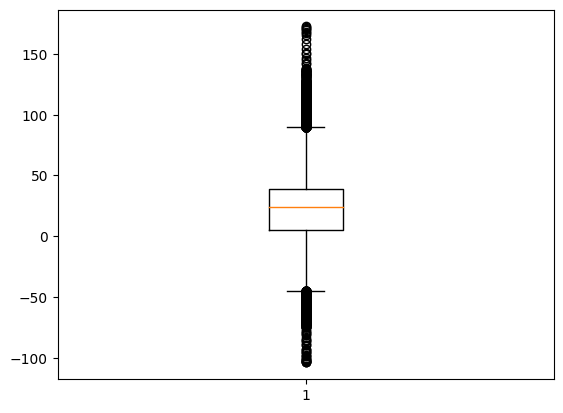




       hand_x_magnetometer data (μT)
count                   2.764560e+06
mean                    2.118536e+01
std                     2.402123e+01
min                    -1.039410e+02
25%                     5.296283e+00
50%                     2.413310e+01
75%                     3.916110e+01
max                     1.725900e+02
feature:  hand_y_magnetometer data (μT)


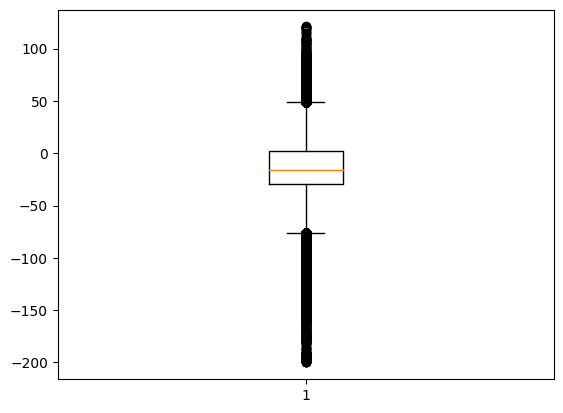




       hand_y_magnetometer data (μT)
count                   2.764560e+06
mean                   -1.434682e+01
std                     2.411807e+01
min                    -2.000430e+02
25%                    -2.949840e+01
50%                    -1.647820e+01
75%                     1.736782e+00
max                     1.211760e+02
feature:  hand_z_magnetometer data (μT)


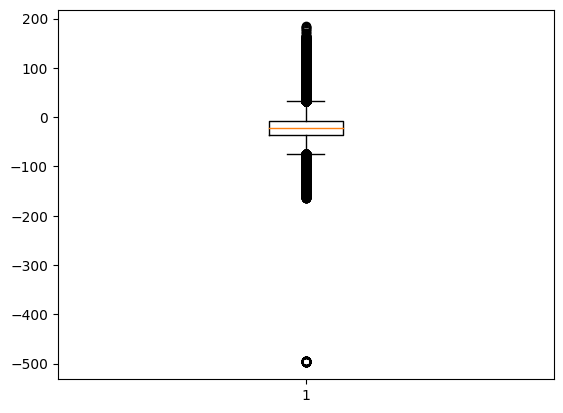




       hand_z_magnetometer data (μT)
count                   2.764560e+06
mean                   -2.164671e+01
std                     2.067739e+01
min                    -4.976320e+02
25%                    -3.532892e+01
50%                    -2.149290e+01
75%                    -8.435627e+00
max                     1.839110e+02
feature:  chest_temperature (°C)


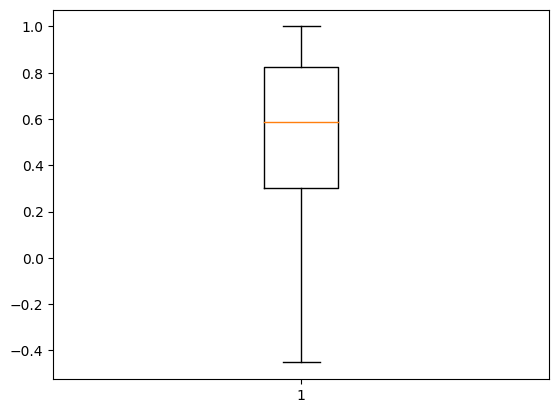




       chest_temperature (°C)
count            2.764560e+06
mean             5.669270e-01
std              3.050382e-01
min             -4.522460e-01
25%              3.016990e-01
50%              5.875755e-01
75%              8.235132e-01
max              1.000000e+00
feature:  chest_x_acceleration (ms-2) scale: ±16g


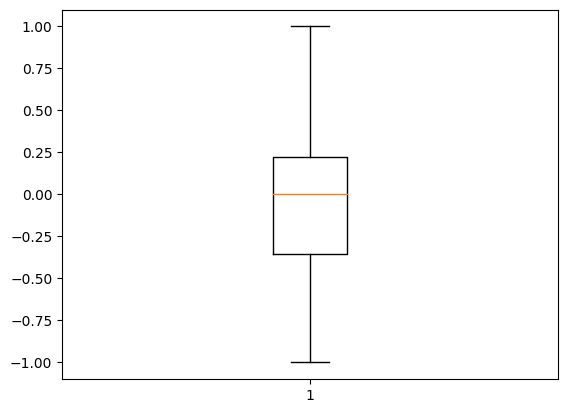




       chest_x_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -5.467422e-02
std                               3.773901e-01
min                              -9.999960e-01
25%                              -3.526110e-01
50%                               0.000000e+00
75%                               2.218200e-01
max                               9.999430e-01
feature:  chest_y_acceleration (ms-2) scale: ±16g


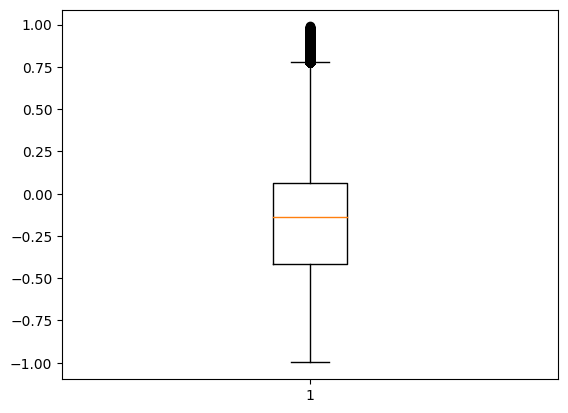




       chest_y_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -1.398759e-01
std                               3.341640e-01
min                              -9.982610e-01
25%                              -4.140570e-01
50%                              -1.380550e-01
75%                               6.301770e-02
max                               9.888270e-01
feature:  chest_z_acceleration (ms-2) scale: ±16g


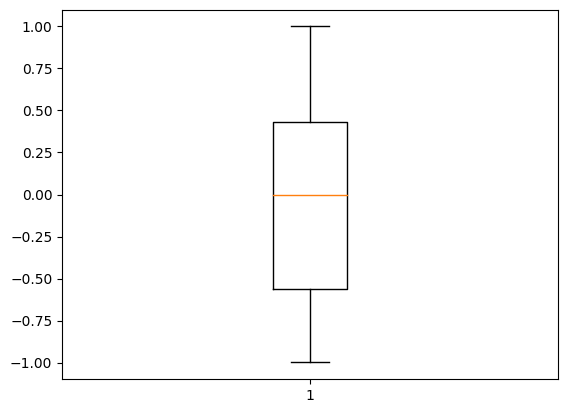




       chest_z_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -3.399915e-02
std                               5.547489e-01
min                              -9.993260e-01
25%                              -5.628243e-01
50%                               0.000000e+00
75%                               4.308460e-01
max                               9.996770e-01
feature:  chest_x_acceleration (ms-2) scale: ±6g


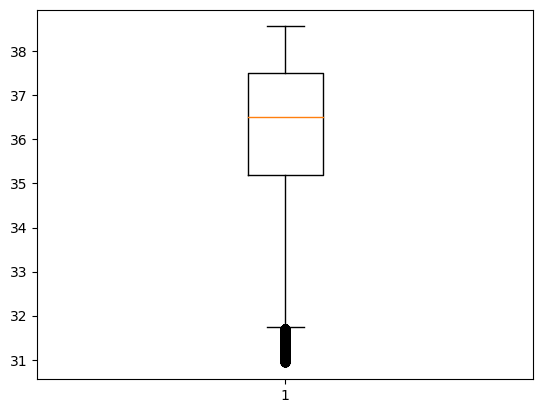




       chest_x_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             3.616458e+01
std                              1.572483e+00
min                              3.093750e+01
25%                              3.518750e+01
50%                              3.650000e+01
75%                              3.750000e+01
max                              3.856250e+01
feature:  chest_y_acceleration (ms-2) scale: ±6g


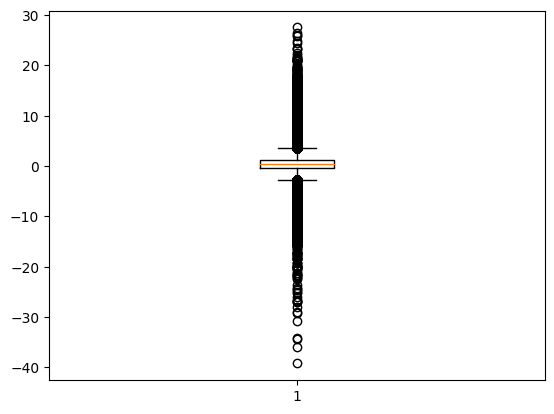




       chest_y_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             3.785917e-01
std                              1.612729e+00
min                             -3.920340e+01
25%                             -4.145040e-01
50%                              4.514290e-01
75%                              1.155060e+00
max                              2.752230e+01
feature:  chest_z_acceleration (ms-2) scale: ±6g


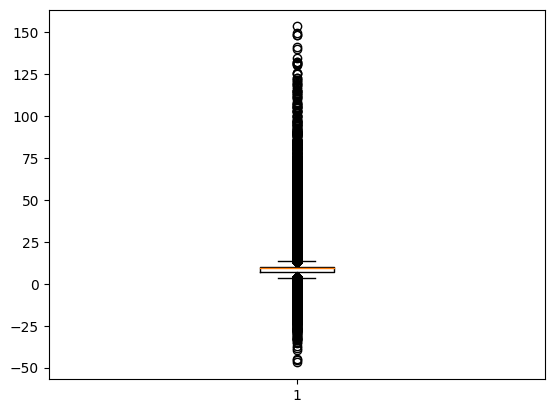




       chest_z_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             8.507493e+00
std                              4.186070e+00
min                             -4.692460e+01
25%                              7.324400e+00
50%                              9.391615e+00
75%                              9.799230e+00
max                              1.535820e+02
feature:  chest_x_gyroscope data (rad/s)


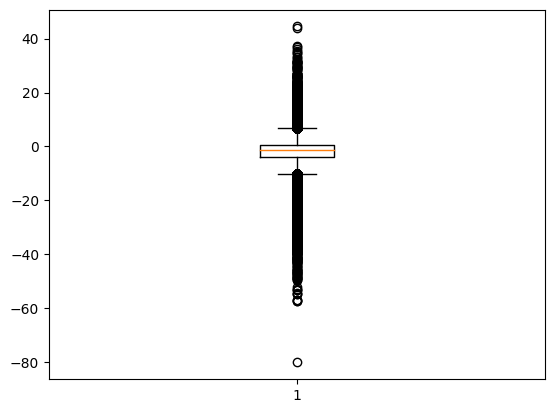




       chest_x_gyroscope data (rad/s)
count                    2.764560e+06
mean                    -1.513107e+00
std                      4.177856e+00
min                     -8.016680e+01
25%                     -3.879833e+00
50%                     -1.287040e+00
75%                      3.963720e-01
max                      4.449890e+01
feature:  chest_y_gyroscope data (rad/s)


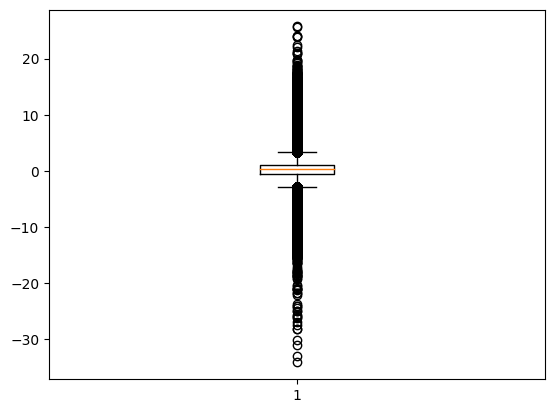




       chest_y_gyroscope data (rad/s)
count                    2.764560e+06
mean                     2.470914e-01
std                      1.611522e+00
min                     -3.420400e+01
25%                     -5.301665e-01
50%                      3.219225e-01
75%                      1.007190e+00
max                      2.573610e+01
feature:  chest_z_gyroscope data (rad/s)


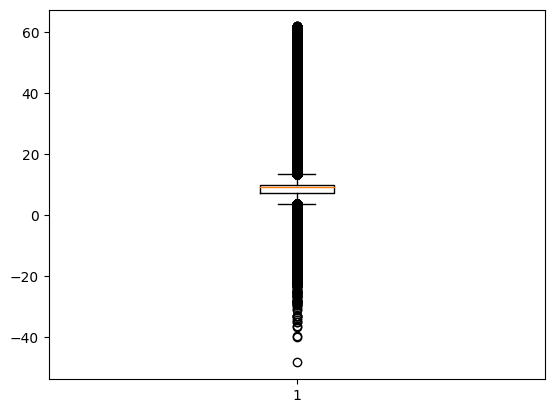




       chest_z_gyroscope data (rad/s)
count                    2.764560e+06
mean                     8.500801e+00
std                      4.154649e+00
min                     -4.825720e+01
25%                      7.309468e+00
50%                      9.355440e+00
75%                      9.811270e+00
max                      6.193730e+01
feature:  chest_x_magnetometer data (μT)


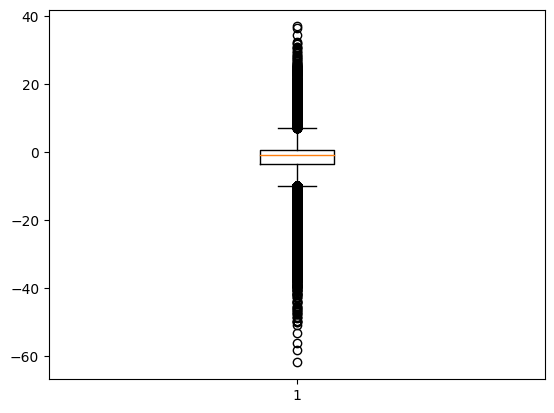




       chest_x_magnetometer data (μT)
count                    2.764560e+06
mean                    -1.177618e+00
std                      4.191271e+00
min                     -6.180410e+01
25%                     -3.563073e+00
50%                     -9.218600e-01
75%                      7.613853e-01
max                      3.696760e+01
feature:  chest_y_magnetometer data (μT)


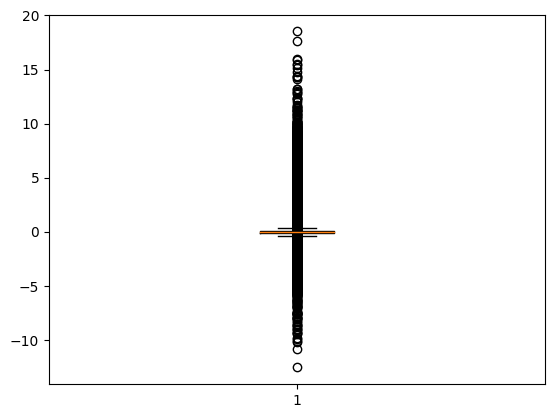




       chest_y_magnetometer data (μT)
count                    2.764560e+06
mean                     5.285176e-03
std                      3.972346e-01
min                     -1.252510e+01
25%                     -9.044355e-02
50%                      3.210540e-03
75%                      9.741375e-02
max                      1.851590e+01
feature:  chest_z_magnetometer data (μT)


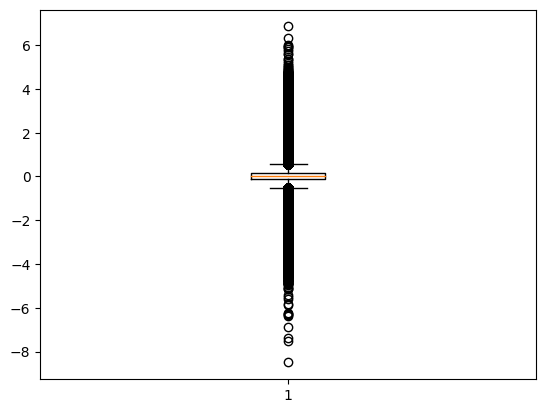




       chest_z_magnetometer data (μT)
count                    2.764560e+06
mean                     8.399839e-03
std                      5.356529e-01
min                     -8.499900e+00
25%                     -1.251002e-01
50%                     -3.447810e-06
75%                      1.448570e-01
max                      6.852570e+00
feature:  ankle_temperature (°C)


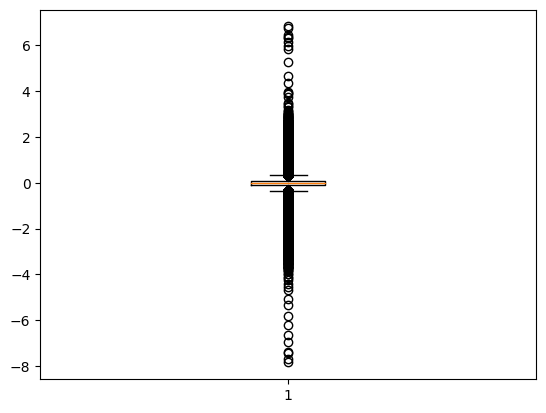




       ankle_temperature (°C)
count            2.764560e+06
mean            -2.120797e-02
std              2.897837e-01
min             -7.851890e+00
25%             -1.111320e-01
50%             -1.633315e-02
75%              6.983453e-02
max              6.824240e+00
feature:  ankle_x_acceleration (ms-2) scale: ±16g


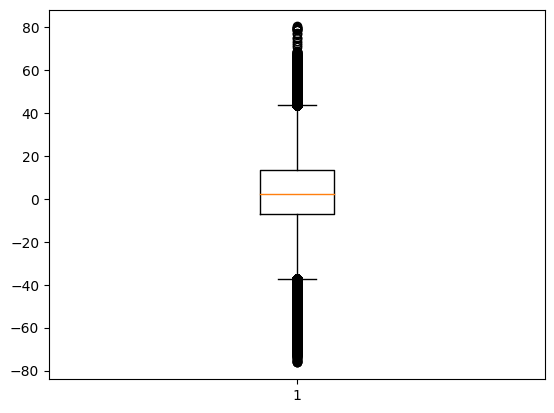




       ankle_x_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                              3.541198e+00
std                               1.649175e+01
min                              -7.624520e+01
25%                              -6.810713e+00
50%                               2.185500e+00
75%                               1.345370e+01
max                               8.047390e+01
feature:  ankle_y_acceleration (ms-2) scale: ±16g


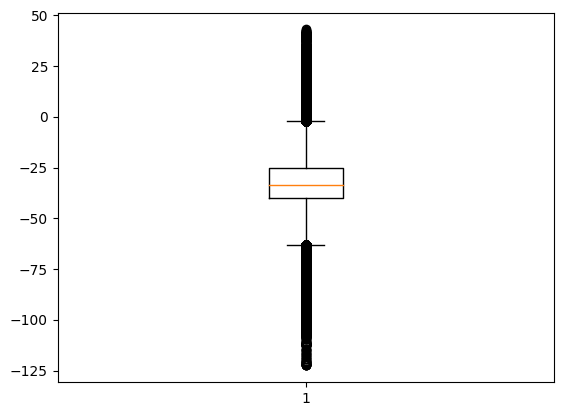




       ankle_y_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -3.180226e+01
std                               1.615753e+01
min                              -1.224800e+02
25%                              -4.019810e+01
50%                              -3.344160e+01
75%                              -2.494327e+01
max                               4.306130e+01
feature:  ankle_z_acceleration (ms-2) scale: ±16g


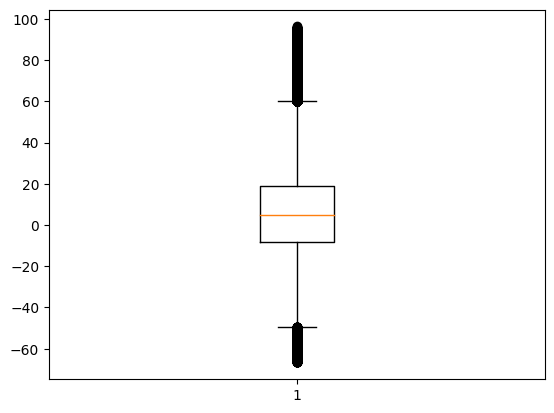




       ankle_z_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                              5.415051e+00
std                               1.995109e+01
min                              -6.668470e+01
25%                              -8.385130e+00
50%                               4.963445e+00
75%                               1.908963e+01
max                               9.635850e+01
feature:  ankle_x_acceleration (ms-2) scale: ±6g


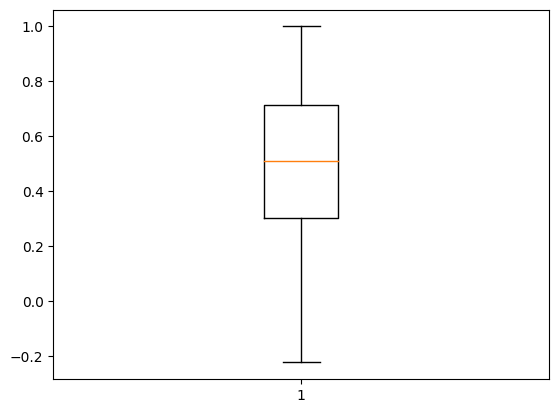




       ankle_x_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             5.320507e-01
std                              2.902368e-01
min                             -2.220890e-01
25%                              3.043260e-01
50%                              5.115265e-01
75%                              7.126200e-01
max                              1.000000e+00
feature:  ankle_y_acceleration (ms-2) scale: ±6g


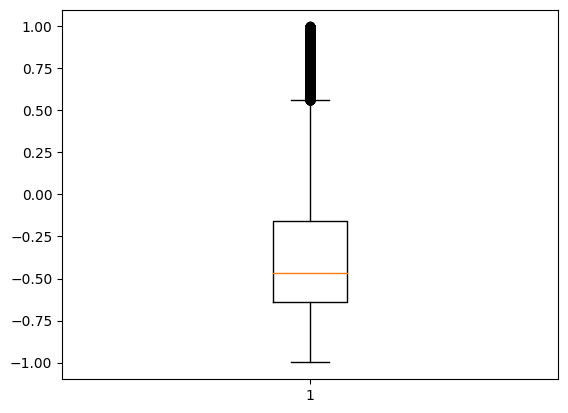




       ankle_y_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                            -4.057228e-01
std                              2.951858e-01
min                             -9.994670e-01
25%                             -6.396870e-01
50%                             -4.666680e-01
75%                             -1.587650e-01
max                              9.992700e-01
feature:  ankle_z_acceleration (ms-2) scale: ±6g


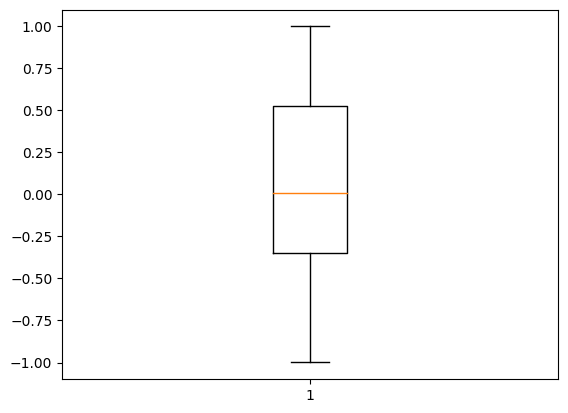




       ankle_z_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             5.871046e-02
std                              4.762474e-01
min                             -9.996350e-01
25%                             -3.520100e-01
50%                              4.842595e-03
75%                              5.257010e-01
max                              9.968640e-01
feature:  ankle_x_gyroscope data (rad/s)


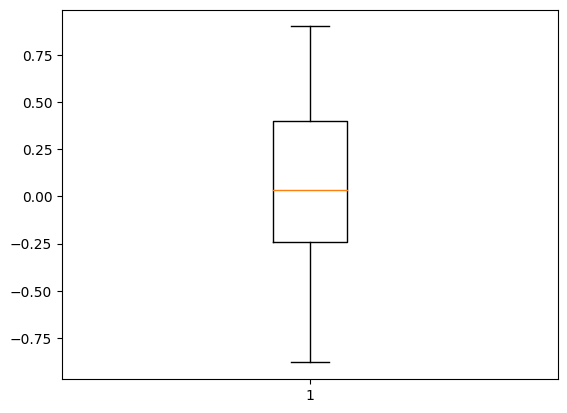




       ankle_x_gyroscope data (rad/s)
count                    2.764560e+06
mean                     5.086170e-02
std                      3.848296e-01
min                     -8.801950e-01
25%                     -2.431970e-01
50%                      3.239005e-02
75%                      3.977762e-01
max                      9.004420e-01
feature:  ankle_y_gyroscope data (rad/s)


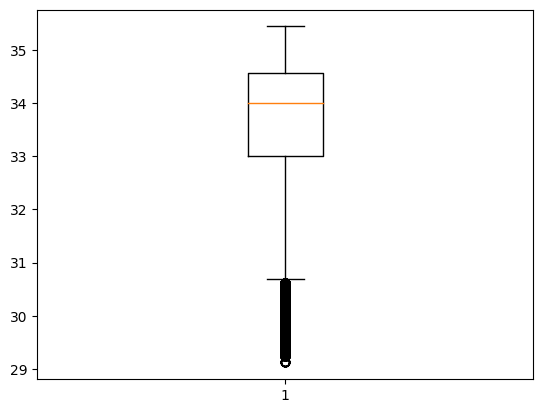




       ankle_y_gyroscope data (rad/s)
count                    2.764560e+06
mean                     3.369502e+01
std                      1.180957e+00
min                      2.912500e+01
25%                      3.300000e+01
50%                      3.400000e+01
75%                      3.456250e+01
max                      3.543750e+01
feature:  ankle_z_gyroscope data (rad/s)


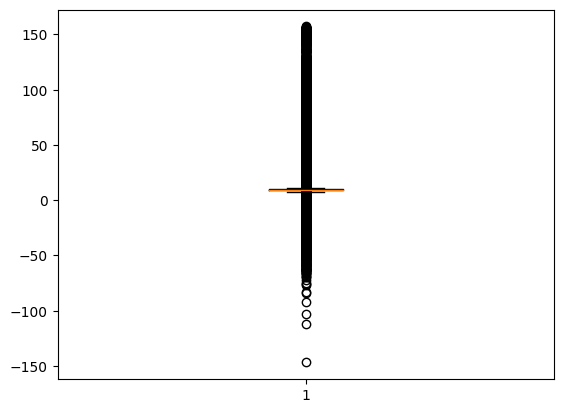




       ankle_z_gyroscope data (rad/s)
count                    2.764560e+06
mean                     9.524099e+00
std                      5.640938e+00
min                     -1.468510e+02
25%                      9.028950e+00
50%                      9.570120e+00
75%                      9.984310e+00
max                      1.572320e+02
feature:  ankle_x_magnetometer data (μT)


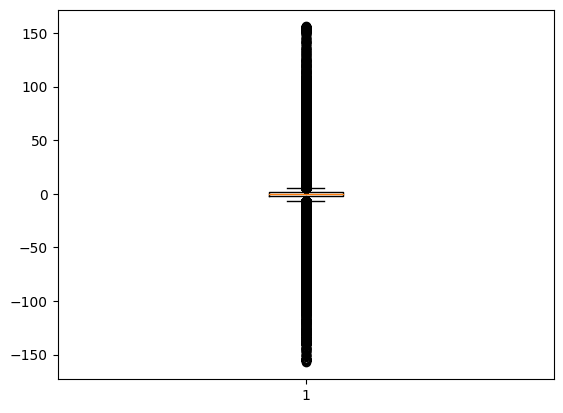




       ankle_x_magnetometer data (μT)
count                    2.764560e+06
mean                    -1.477653e-01
std                      6.763676e+00
min                     -1.574430e+02
25%                     -1.759150e+00
50%                     -2.826150e-01
75%                      1.236950e+00
max                      1.561900e+02
feature:  ankle_y_magnetometer data (μT)


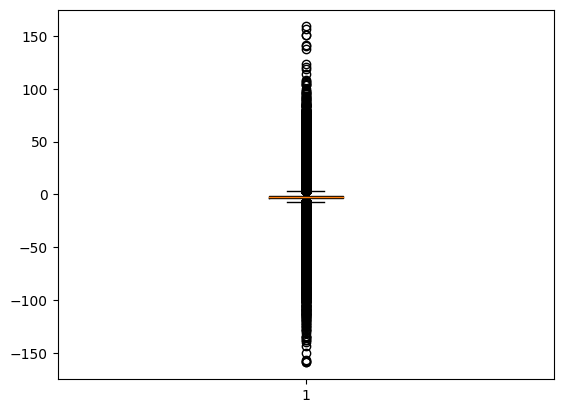




       ankle_y_magnetometer data (μT)
count                    2.764560e+06
mean                    -2.461350e+00
std                      3.500487e+00
min                     -1.589260e+02
25%                     -3.639520e+00
50%                     -2.360390e+00
75%                     -1.064180e+00
max                      1.588720e+02
feature:  ankle_z_magnetometer data (μT)


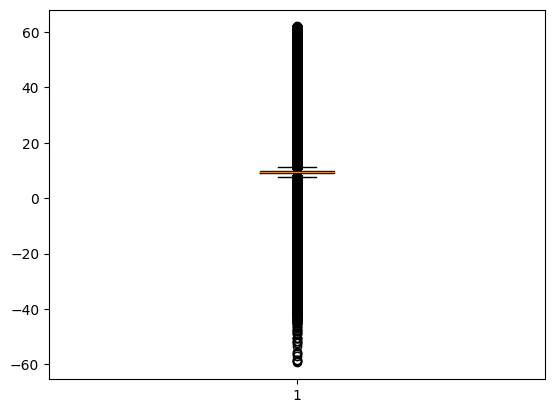




       ankle_z_magnetometer data (μT)
count                    2.764560e+06
mean                     9.501129e+00
std                      5.287274e+00
min                     -5.931200e+01
25%                      9.003530e+00
50%                      9.581700e+00
75%                      9.972360e+00
max                      6.198610e+01
feature:  heart_rate


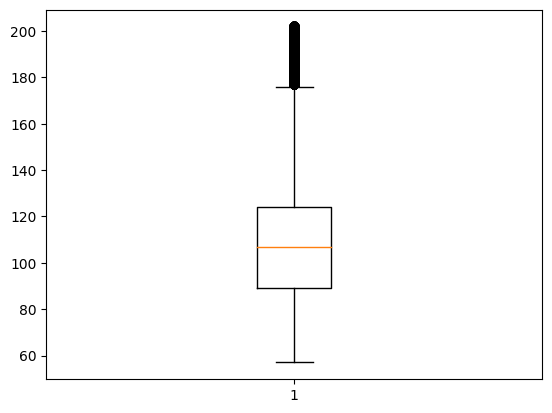




         heart_rate
count  2.764560e+06
mean   1.091075e+02
std    2.573655e+01
min    5.700000e+01
25%    8.900000e+01
50%    1.070000e+02
75%    1.240000e+02
max    2.020000e+02
   Getting train-test datasets   
Fit-transform
Train-test split
Train schema: 
root
 |-- activity_id: integer (nullable = true)
 |-- hand_temperature (°C): double (nullable = true)
 |-- hand_x_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_y_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_z_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_x_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_y_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_z_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_x_gyroscope data (rad/s): double (nullable = true)
 |-- hand_y_gyroscope data (rad/s): double (nullable = true)
 |-- hand_z_gyroscope data (rad/s): double (nullable = true)
 |-- hand_x_magnetometer data (μT):

In [ ]:
train, test = fill_values(dfs, 'heart_rate', 'nn', False)

##### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

##### Testing

In [ ]:
testing(test,train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_1f660fff87c2
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_408aae7ed228
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|

#### Normalised [Nearest-neighbour]

   DataFrames union   
   Subject_id_0   


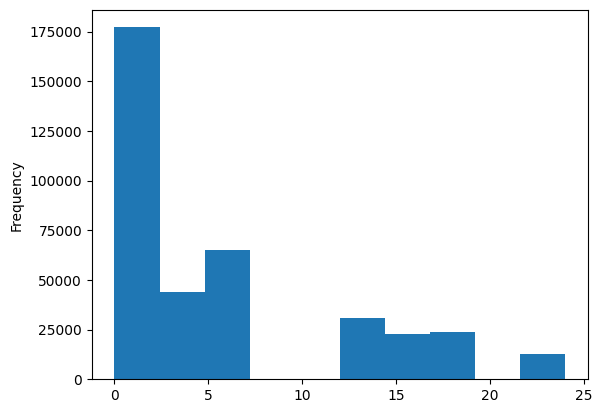

   Subject_id_1   


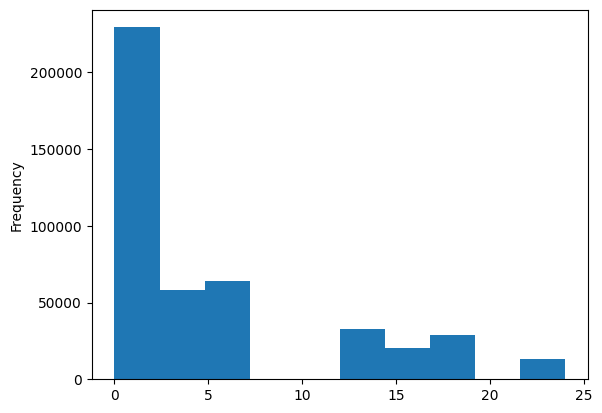

   Subject_id_2   


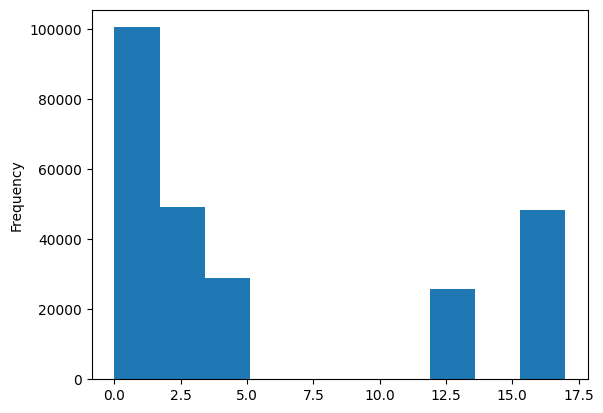

   Subject_id_3   


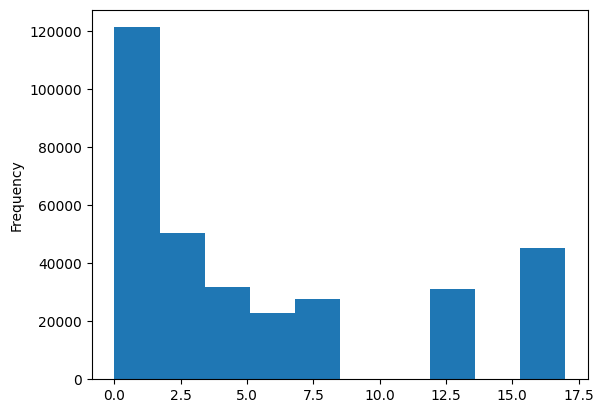

   Subject_id_4   


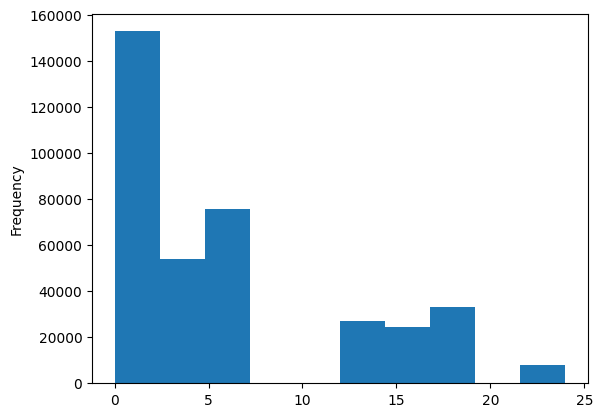

   Subject_id_5   


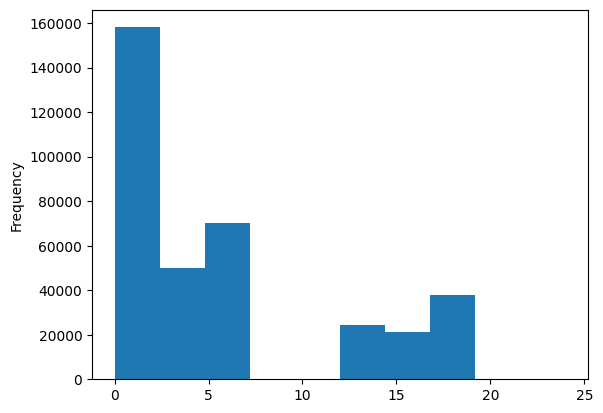

   Subject_id_6   


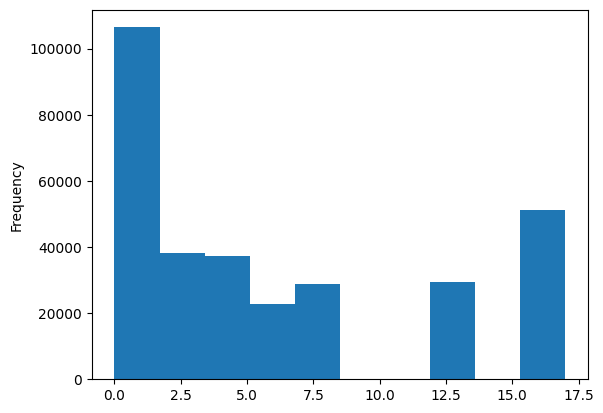

   Subject_id_7   


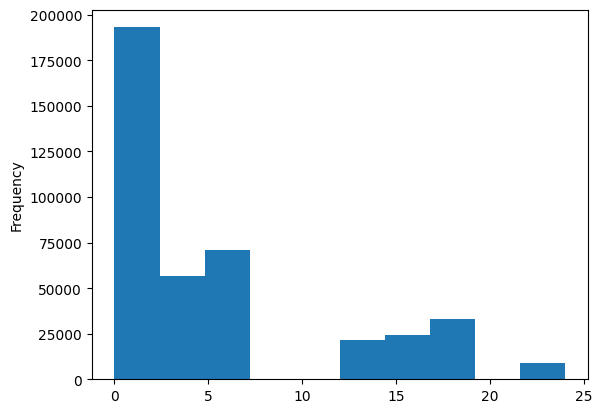

   Subject_id_8   


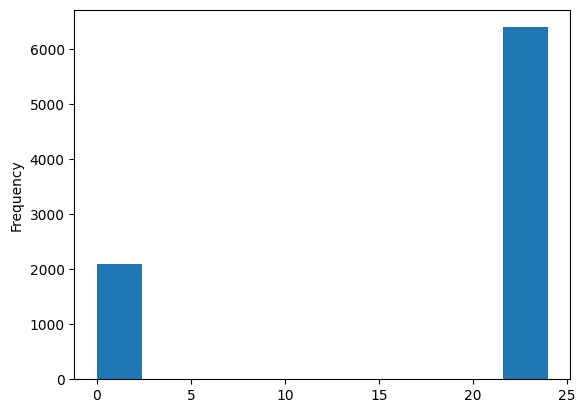

   Rows reduction checking   
Before dropping rows with NaNs: 
number of rows:  2791472
After dropping rows with NaNs: 
number of rows:  2764560


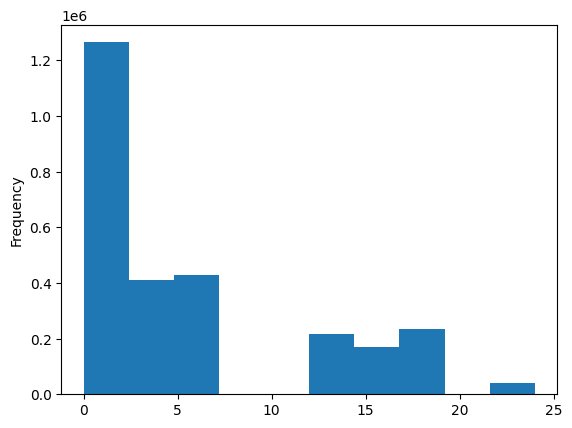

   Data description   
['activity_id', 'hand_temperature (°C)', 'hand_x_acceleration (ms-2) scale: ±16g', 'hand_y_acceleration (ms-2) scale: ±16g', 'hand_z_acceleration (ms-2) scale: ±16g', 'hand_x_acceleration (ms-2) scale: ±6g', 'hand_y_acceleration (ms-2) scale: ±6g', 'hand_z_acceleration (ms-2) scale: ±6g', 'hand_x_gyroscope data (rad/s)', 'hand_y_gyroscope data (rad/s)', 'hand_z_gyroscope data (rad/s)', 'hand_x_magnetometer data (μT)', 'hand_y_magnetometer data (μT)', 'hand_z_magnetometer data (μT)', 'chest_temperature (°C)', 'chest_x_acceleration (ms-2) scale: ±16g', 'chest_y_acceleration (ms-2) scale: ±16g', 'chest_z_acceleration (ms-2) scale: ±16g', 'chest_x_acceleration (ms-2) scale: ±6g', 'chest_y_acceleration (ms-2) scale: ±6g', 'chest_z_acceleration (ms-2) scale: ±6g', 'chest_x_gyroscope data (rad/s)', 'chest_y_gyroscope data (rad/s)', 'chest_z_gyroscope data (rad/s)', 'chest_x_magnetometer data (μT)', 'chest_y_magnetometer data (μT)', 'chest_z_magnetometer data (μT)', 'ank

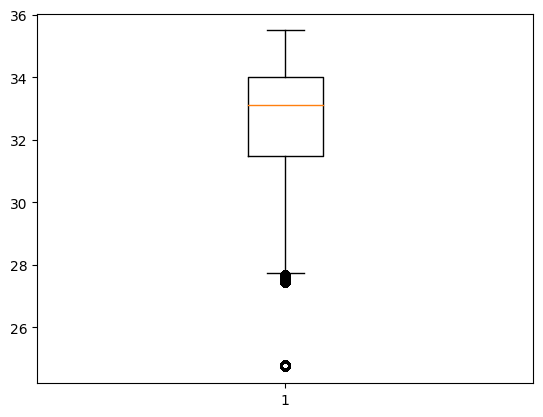




       hand_temperature (°C)
count           2.764560e+06
mean            3.268527e+01
std             1.799058e+00
min             2.475000e+01
25%             3.150000e+01
50%             3.312500e+01
75%             3.400000e+01
max             3.550000e+01
feature:  hand_x_acceleration (ms-2) scale: ±16g


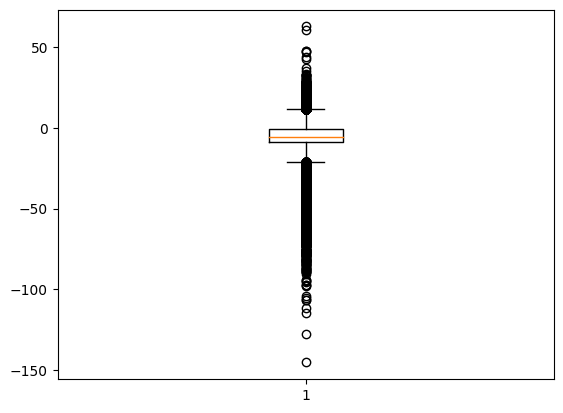




       hand_x_acceleration (ms-2) scale: ±16g
count                            2.764560e+06
mean                            -4.967707e+00
std                              5.980077e+00
min                             -1.453670e+02
25%                             -9.032180e+00
50%                             -5.799250e+00
75%                             -7.883710e-01
max                              6.285960e+01
feature:  hand_y_acceleration (ms-2) scale: ±16g


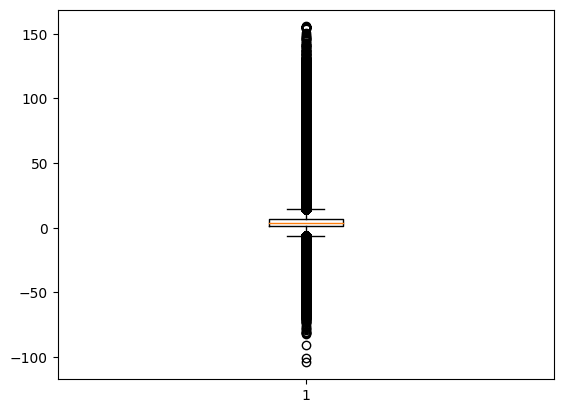




       hand_y_acceleration (ms-2) scale: ±16g
count                            2.764560e+06
mean                             3.572707e+00
std                              6.235315e+00
min                             -1.043010e+02
25%                              1.298580e+00
50%                              3.570990e+00
75%                              6.599440e+00
max                              1.556990e+02
feature:  hand_z_acceleration (ms-2) scale: ±16g


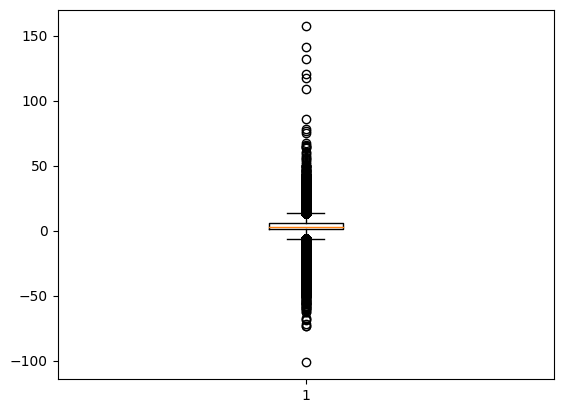




       hand_z_acceleration (ms-2) scale: ±16g
count                            2.764560e+06
mean                             3.180870e+00
std                              3.827906e+00
min                             -1.014520e+02
25%                              9.769498e-01
50%                              2.963445e+00
75%                              6.011107e+00
max                              1.569490e+02
feature:  hand_x_acceleration (ms-2) scale: ±6g


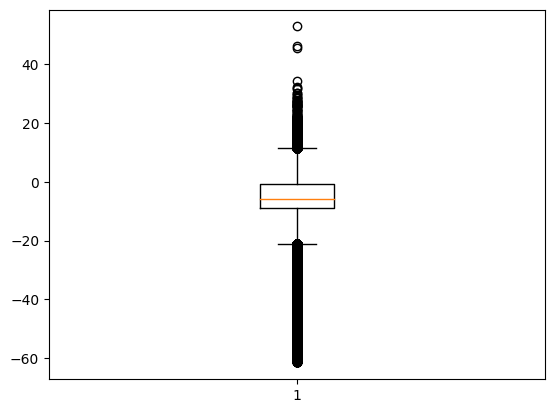




       hand_x_acceleration (ms-2) scale: ±6g
count                           2.764560e+06
mean                           -4.895294e+00
std                             5.987766e+00
min                            -6.148950e+01
25%                            -8.935893e+00
50%                            -5.747670e+00
75%                            -7.296260e-01
max                             5.282140e+01
feature:  hand_y_acceleration (ms-2) scale: ±6g


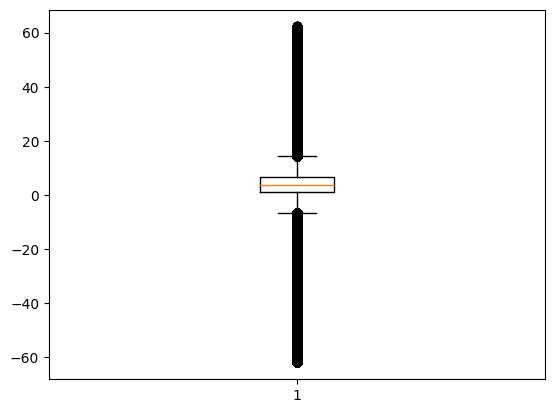




       hand_y_acceleration (ms-2) scale: ±6g
count                           2.764560e+06
mean                            3.569105e+00
std                             6.014209e+00
min                            -6.186800e+01
25%                             1.292178e+00
50%                             3.613480e+00
75%                             6.598380e+00
max                             6.225980e+01
feature:  hand_z_acceleration (ms-2) scale: ±6g


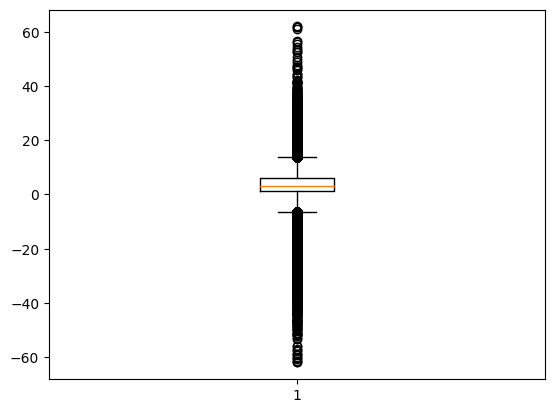




       hand_z_acceleration (ms-2) scale: ±6g
count                           2.764560e+06
mean                            3.363231e+00
std                             3.824965e+00
min                            -6.193470e+01
25%                             1.175920e+00
50%                             3.137860e+00
75%                             6.261150e+00
max                             6.194460e+01
feature:  hand_x_gyroscope data (rad/s)


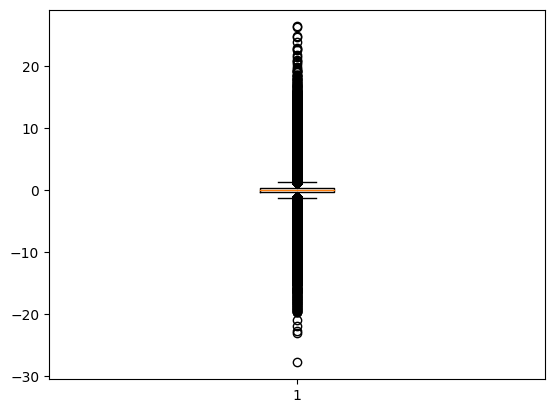




       hand_x_gyroscope data (rad/s)
count                   2.764560e+06
mean                   -4.471352e-03
std                     1.294144e+00
min                    -2.780440e+01
25%                    -3.436172e-01
50%                    -6.103725e-03
75%                     2.980563e-01
max                     2.641580e+01
feature:  hand_y_gyroscope data (rad/s)


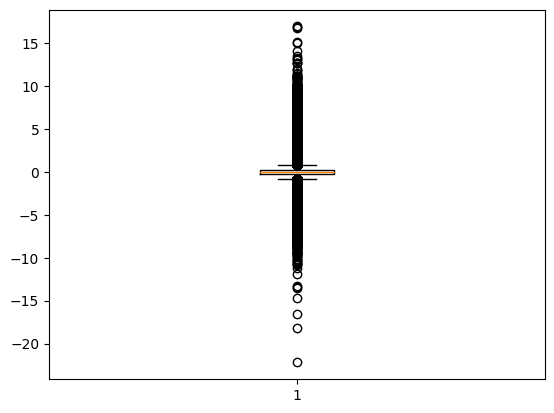




       hand_y_gyroscope data (rad/s)
count                   2.764560e+06
mean                    3.142994e-02
std                     8.798647e-01
min                    -2.221270e+01
25%                    -1.940760e-01
50%                     6.052800e-03
75%                     2.325540e-01
max                     1.698350e+01
feature:  hand_z_gyroscope data (rad/s)


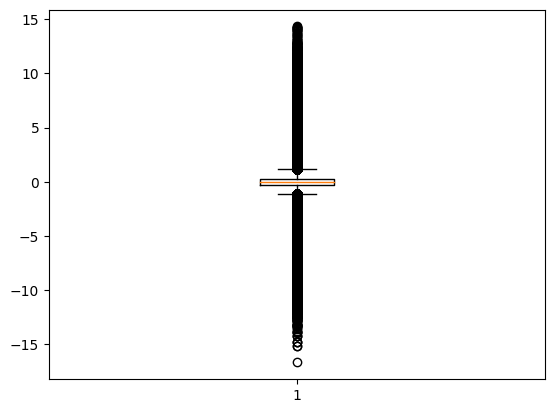




       hand_z_gyroscope data (rad/s)
count                   2.764560e+06
mean                   -7.015729e-03
std                     1.446692e+00
min                    -1.669970e+01
25%                    -2.971140e-01
50%                    -5.392590e-03
75%                     2.874130e-01
max                     1.433840e+01
feature:  hand_x_magnetometer data (μT)


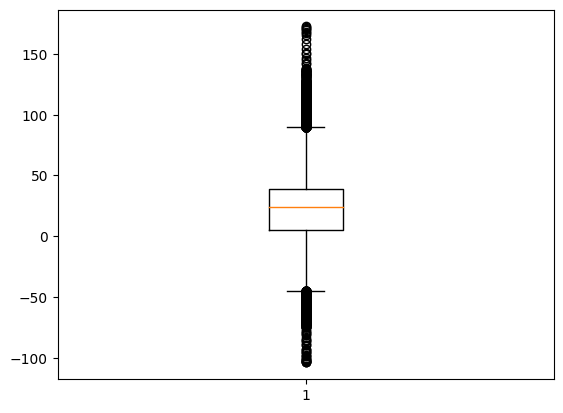




       hand_x_magnetometer data (μT)
count                   2.764560e+06
mean                    2.118536e+01
std                     2.402123e+01
min                    -1.039410e+02
25%                     5.296283e+00
50%                     2.413310e+01
75%                     3.916110e+01
max                     1.725900e+02
feature:  hand_y_magnetometer data (μT)


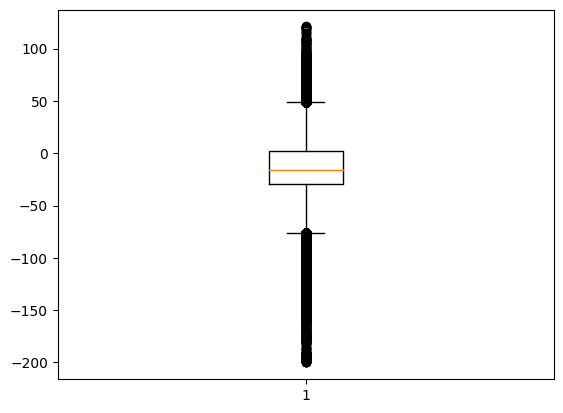




       hand_y_magnetometer data (μT)
count                   2.764560e+06
mean                   -1.434682e+01
std                     2.411807e+01
min                    -2.000430e+02
25%                    -2.949840e+01
50%                    -1.647820e+01
75%                     1.736782e+00
max                     1.211760e+02
feature:  hand_z_magnetometer data (μT)


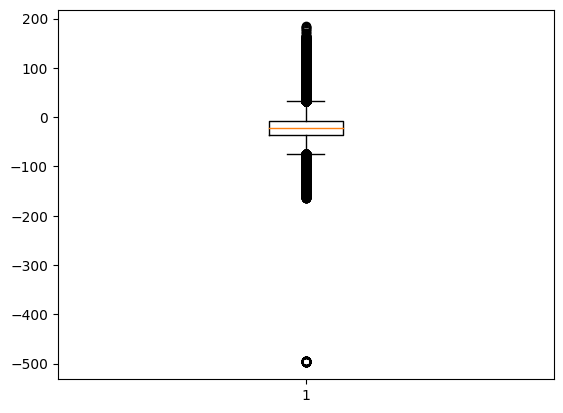




       hand_z_magnetometer data (μT)
count                   2.764560e+06
mean                   -2.164671e+01
std                     2.067739e+01
min                    -4.976320e+02
25%                    -3.532892e+01
50%                    -2.149290e+01
75%                    -8.435627e+00
max                     1.839110e+02
feature:  chest_temperature (°C)


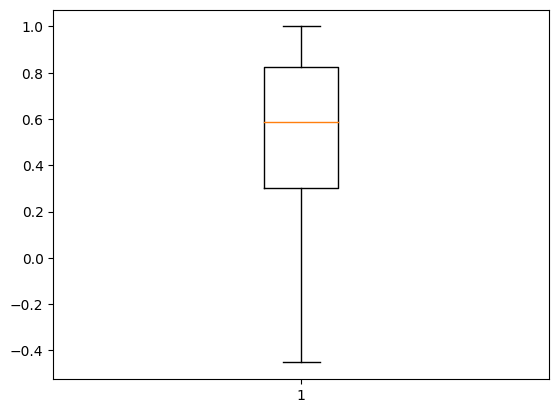




       chest_temperature (°C)
count            2.764560e+06
mean             5.669270e-01
std              3.050382e-01
min             -4.522460e-01
25%              3.016990e-01
50%              5.875755e-01
75%              8.235132e-01
max              1.000000e+00
feature:  chest_x_acceleration (ms-2) scale: ±16g


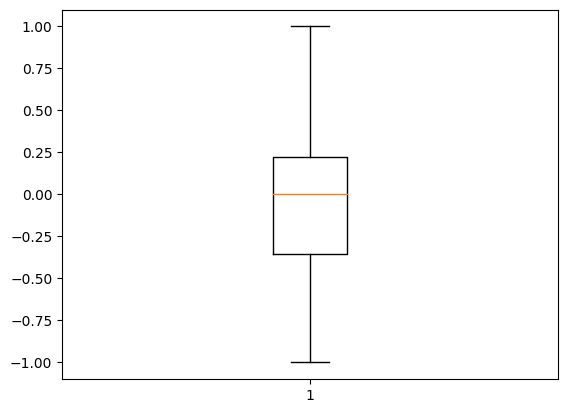




       chest_x_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -5.467422e-02
std                               3.773901e-01
min                              -9.999960e-01
25%                              -3.526110e-01
50%                               0.000000e+00
75%                               2.218200e-01
max                               9.999430e-01
feature:  chest_y_acceleration (ms-2) scale: ±16g


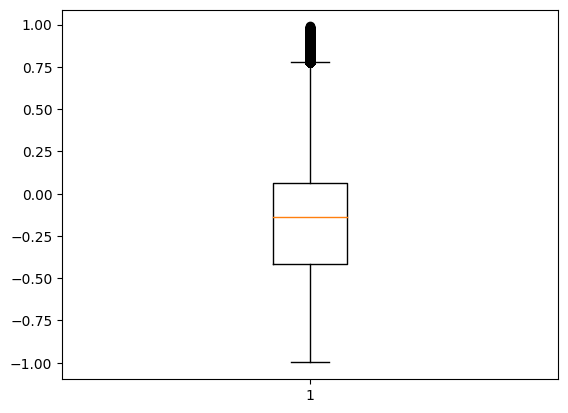




       chest_y_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -1.398759e-01
std                               3.341640e-01
min                              -9.982610e-01
25%                              -4.140570e-01
50%                              -1.380550e-01
75%                               6.301770e-02
max                               9.888270e-01
feature:  chest_z_acceleration (ms-2) scale: ±16g


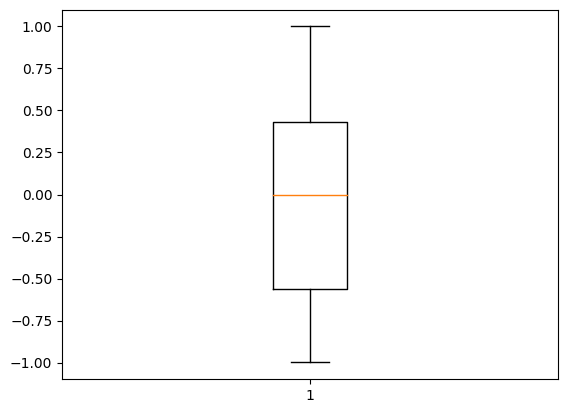




       chest_z_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -3.399915e-02
std                               5.547489e-01
min                              -9.993260e-01
25%                              -5.628243e-01
50%                               0.000000e+00
75%                               4.308460e-01
max                               9.996770e-01
feature:  chest_x_acceleration (ms-2) scale: ±6g


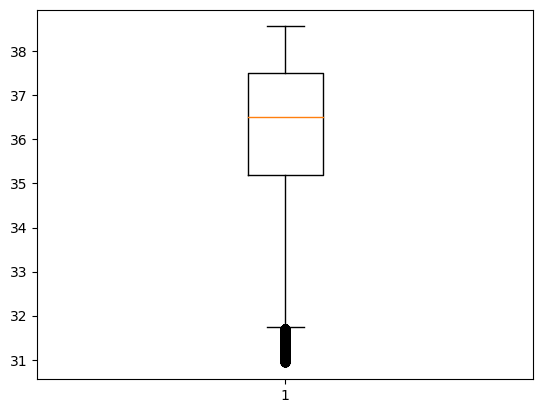




       chest_x_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             3.616458e+01
std                              1.572483e+00
min                              3.093750e+01
25%                              3.518750e+01
50%                              3.650000e+01
75%                              3.750000e+01
max                              3.856250e+01
feature:  chest_y_acceleration (ms-2) scale: ±6g


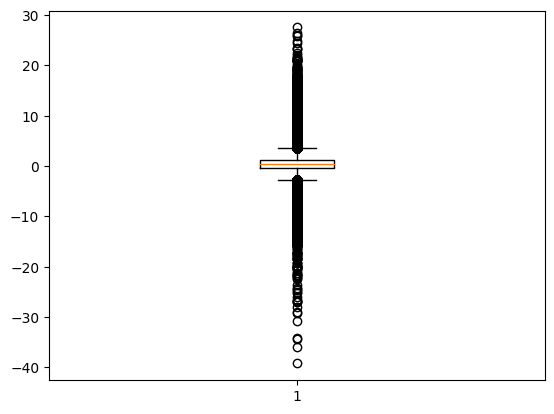




       chest_y_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             3.785917e-01
std                              1.612729e+00
min                             -3.920340e+01
25%                             -4.145040e-01
50%                              4.514290e-01
75%                              1.155060e+00
max                              2.752230e+01
feature:  chest_z_acceleration (ms-2) scale: ±6g


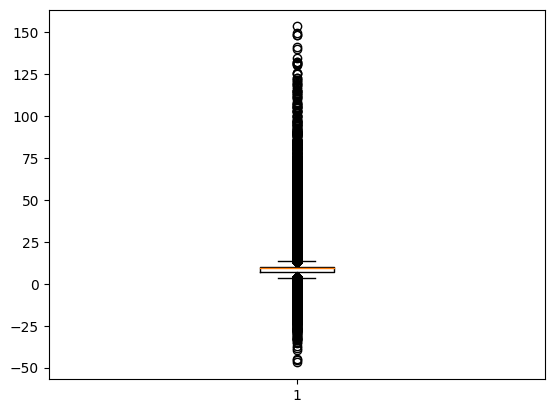




       chest_z_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             8.507493e+00
std                              4.186070e+00
min                             -4.692460e+01
25%                              7.324400e+00
50%                              9.391615e+00
75%                              9.799230e+00
max                              1.535820e+02
feature:  chest_x_gyroscope data (rad/s)


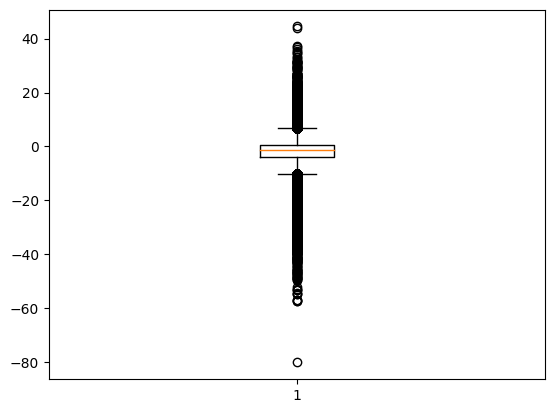




       chest_x_gyroscope data (rad/s)
count                    2.764560e+06
mean                    -1.513107e+00
std                      4.177856e+00
min                     -8.016680e+01
25%                     -3.879833e+00
50%                     -1.287040e+00
75%                      3.963720e-01
max                      4.449890e+01
feature:  chest_y_gyroscope data (rad/s)


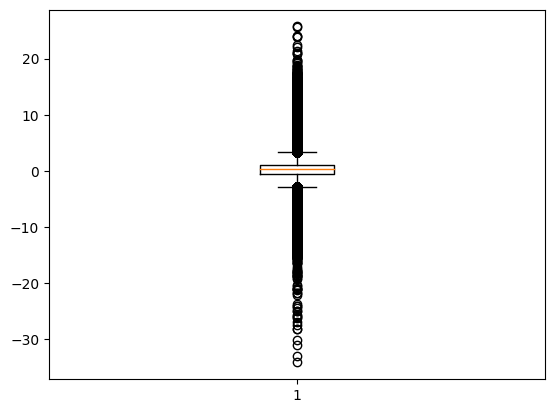




       chest_y_gyroscope data (rad/s)
count                    2.764560e+06
mean                     2.470914e-01
std                      1.611522e+00
min                     -3.420400e+01
25%                     -5.301665e-01
50%                      3.219225e-01
75%                      1.007190e+00
max                      2.573610e+01
feature:  chest_z_gyroscope data (rad/s)


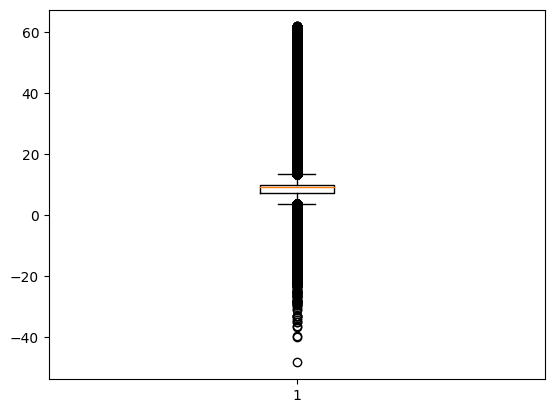




       chest_z_gyroscope data (rad/s)
count                    2.764560e+06
mean                     8.500801e+00
std                      4.154649e+00
min                     -4.825720e+01
25%                      7.309468e+00
50%                      9.355440e+00
75%                      9.811270e+00
max                      6.193730e+01
feature:  chest_x_magnetometer data (μT)


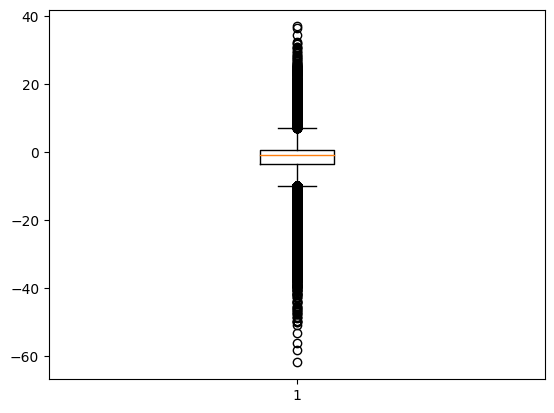




       chest_x_magnetometer data (μT)
count                    2.764560e+06
mean                    -1.177618e+00
std                      4.191271e+00
min                     -6.180410e+01
25%                     -3.563073e+00
50%                     -9.218600e-01
75%                      7.613853e-01
max                      3.696760e+01
feature:  chest_y_magnetometer data (μT)


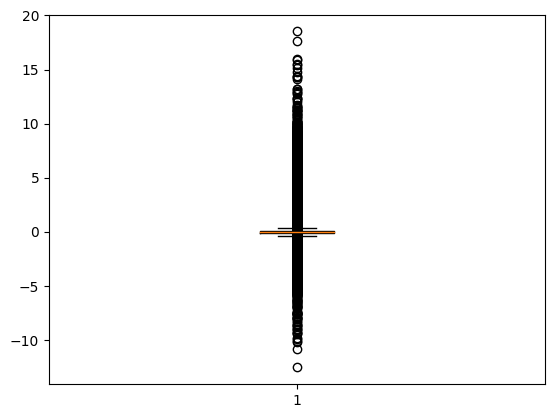




       chest_y_magnetometer data (μT)
count                    2.764560e+06
mean                     5.285176e-03
std                      3.972346e-01
min                     -1.252510e+01
25%                     -9.044355e-02
50%                      3.210540e-03
75%                      9.741375e-02
max                      1.851590e+01
feature:  chest_z_magnetometer data (μT)


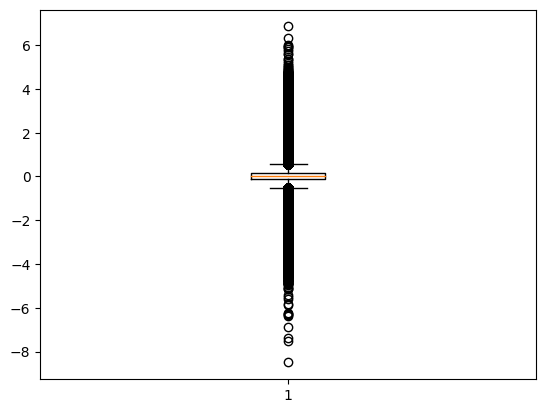




       chest_z_magnetometer data (μT)
count                    2.764560e+06
mean                     8.399839e-03
std                      5.356529e-01
min                     -8.499900e+00
25%                     -1.251002e-01
50%                     -3.447810e-06
75%                      1.448570e-01
max                      6.852570e+00
feature:  ankle_temperature (°C)


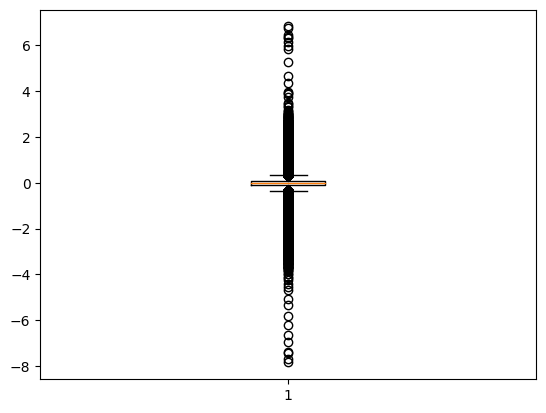




       ankle_temperature (°C)
count            2.764560e+06
mean            -2.120797e-02
std              2.897837e-01
min             -7.851890e+00
25%             -1.111320e-01
50%             -1.633315e-02
75%              6.983453e-02
max              6.824240e+00
feature:  ankle_x_acceleration (ms-2) scale: ±16g


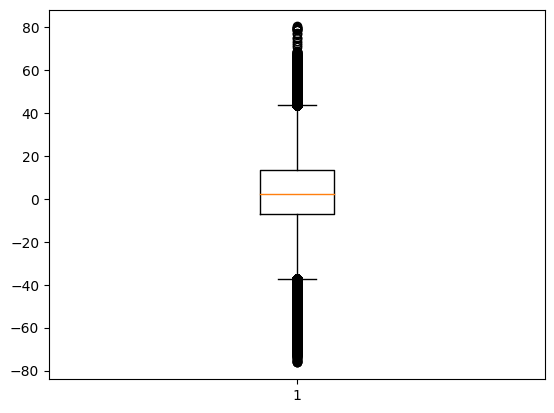




       ankle_x_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                              3.541198e+00
std                               1.649175e+01
min                              -7.624520e+01
25%                              -6.810713e+00
50%                               2.185500e+00
75%                               1.345370e+01
max                               8.047390e+01
feature:  ankle_y_acceleration (ms-2) scale: ±16g


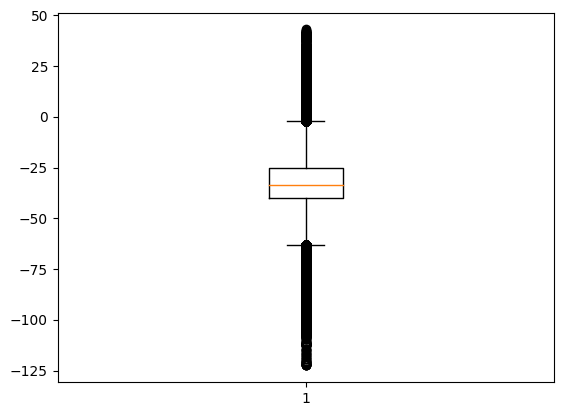




       ankle_y_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -3.180226e+01
std                               1.615753e+01
min                              -1.224800e+02
25%                              -4.019810e+01
50%                              -3.344160e+01
75%                              -2.494327e+01
max                               4.306130e+01
feature:  ankle_z_acceleration (ms-2) scale: ±16g


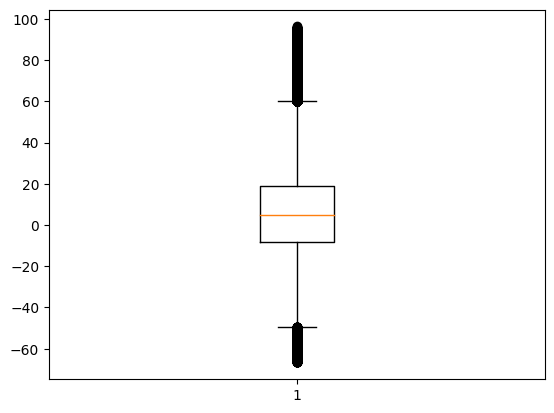




       ankle_z_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                              5.415051e+00
std                               1.995109e+01
min                              -6.668470e+01
25%                              -8.385130e+00
50%                               4.963445e+00
75%                               1.908963e+01
max                               9.635850e+01
feature:  ankle_x_acceleration (ms-2) scale: ±6g


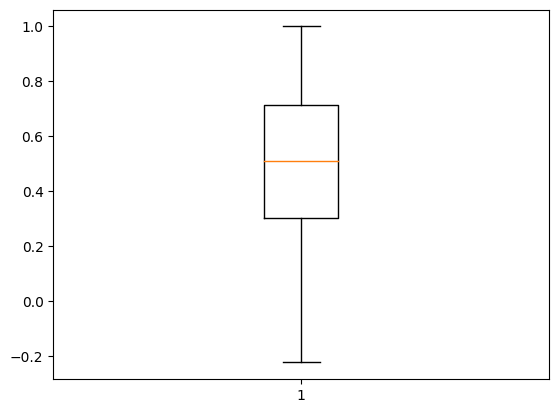




       ankle_x_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             5.320507e-01
std                              2.902368e-01
min                             -2.220890e-01
25%                              3.043260e-01
50%                              5.115265e-01
75%                              7.126200e-01
max                              1.000000e+00
feature:  ankle_y_acceleration (ms-2) scale: ±6g


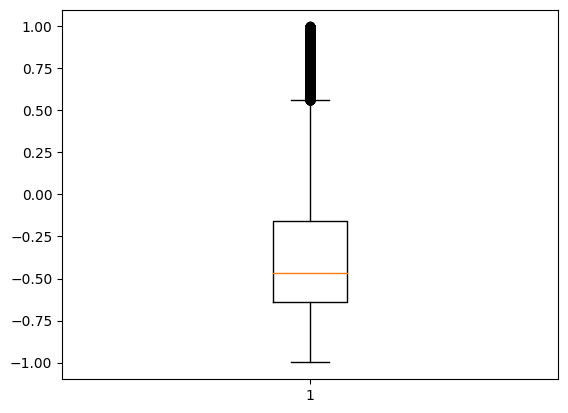




       ankle_y_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                            -4.057228e-01
std                              2.951858e-01
min                             -9.994670e-01
25%                             -6.396870e-01
50%                             -4.666680e-01
75%                             -1.587650e-01
max                              9.992700e-01
feature:  ankle_z_acceleration (ms-2) scale: ±6g


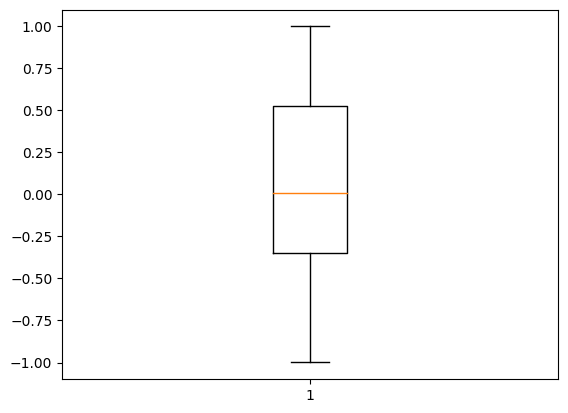




       ankle_z_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             5.871046e-02
std                              4.762474e-01
min                             -9.996350e-01
25%                             -3.520100e-01
50%                              4.842595e-03
75%                              5.257010e-01
max                              9.968640e-01
feature:  ankle_x_gyroscope data (rad/s)


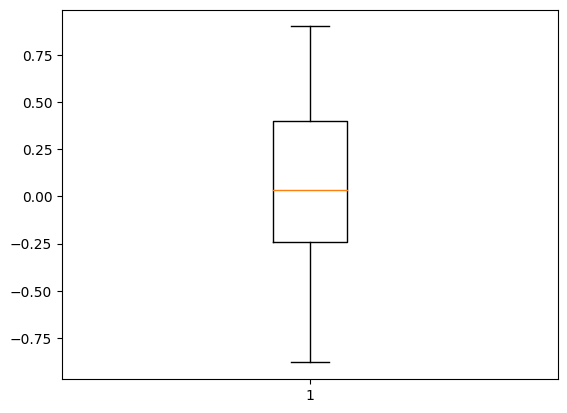




       ankle_x_gyroscope data (rad/s)
count                    2.764560e+06
mean                     5.086170e-02
std                      3.848296e-01
min                     -8.801950e-01
25%                     -2.431970e-01
50%                      3.239005e-02
75%                      3.977762e-01
max                      9.004420e-01
feature:  ankle_y_gyroscope data (rad/s)


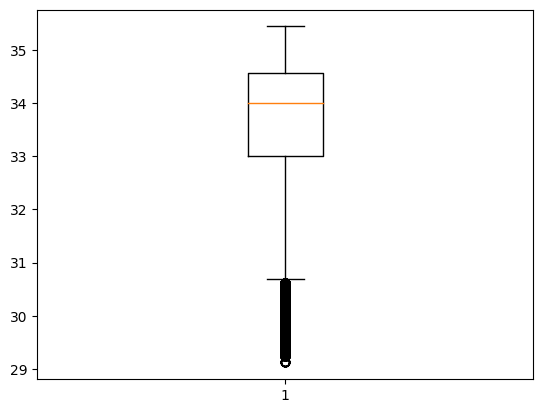




       ankle_y_gyroscope data (rad/s)
count                    2.764560e+06
mean                     3.369502e+01
std                      1.180957e+00
min                      2.912500e+01
25%                      3.300000e+01
50%                      3.400000e+01
75%                      3.456250e+01
max                      3.543750e+01
feature:  ankle_z_gyroscope data (rad/s)


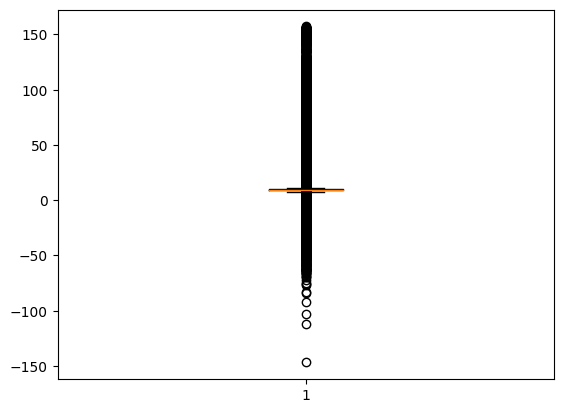




       ankle_z_gyroscope data (rad/s)
count                    2.764560e+06
mean                     9.524099e+00
std                      5.640938e+00
min                     -1.468510e+02
25%                      9.028950e+00
50%                      9.570120e+00
75%                      9.984310e+00
max                      1.572320e+02
feature:  ankle_x_magnetometer data (μT)


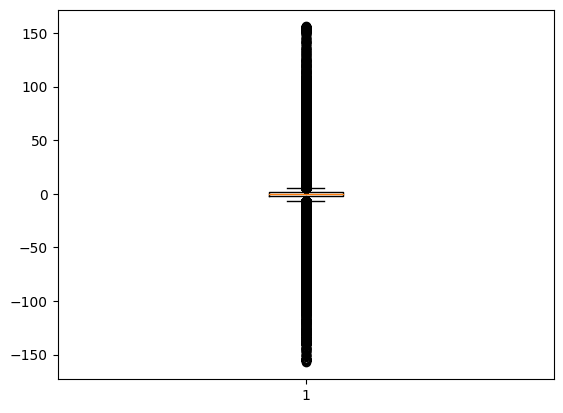




       ankle_x_magnetometer data (μT)
count                    2.764560e+06
mean                    -1.477653e-01
std                      6.763676e+00
min                     -1.574430e+02
25%                     -1.759150e+00
50%                     -2.826150e-01
75%                      1.236950e+00
max                      1.561900e+02
feature:  ankle_y_magnetometer data (μT)


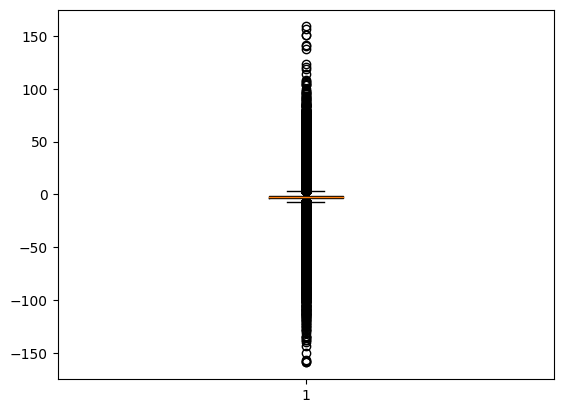




       ankle_y_magnetometer data (μT)
count                    2.764560e+06
mean                    -2.461350e+00
std                      3.500487e+00
min                     -1.589260e+02
25%                     -3.639520e+00
50%                     -2.360390e+00
75%                     -1.064180e+00
max                      1.588720e+02
feature:  ankle_z_magnetometer data (μT)


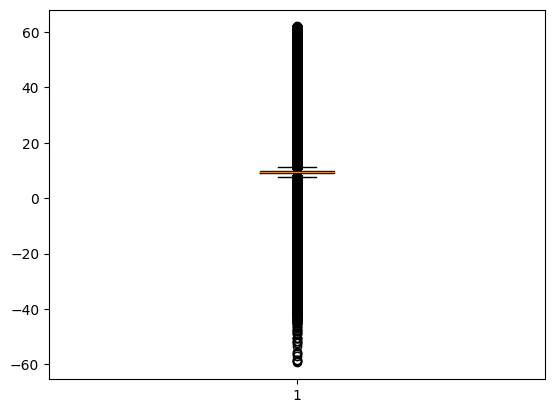




       ankle_z_magnetometer data (μT)
count                    2.764560e+06
mean                     9.501129e+00
std                      5.287274e+00
min                     -5.931200e+01
25%                      9.003530e+00
50%                      9.581700e+00
75%                      9.972360e+00
max                      6.198610e+01
feature:  heart_rate


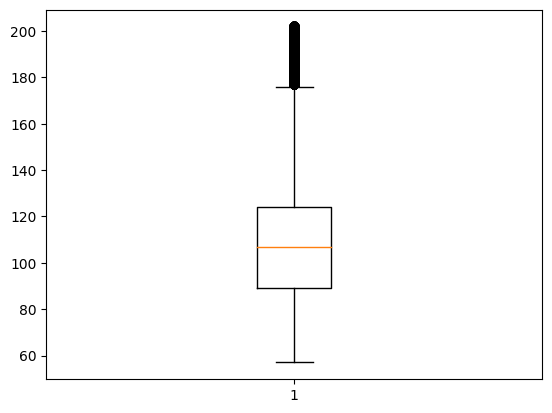




         heart_rate
count  2.764560e+06
mean   1.091075e+02
std    2.573655e+01
min    5.700000e+01
25%    8.900000e+01
50%    1.070000e+02
75%    1.240000e+02
max    2.020000e+02
   Getting train-test datasets   
Fit-transform normalise
Column renaming: activity_id --> label
Fit-transform
Train-test split
Normalise train
Normalise test
Train schema: 
root
 |-- activity_id: integer (nullable = true)
 |-- hand_temperature (°C): double (nullable = true)
 |-- hand_x_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_y_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_z_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_x_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_y_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_z_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_x_gyroscope data (rad/s): double (nullable = true)
 |-- hand_y_gyroscope data (rad/s): double (nullable = true)
 |

In [ ]:
train, test = fill_values(dfs, 'heart_rate', 'nn', True)

##### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

##### Testing

In [ ]:
testing(test,train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_23d842a934db
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_11ab3488aeb7
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|

#### Non-normalised [Linear-Interpolation]

   DataFrames union   
   Subject_id_0   


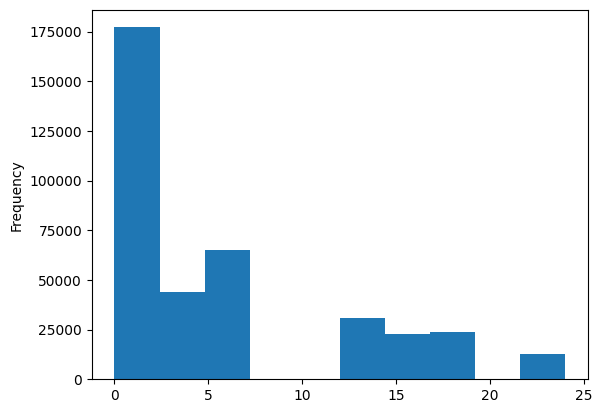

   Subject_id_1   


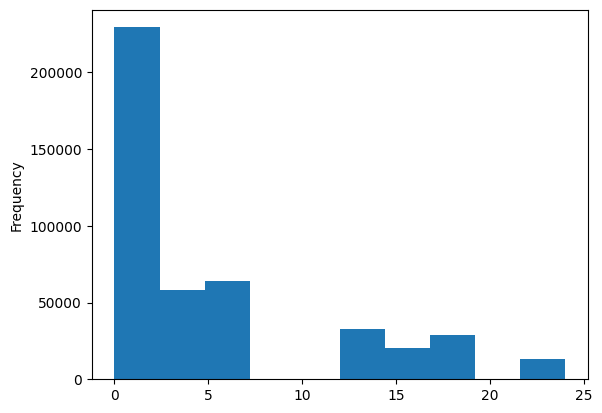

   Subject_id_2   


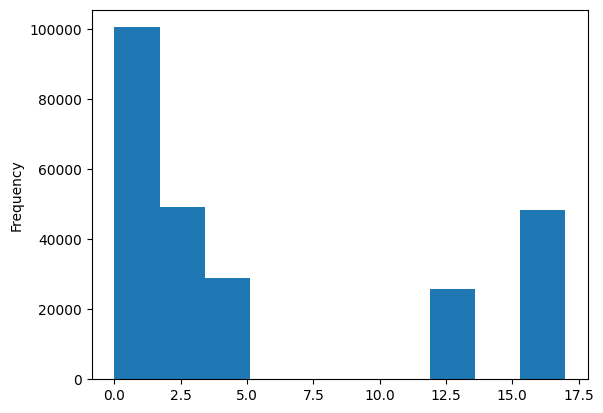

   Subject_id_3   


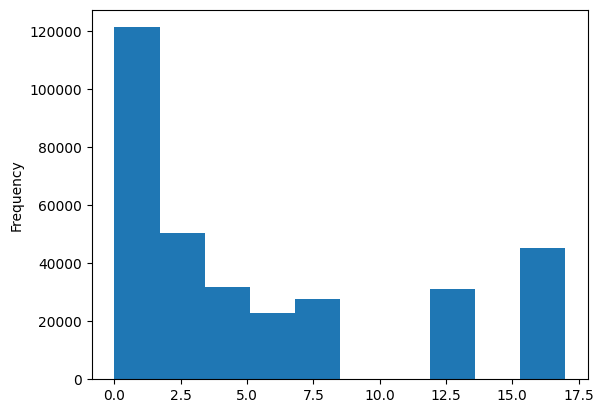

   Subject_id_4   


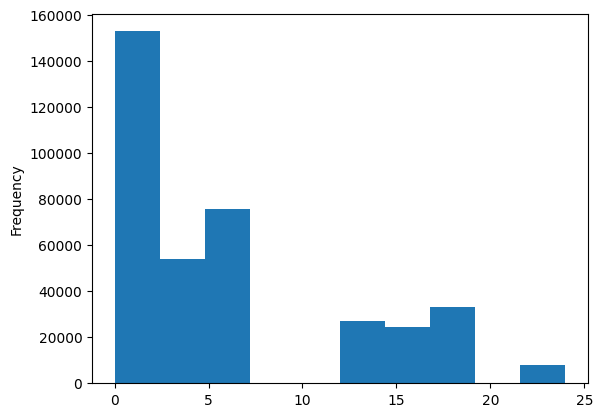

   Subject_id_5   


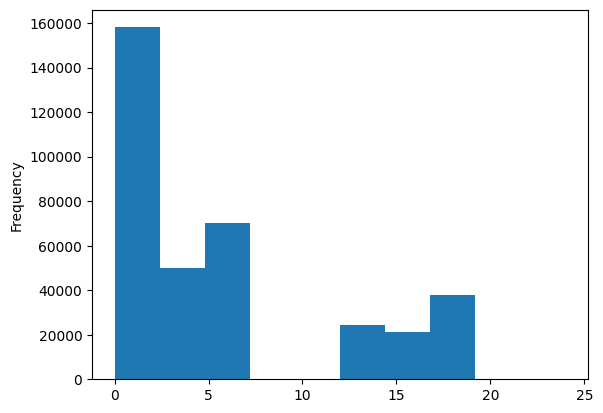

   Subject_id_6   


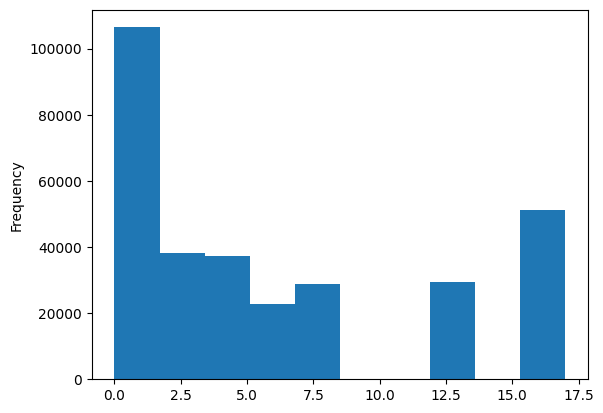

   Subject_id_7   


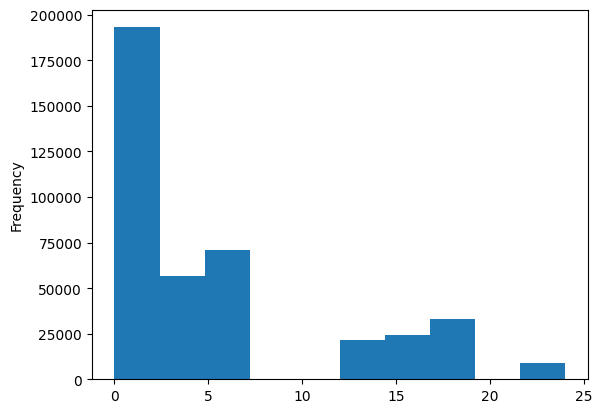

   Subject_id_8   


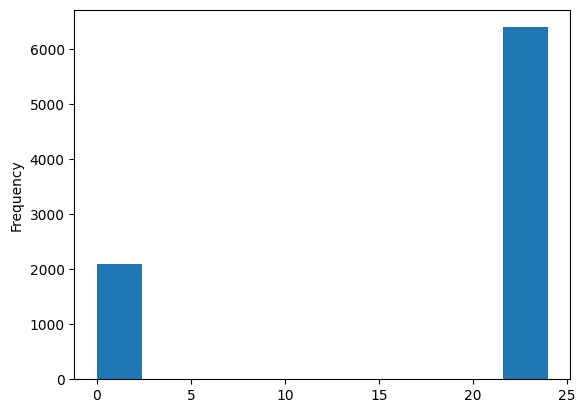

   Rows reduction checking   
Before dropping rows with NaNs: 
number of rows:  2791472
After dropping rows with NaNs: 
number of rows:  2764560


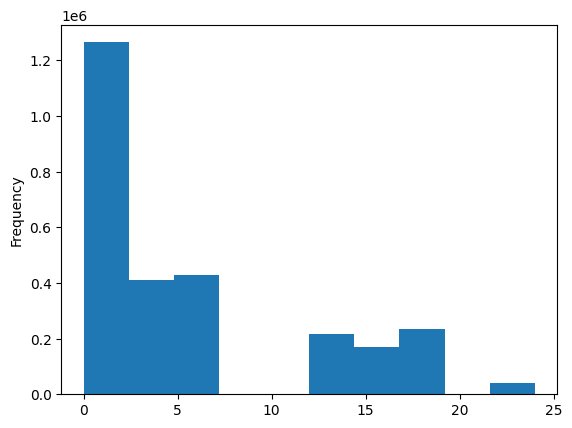

   Data description   
['activity_id', 'hand_temperature (°C)', 'hand_x_acceleration (ms-2) scale: ±16g', 'hand_y_acceleration (ms-2) scale: ±16g', 'hand_z_acceleration (ms-2) scale: ±16g', 'hand_x_acceleration (ms-2) scale: ±6g', 'hand_y_acceleration (ms-2) scale: ±6g', 'hand_z_acceleration (ms-2) scale: ±6g', 'hand_x_gyroscope data (rad/s)', 'hand_y_gyroscope data (rad/s)', 'hand_z_gyroscope data (rad/s)', 'hand_x_magnetometer data (μT)', 'hand_y_magnetometer data (μT)', 'hand_z_magnetometer data (μT)', 'chest_temperature (°C)', 'chest_x_acceleration (ms-2) scale: ±16g', 'chest_y_acceleration (ms-2) scale: ±16g', 'chest_z_acceleration (ms-2) scale: ±16g', 'chest_x_acceleration (ms-2) scale: ±6g', 'chest_y_acceleration (ms-2) scale: ±6g', 'chest_z_acceleration (ms-2) scale: ±6g', 'chest_x_gyroscope data (rad/s)', 'chest_y_gyroscope data (rad/s)', 'chest_z_gyroscope data (rad/s)', 'chest_x_magnetometer data (μT)', 'chest_y_magnetometer data (μT)', 'chest_z_magnetometer data (μT)', 'ank

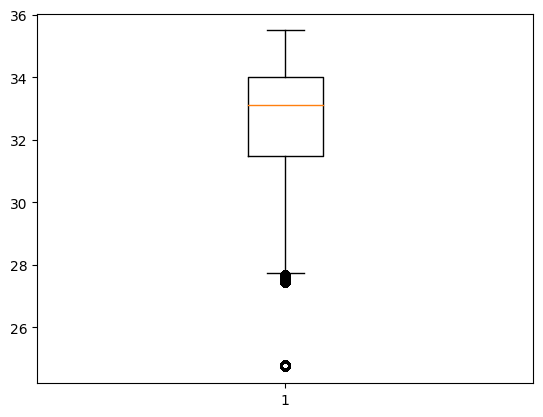




       hand_temperature (°C)
count           2.764560e+06
mean            3.268527e+01
std             1.799058e+00
min             2.475000e+01
25%             3.150000e+01
50%             3.312500e+01
75%             3.400000e+01
max             3.550000e+01
feature:  hand_x_acceleration (ms-2) scale: ±16g


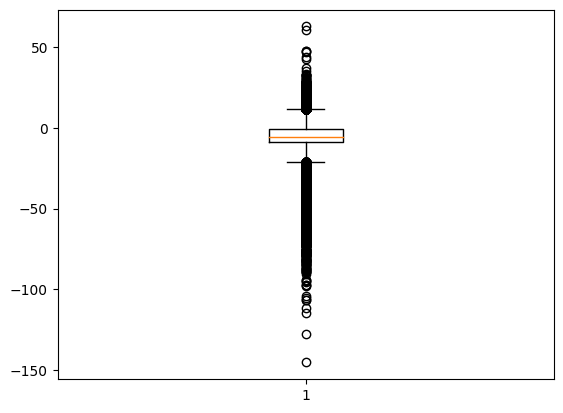




       hand_x_acceleration (ms-2) scale: ±16g
count                            2.764560e+06
mean                            -4.967707e+00
std                              5.980077e+00
min                             -1.453670e+02
25%                             -9.032180e+00
50%                             -5.799250e+00
75%                             -7.883710e-01
max                              6.285960e+01
feature:  hand_y_acceleration (ms-2) scale: ±16g


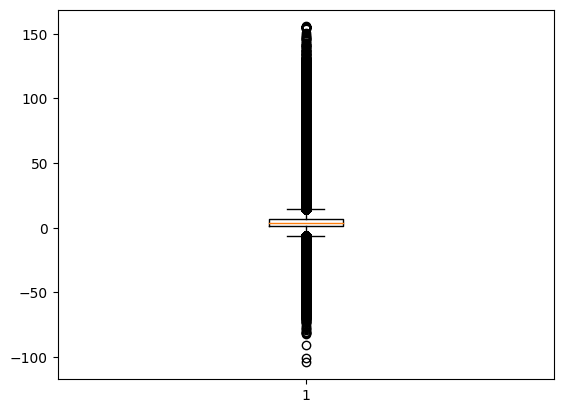




       hand_y_acceleration (ms-2) scale: ±16g
count                            2.764560e+06
mean                             3.572707e+00
std                              6.235315e+00
min                             -1.043010e+02
25%                              1.298580e+00
50%                              3.570990e+00
75%                              6.599440e+00
max                              1.556990e+02
feature:  hand_z_acceleration (ms-2) scale: ±16g


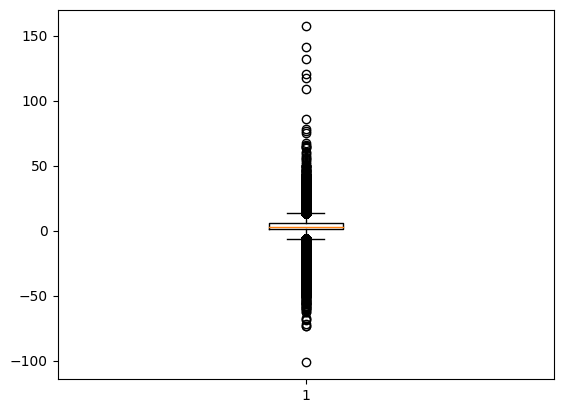




       hand_z_acceleration (ms-2) scale: ±16g
count                            2.764560e+06
mean                             3.180870e+00
std                              3.827906e+00
min                             -1.014520e+02
25%                              9.769498e-01
50%                              2.963445e+00
75%                              6.011107e+00
max                              1.569490e+02
feature:  hand_x_acceleration (ms-2) scale: ±6g


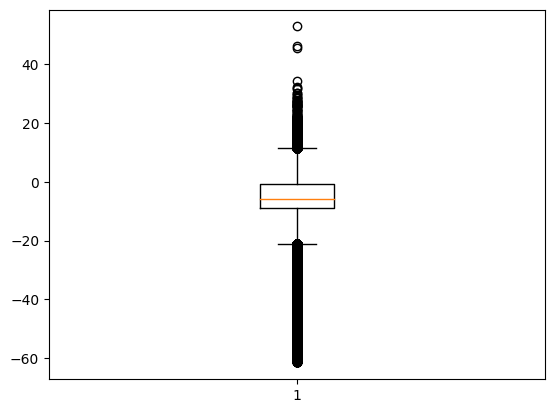




       hand_x_acceleration (ms-2) scale: ±6g
count                           2.764560e+06
mean                           -4.895294e+00
std                             5.987766e+00
min                            -6.148950e+01
25%                            -8.935893e+00
50%                            -5.747670e+00
75%                            -7.296260e-01
max                             5.282140e+01
feature:  hand_y_acceleration (ms-2) scale: ±6g


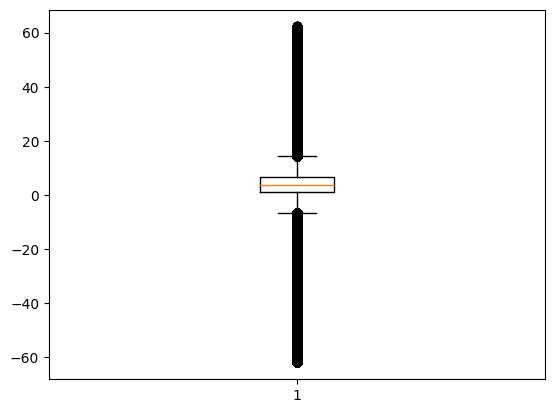




       hand_y_acceleration (ms-2) scale: ±6g
count                           2.764560e+06
mean                            3.569105e+00
std                             6.014209e+00
min                            -6.186800e+01
25%                             1.292178e+00
50%                             3.613480e+00
75%                             6.598380e+00
max                             6.225980e+01
feature:  hand_z_acceleration (ms-2) scale: ±6g


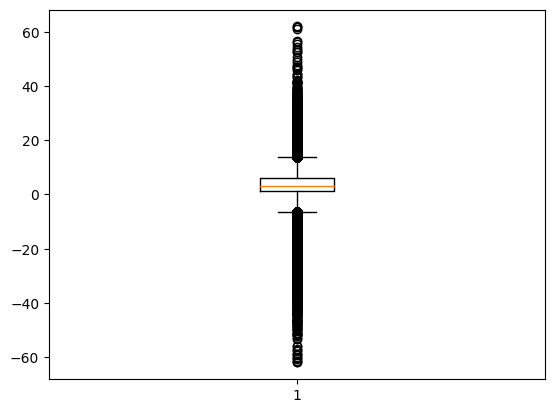




       hand_z_acceleration (ms-2) scale: ±6g
count                           2.764560e+06
mean                            3.363231e+00
std                             3.824965e+00
min                            -6.193470e+01
25%                             1.175920e+00
50%                             3.137860e+00
75%                             6.261150e+00
max                             6.194460e+01
feature:  hand_x_gyroscope data (rad/s)


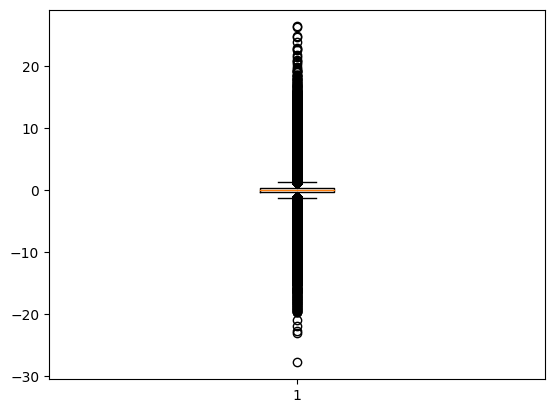




       hand_x_gyroscope data (rad/s)
count                   2.764560e+06
mean                   -4.471352e-03
std                     1.294144e+00
min                    -2.780440e+01
25%                    -3.436172e-01
50%                    -6.103725e-03
75%                     2.980563e-01
max                     2.641580e+01
feature:  hand_y_gyroscope data (rad/s)


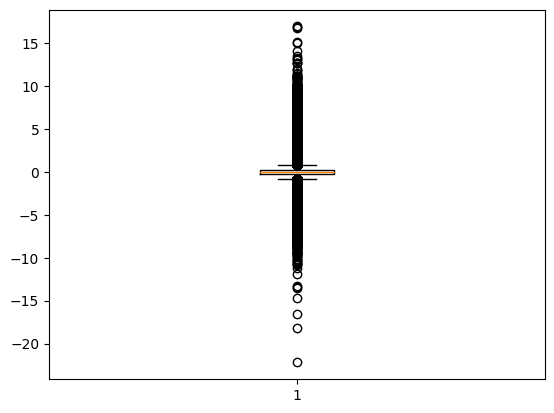




       hand_y_gyroscope data (rad/s)
count                   2.764560e+06
mean                    3.142994e-02
std                     8.798647e-01
min                    -2.221270e+01
25%                    -1.940760e-01
50%                     6.052800e-03
75%                     2.325540e-01
max                     1.698350e+01
feature:  hand_z_gyroscope data (rad/s)


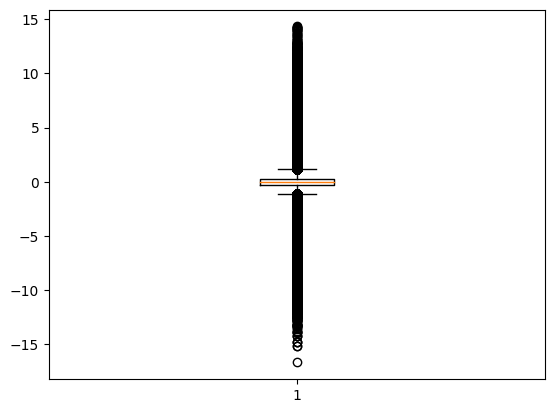




       hand_z_gyroscope data (rad/s)
count                   2.764560e+06
mean                   -7.015729e-03
std                     1.446692e+00
min                    -1.669970e+01
25%                    -2.971140e-01
50%                    -5.392590e-03
75%                     2.874130e-01
max                     1.433840e+01
feature:  hand_x_magnetometer data (μT)


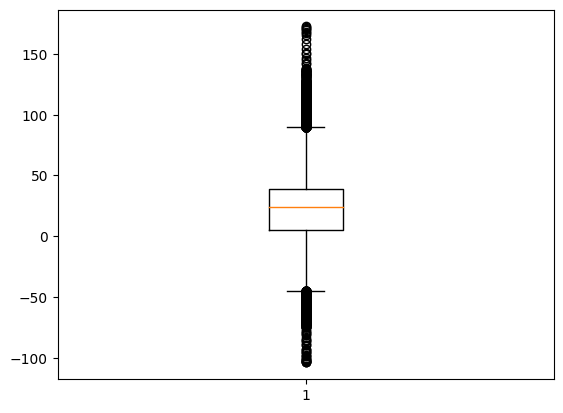




       hand_x_magnetometer data (μT)
count                   2.764560e+06
mean                    2.118536e+01
std                     2.402123e+01
min                    -1.039410e+02
25%                     5.296283e+00
50%                     2.413310e+01
75%                     3.916110e+01
max                     1.725900e+02
feature:  hand_y_magnetometer data (μT)


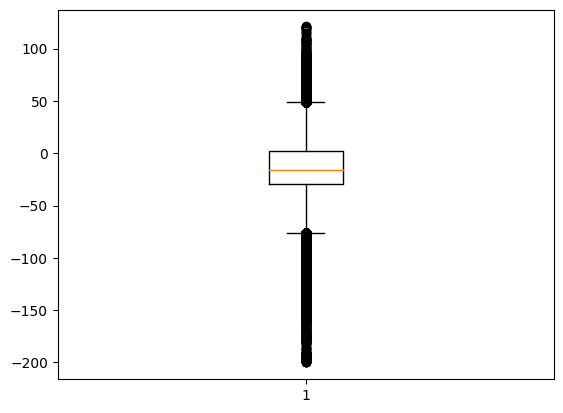




       hand_y_magnetometer data (μT)
count                   2.764560e+06
mean                   -1.434682e+01
std                     2.411807e+01
min                    -2.000430e+02
25%                    -2.949840e+01
50%                    -1.647820e+01
75%                     1.736782e+00
max                     1.211760e+02
feature:  hand_z_magnetometer data (μT)


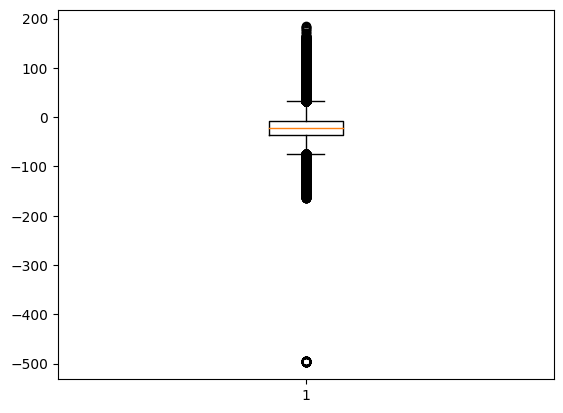




       hand_z_magnetometer data (μT)
count                   2.764560e+06
mean                   -2.164671e+01
std                     2.067739e+01
min                    -4.976320e+02
25%                    -3.532892e+01
50%                    -2.149290e+01
75%                    -8.435627e+00
max                     1.839110e+02
feature:  chest_temperature (°C)


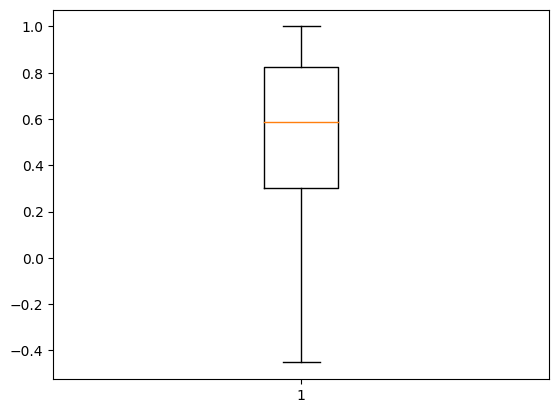




       chest_temperature (°C)
count            2.764560e+06
mean             5.669270e-01
std              3.050382e-01
min             -4.522460e-01
25%              3.016990e-01
50%              5.875755e-01
75%              8.235132e-01
max              1.000000e+00
feature:  chest_x_acceleration (ms-2) scale: ±16g


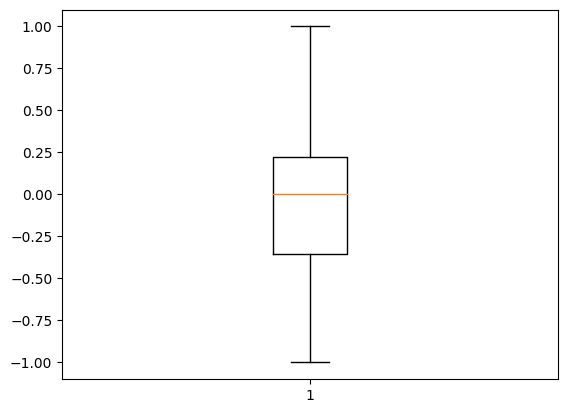




       chest_x_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -5.467422e-02
std                               3.773901e-01
min                              -9.999960e-01
25%                              -3.526110e-01
50%                               0.000000e+00
75%                               2.218200e-01
max                               9.999430e-01
feature:  chest_y_acceleration (ms-2) scale: ±16g


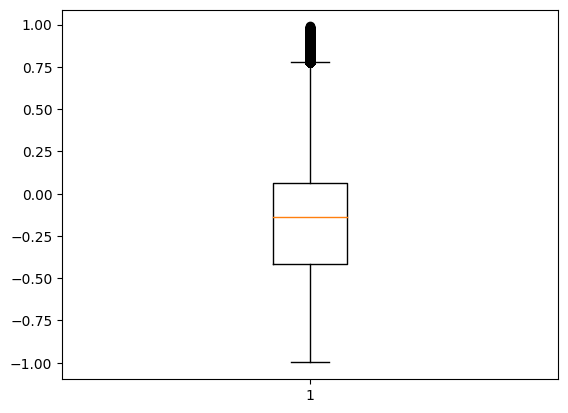




       chest_y_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -1.398759e-01
std                               3.341640e-01
min                              -9.982610e-01
25%                              -4.140570e-01
50%                              -1.380550e-01
75%                               6.301770e-02
max                               9.888270e-01
feature:  chest_z_acceleration (ms-2) scale: ±16g


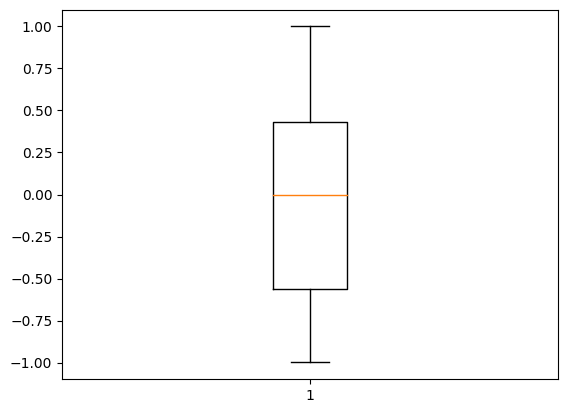




       chest_z_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -3.399915e-02
std                               5.547489e-01
min                              -9.993260e-01
25%                              -5.628243e-01
50%                               0.000000e+00
75%                               4.308460e-01
max                               9.996770e-01
feature:  chest_x_acceleration (ms-2) scale: ±6g


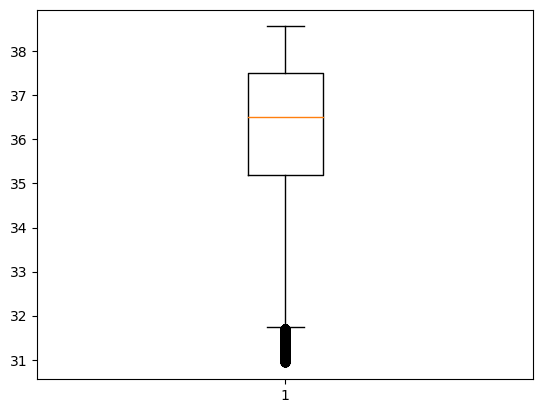




       chest_x_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             3.616458e+01
std                              1.572483e+00
min                              3.093750e+01
25%                              3.518750e+01
50%                              3.650000e+01
75%                              3.750000e+01
max                              3.856250e+01
feature:  chest_y_acceleration (ms-2) scale: ±6g


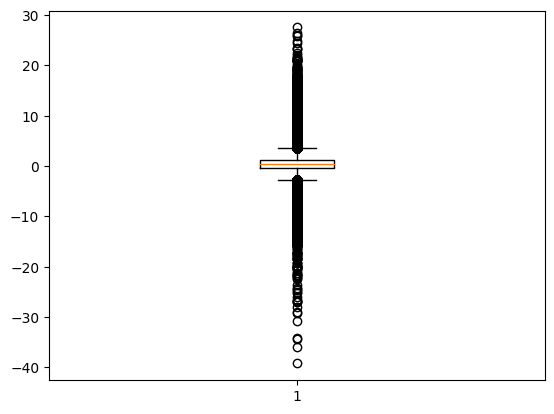




       chest_y_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             3.785917e-01
std                              1.612729e+00
min                             -3.920340e+01
25%                             -4.145040e-01
50%                              4.514290e-01
75%                              1.155060e+00
max                              2.752230e+01
feature:  chest_z_acceleration (ms-2) scale: ±6g


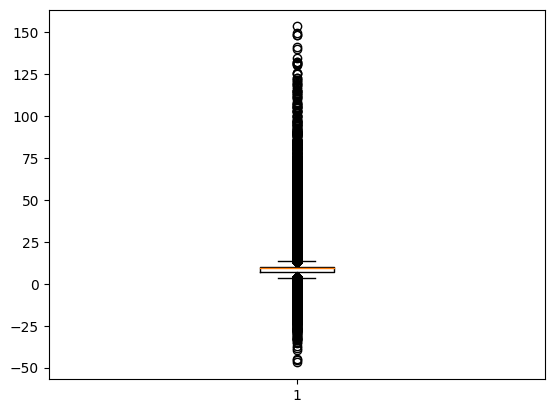




       chest_z_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             8.507493e+00
std                              4.186070e+00
min                             -4.692460e+01
25%                              7.324400e+00
50%                              9.391615e+00
75%                              9.799230e+00
max                              1.535820e+02
feature:  chest_x_gyroscope data (rad/s)


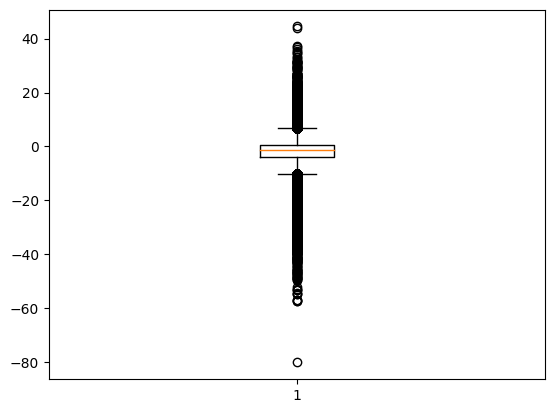




       chest_x_gyroscope data (rad/s)
count                    2.764560e+06
mean                    -1.513107e+00
std                      4.177856e+00
min                     -8.016680e+01
25%                     -3.879833e+00
50%                     -1.287040e+00
75%                      3.963720e-01
max                      4.449890e+01
feature:  chest_y_gyroscope data (rad/s)


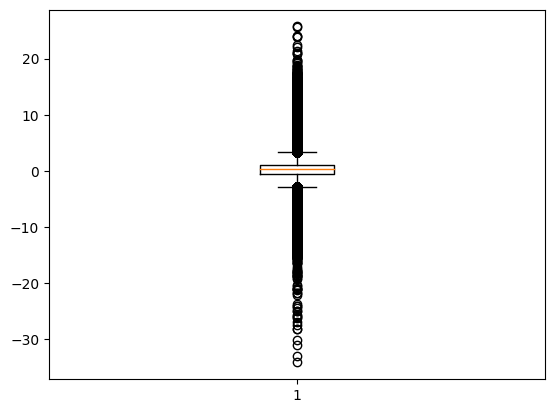




       chest_y_gyroscope data (rad/s)
count                    2.764560e+06
mean                     2.470914e-01
std                      1.611522e+00
min                     -3.420400e+01
25%                     -5.301665e-01
50%                      3.219225e-01
75%                      1.007190e+00
max                      2.573610e+01
feature:  chest_z_gyroscope data (rad/s)


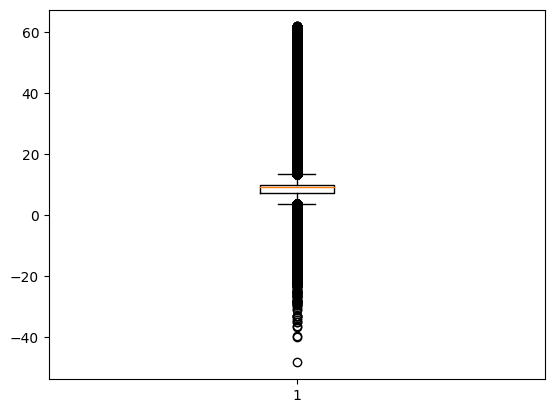




       chest_z_gyroscope data (rad/s)
count                    2.764560e+06
mean                     8.500801e+00
std                      4.154649e+00
min                     -4.825720e+01
25%                      7.309468e+00
50%                      9.355440e+00
75%                      9.811270e+00
max                      6.193730e+01
feature:  chest_x_magnetometer data (μT)


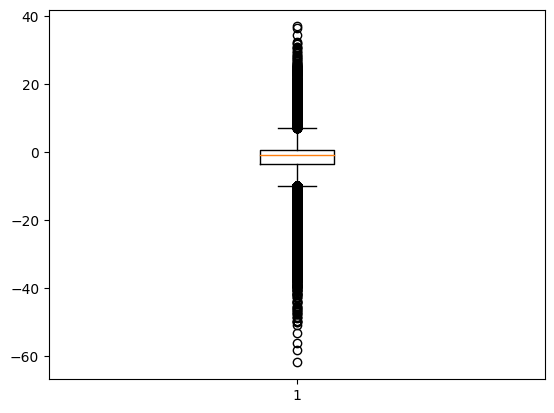




       chest_x_magnetometer data (μT)
count                    2.764560e+06
mean                    -1.177618e+00
std                      4.191271e+00
min                     -6.180410e+01
25%                     -3.563073e+00
50%                     -9.218600e-01
75%                      7.613853e-01
max                      3.696760e+01
feature:  chest_y_magnetometer data (μT)


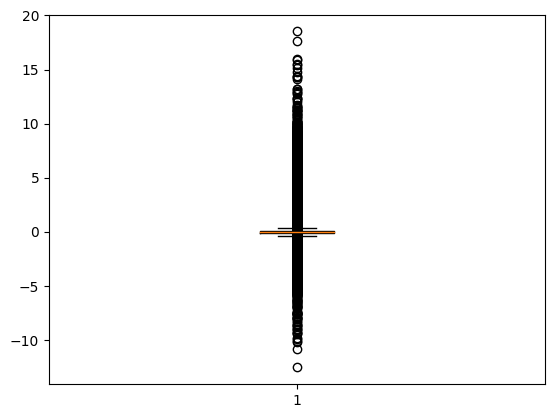




       chest_y_magnetometer data (μT)
count                    2.764560e+06
mean                     5.285176e-03
std                      3.972346e-01
min                     -1.252510e+01
25%                     -9.044355e-02
50%                      3.210540e-03
75%                      9.741375e-02
max                      1.851590e+01
feature:  chest_z_magnetometer data (μT)


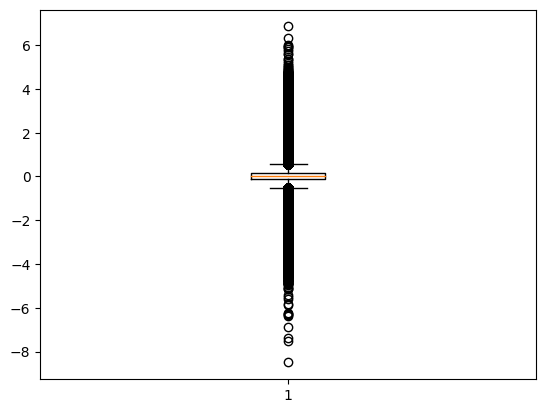




       chest_z_magnetometer data (μT)
count                    2.764560e+06
mean                     8.399839e-03
std                      5.356529e-01
min                     -8.499900e+00
25%                     -1.251002e-01
50%                     -3.447810e-06
75%                      1.448570e-01
max                      6.852570e+00
feature:  ankle_temperature (°C)


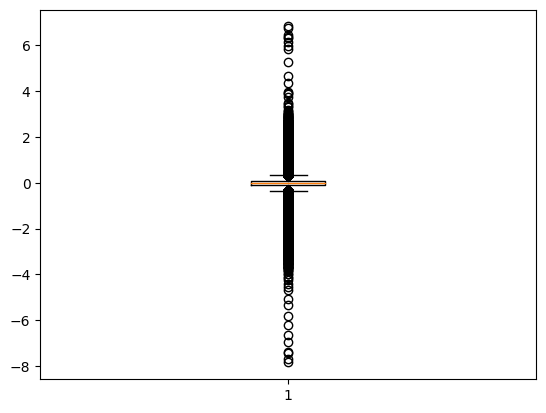




       ankle_temperature (°C)
count            2.764560e+06
mean            -2.120797e-02
std              2.897837e-01
min             -7.851890e+00
25%             -1.111320e-01
50%             -1.633315e-02
75%              6.983453e-02
max              6.824240e+00
feature:  ankle_x_acceleration (ms-2) scale: ±16g


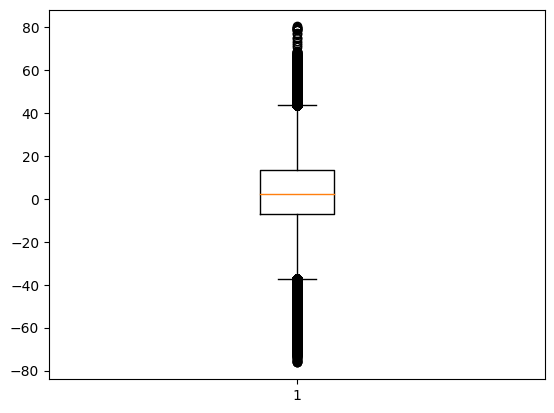




       ankle_x_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                              3.541198e+00
std                               1.649175e+01
min                              -7.624520e+01
25%                              -6.810713e+00
50%                               2.185500e+00
75%                               1.345370e+01
max                               8.047390e+01
feature:  ankle_y_acceleration (ms-2) scale: ±16g


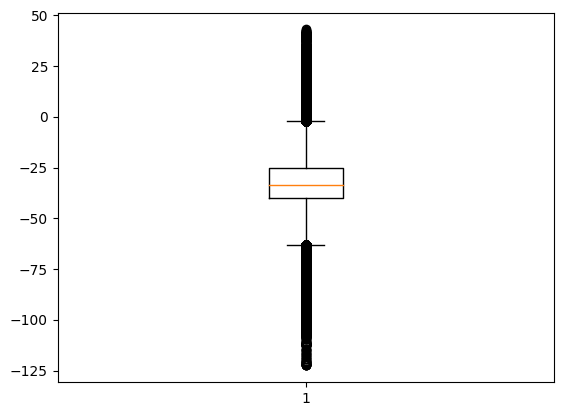




       ankle_y_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -3.180226e+01
std                               1.615753e+01
min                              -1.224800e+02
25%                              -4.019810e+01
50%                              -3.344160e+01
75%                              -2.494327e+01
max                               4.306130e+01
feature:  ankle_z_acceleration (ms-2) scale: ±16g


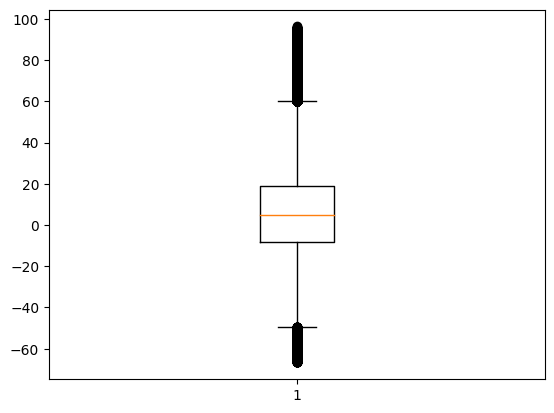




       ankle_z_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                              5.415051e+00
std                               1.995109e+01
min                              -6.668470e+01
25%                              -8.385130e+00
50%                               4.963445e+00
75%                               1.908963e+01
max                               9.635850e+01
feature:  ankle_x_acceleration (ms-2) scale: ±6g


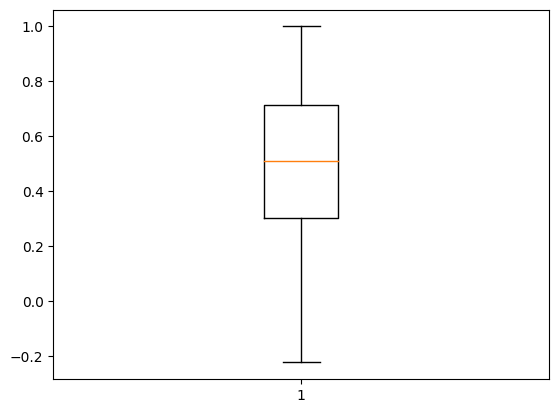




       ankle_x_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             5.320507e-01
std                              2.902368e-01
min                             -2.220890e-01
25%                              3.043260e-01
50%                              5.115265e-01
75%                              7.126200e-01
max                              1.000000e+00
feature:  ankle_y_acceleration (ms-2) scale: ±6g


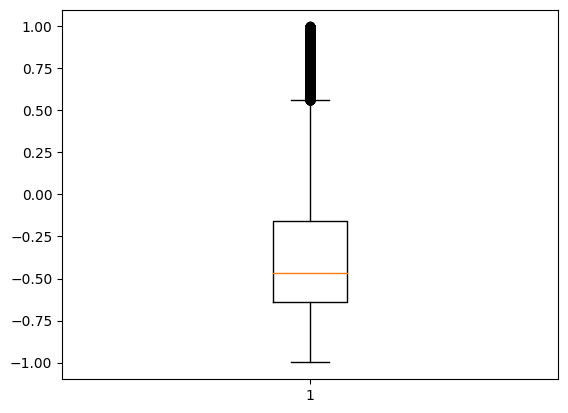




       ankle_y_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                            -4.057228e-01
std                              2.951858e-01
min                             -9.994670e-01
25%                             -6.396870e-01
50%                             -4.666680e-01
75%                             -1.587650e-01
max                              9.992700e-01
feature:  ankle_z_acceleration (ms-2) scale: ±6g


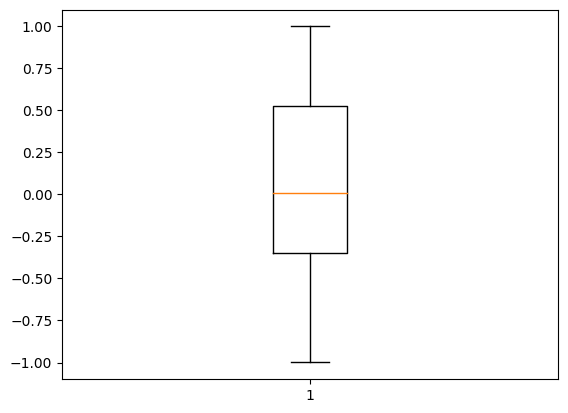




       ankle_z_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             5.871046e-02
std                              4.762474e-01
min                             -9.996350e-01
25%                             -3.520100e-01
50%                              4.842595e-03
75%                              5.257010e-01
max                              9.968640e-01
feature:  ankle_x_gyroscope data (rad/s)


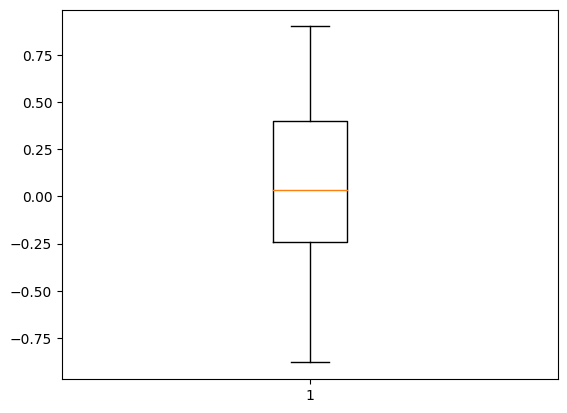




       ankle_x_gyroscope data (rad/s)
count                    2.764560e+06
mean                     5.086170e-02
std                      3.848296e-01
min                     -8.801950e-01
25%                     -2.431970e-01
50%                      3.239005e-02
75%                      3.977762e-01
max                      9.004420e-01
feature:  ankle_y_gyroscope data (rad/s)


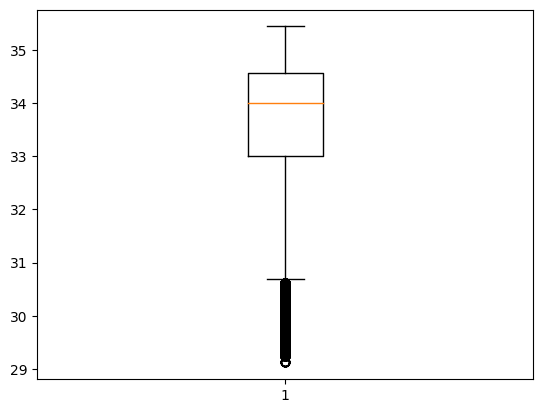




       ankle_y_gyroscope data (rad/s)
count                    2.764560e+06
mean                     3.369502e+01
std                      1.180957e+00
min                      2.912500e+01
25%                      3.300000e+01
50%                      3.400000e+01
75%                      3.456250e+01
max                      3.543750e+01
feature:  ankle_z_gyroscope data (rad/s)


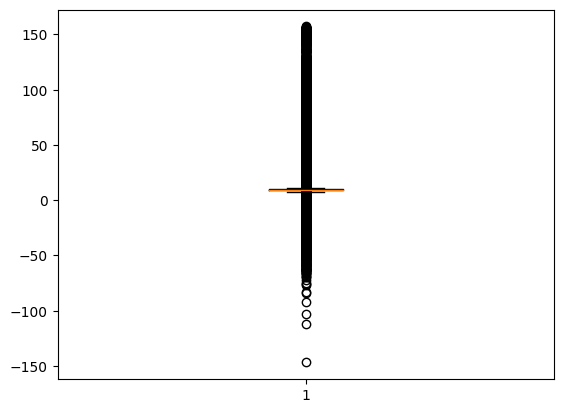




       ankle_z_gyroscope data (rad/s)
count                    2.764560e+06
mean                     9.524099e+00
std                      5.640938e+00
min                     -1.468510e+02
25%                      9.028950e+00
50%                      9.570120e+00
75%                      9.984310e+00
max                      1.572320e+02
feature:  ankle_x_magnetometer data (μT)


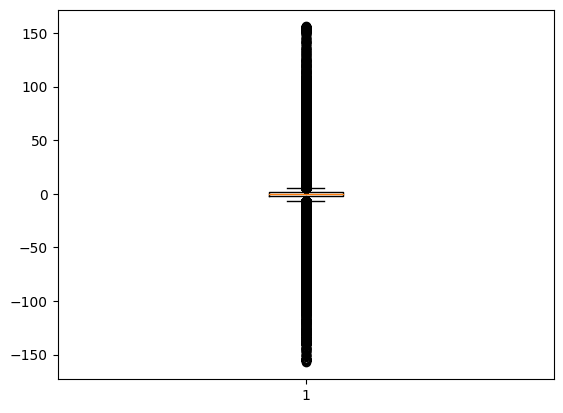




       ankle_x_magnetometer data (μT)
count                    2.764560e+06
mean                    -1.477653e-01
std                      6.763676e+00
min                     -1.574430e+02
25%                     -1.759150e+00
50%                     -2.826150e-01
75%                      1.236950e+00
max                      1.561900e+02
feature:  ankle_y_magnetometer data (μT)


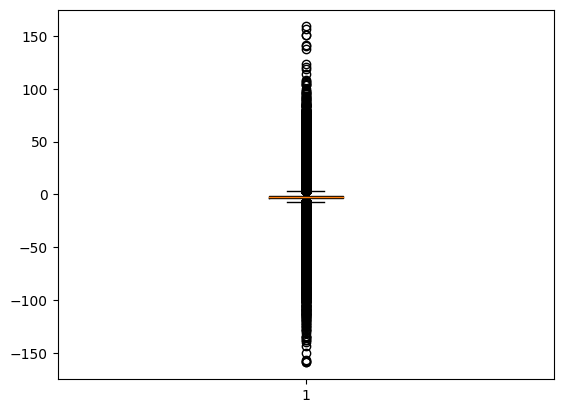




       ankle_y_magnetometer data (μT)
count                    2.764560e+06
mean                    -2.461350e+00
std                      3.500487e+00
min                     -1.589260e+02
25%                     -3.639520e+00
50%                     -2.360390e+00
75%                     -1.064180e+00
max                      1.588720e+02
feature:  ankle_z_magnetometer data (μT)


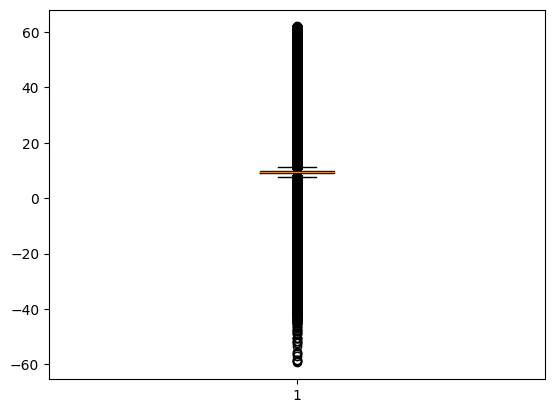




       ankle_z_magnetometer data (μT)
count                    2.764560e+06
mean                     9.501129e+00
std                      5.287274e+00
min                     -5.931200e+01
25%                      9.003530e+00
50%                      9.581700e+00
75%                      9.972360e+00
max                      6.198610e+01
feature:  heart_rate


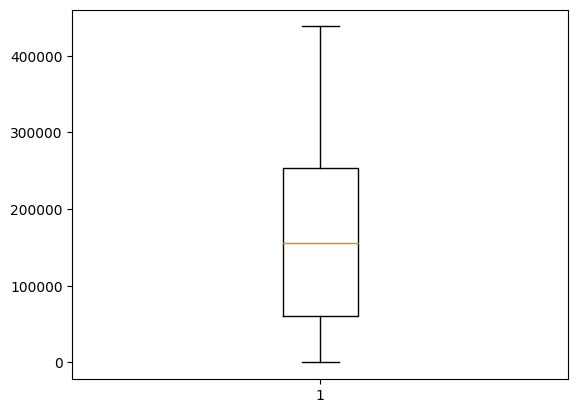




         heart_rate
count  2.764560e+06
mean   1.620095e+05
std    1.149161e+05
min    0.000000e+00
25%    6.039300e+04
50%    1.559110e+05
75%    2.536830e+05
max    4.381649e+05
   Getting train-test datasets   
Fit-transform
Train-test split
Train schema: 
root
 |-- activity_id: integer (nullable = true)
 |-- hand_temperature (°C): double (nullable = true)
 |-- hand_x_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_y_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_z_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_x_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_y_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_z_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_x_gyroscope data (rad/s): double (nullable = true)
 |-- hand_y_gyroscope data (rad/s): double (nullable = true)
 |-- hand_z_gyroscope data (rad/s): double (nullable = true)
 |-- hand_x_magnetometer data (μT):

In [ ]:
train, test = fill_values(dfs, 'heart_rate', 'li', False)

##### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

##### Testing

In [ ]:
testing(test,train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_7d60ae30479b
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_bc0a8a5c1af9
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|

#### Normalised [Linear-Interpolation]

   DataFrames union   
   Subject_id_0   


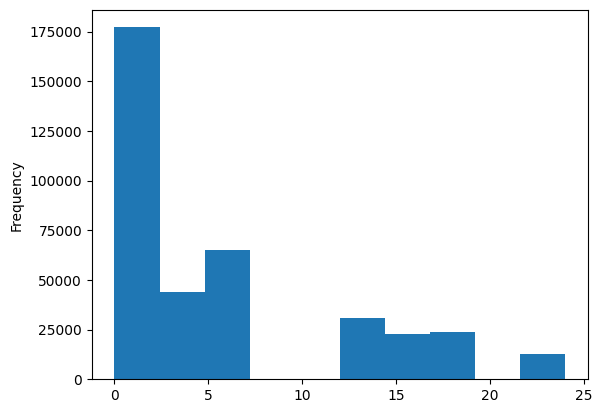

   Subject_id_1   


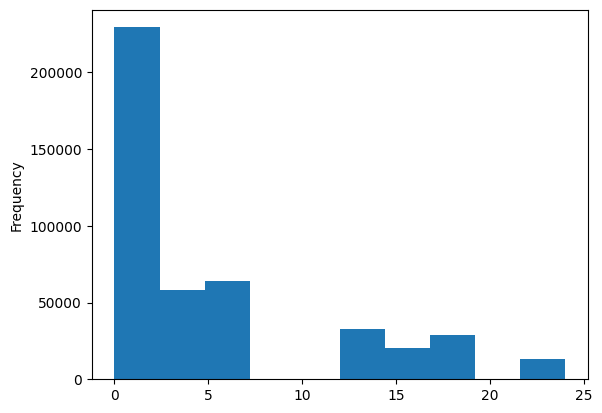

   Subject_id_2   


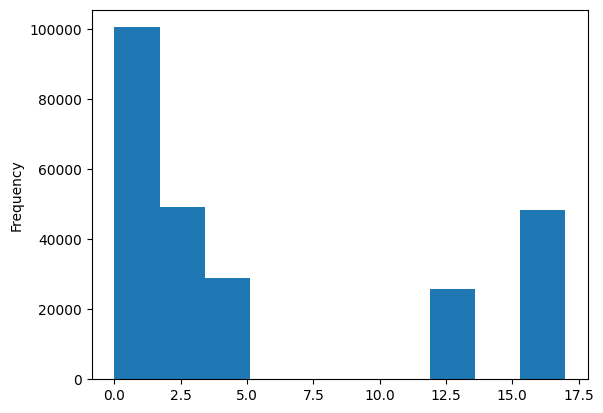

   Subject_id_3   


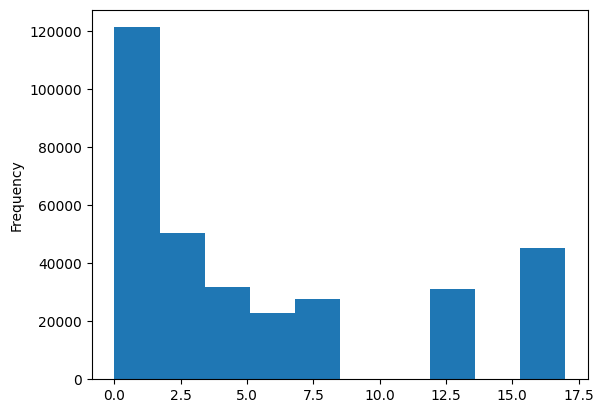

   Subject_id_4   


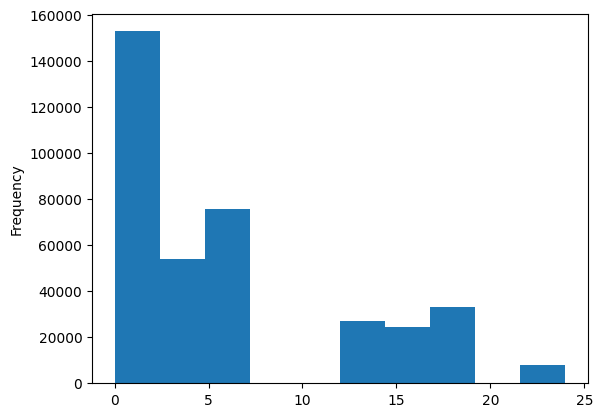

   Subject_id_5   


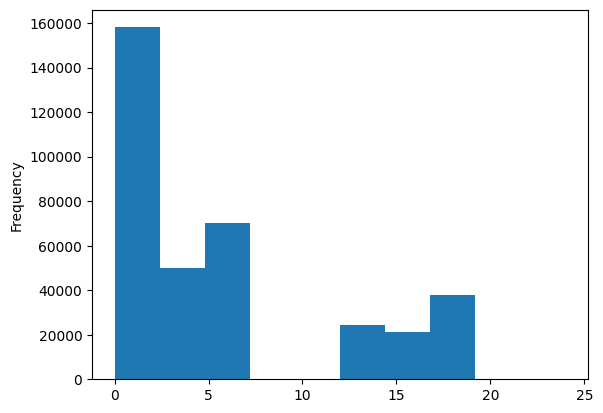

   Subject_id_6   


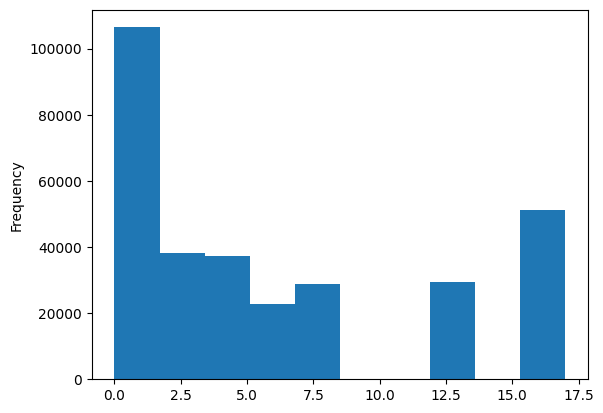

   Subject_id_7   


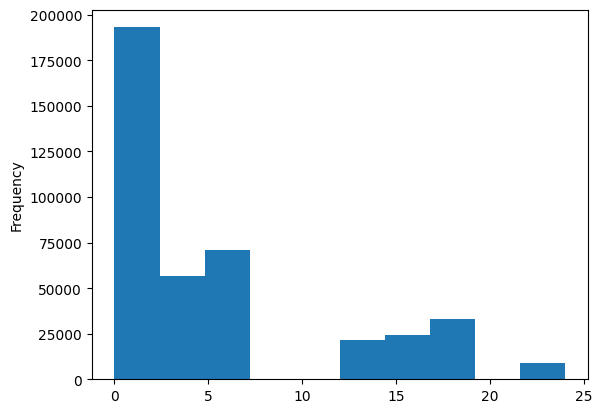

   Subject_id_8   


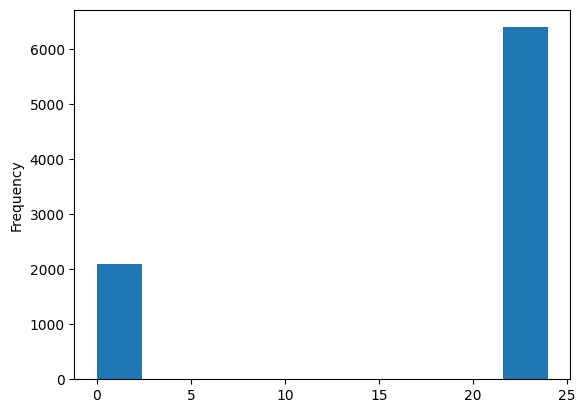

   Rows reduction checking   
Before dropping rows with NaNs: 
number of rows:  2791472
After dropping rows with NaNs: 
number of rows:  2764560


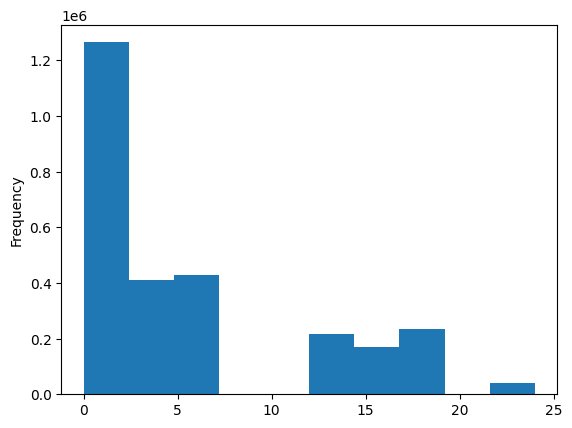

   Data description   
['activity_id', 'hand_temperature (°C)', 'hand_x_acceleration (ms-2) scale: ±16g', 'hand_y_acceleration (ms-2) scale: ±16g', 'hand_z_acceleration (ms-2) scale: ±16g', 'hand_x_acceleration (ms-2) scale: ±6g', 'hand_y_acceleration (ms-2) scale: ±6g', 'hand_z_acceleration (ms-2) scale: ±6g', 'hand_x_gyroscope data (rad/s)', 'hand_y_gyroscope data (rad/s)', 'hand_z_gyroscope data (rad/s)', 'hand_x_magnetometer data (μT)', 'hand_y_magnetometer data (μT)', 'hand_z_magnetometer data (μT)', 'chest_temperature (°C)', 'chest_x_acceleration (ms-2) scale: ±16g', 'chest_y_acceleration (ms-2) scale: ±16g', 'chest_z_acceleration (ms-2) scale: ±16g', 'chest_x_acceleration (ms-2) scale: ±6g', 'chest_y_acceleration (ms-2) scale: ±6g', 'chest_z_acceleration (ms-2) scale: ±6g', 'chest_x_gyroscope data (rad/s)', 'chest_y_gyroscope data (rad/s)', 'chest_z_gyroscope data (rad/s)', 'chest_x_magnetometer data (μT)', 'chest_y_magnetometer data (μT)', 'chest_z_magnetometer data (μT)', 'ank

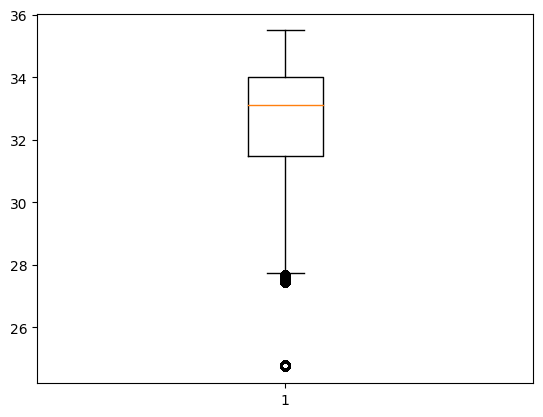




       hand_temperature (°C)
count           2.764560e+06
mean            3.268527e+01
std             1.799058e+00
min             2.475000e+01
25%             3.150000e+01
50%             3.312500e+01
75%             3.400000e+01
max             3.550000e+01
feature:  hand_x_acceleration (ms-2) scale: ±16g


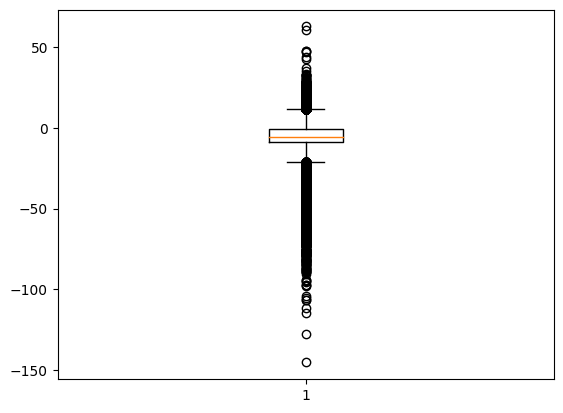




       hand_x_acceleration (ms-2) scale: ±16g
count                            2.764560e+06
mean                            -4.967707e+00
std                              5.980077e+00
min                             -1.453670e+02
25%                             -9.032180e+00
50%                             -5.799250e+00
75%                             -7.883710e-01
max                              6.285960e+01
feature:  hand_y_acceleration (ms-2) scale: ±16g


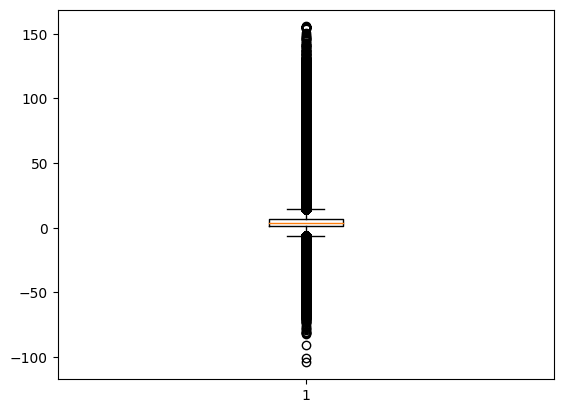




       hand_y_acceleration (ms-2) scale: ±16g
count                            2.764560e+06
mean                             3.572707e+00
std                              6.235315e+00
min                             -1.043010e+02
25%                              1.298580e+00
50%                              3.570990e+00
75%                              6.599440e+00
max                              1.556990e+02
feature:  hand_z_acceleration (ms-2) scale: ±16g


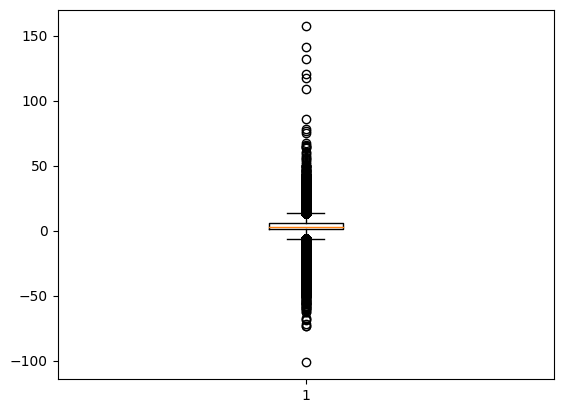




       hand_z_acceleration (ms-2) scale: ±16g
count                            2.764560e+06
mean                             3.180870e+00
std                              3.827906e+00
min                             -1.014520e+02
25%                              9.769498e-01
50%                              2.963445e+00
75%                              6.011107e+00
max                              1.569490e+02
feature:  hand_x_acceleration (ms-2) scale: ±6g


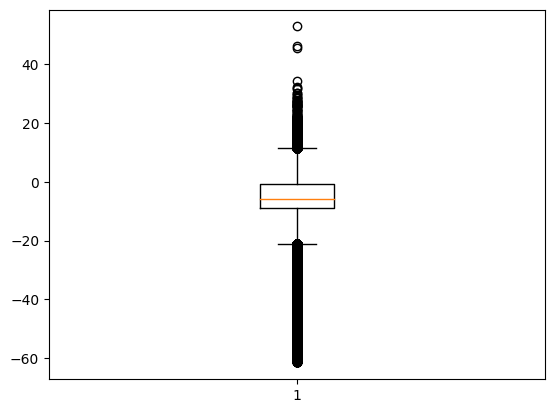




       hand_x_acceleration (ms-2) scale: ±6g
count                           2.764560e+06
mean                           -4.895294e+00
std                             5.987766e+00
min                            -6.148950e+01
25%                            -8.935893e+00
50%                            -5.747670e+00
75%                            -7.296260e-01
max                             5.282140e+01
feature:  hand_y_acceleration (ms-2) scale: ±6g


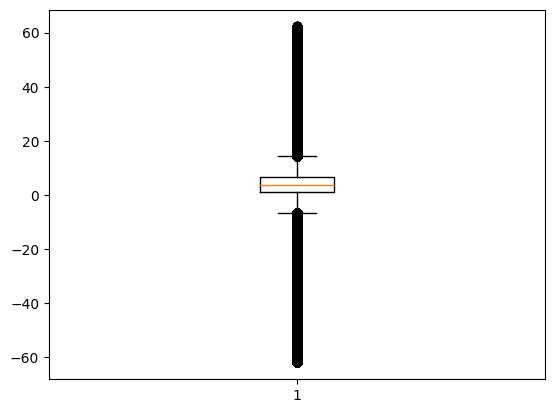




       hand_y_acceleration (ms-2) scale: ±6g
count                           2.764560e+06
mean                            3.569105e+00
std                             6.014209e+00
min                            -6.186800e+01
25%                             1.292178e+00
50%                             3.613480e+00
75%                             6.598380e+00
max                             6.225980e+01
feature:  hand_z_acceleration (ms-2) scale: ±6g


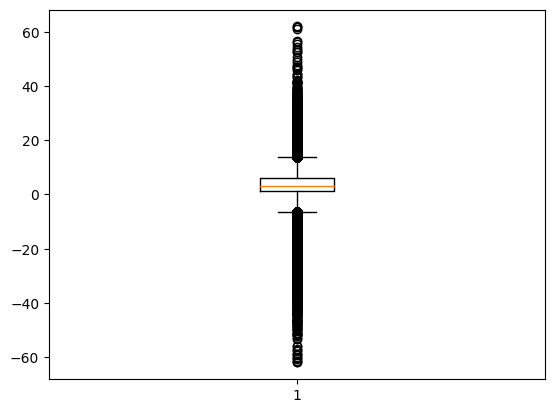




       hand_z_acceleration (ms-2) scale: ±6g
count                           2.764560e+06
mean                            3.363231e+00
std                             3.824965e+00
min                            -6.193470e+01
25%                             1.175920e+00
50%                             3.137860e+00
75%                             6.261150e+00
max                             6.194460e+01
feature:  hand_x_gyroscope data (rad/s)


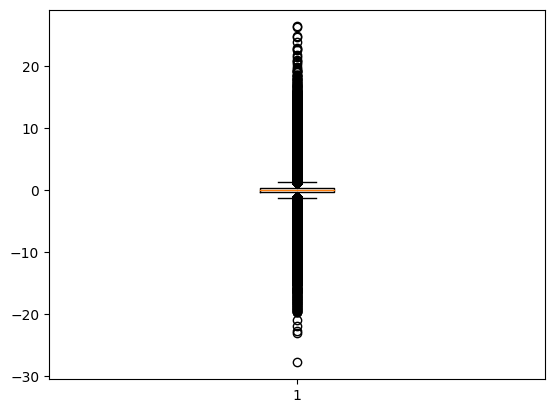




       hand_x_gyroscope data (rad/s)
count                   2.764560e+06
mean                   -4.471352e-03
std                     1.294144e+00
min                    -2.780440e+01
25%                    -3.436172e-01
50%                    -6.103725e-03
75%                     2.980563e-01
max                     2.641580e+01
feature:  hand_y_gyroscope data (rad/s)


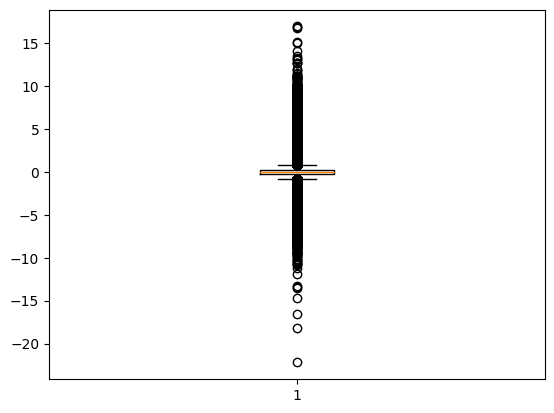




       hand_y_gyroscope data (rad/s)
count                   2.764560e+06
mean                    3.142994e-02
std                     8.798647e-01
min                    -2.221270e+01
25%                    -1.940760e-01
50%                     6.052800e-03
75%                     2.325540e-01
max                     1.698350e+01
feature:  hand_z_gyroscope data (rad/s)


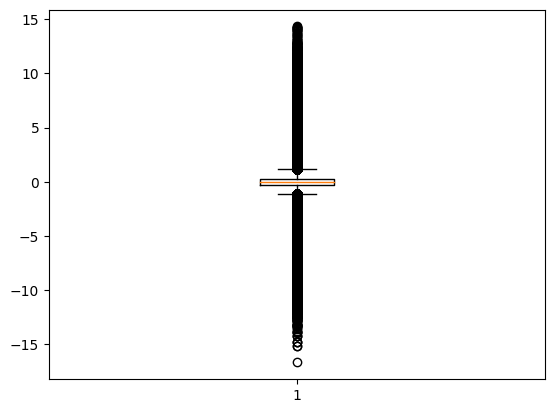




       hand_z_gyroscope data (rad/s)
count                   2.764560e+06
mean                   -7.015729e-03
std                     1.446692e+00
min                    -1.669970e+01
25%                    -2.971140e-01
50%                    -5.392590e-03
75%                     2.874130e-01
max                     1.433840e+01
feature:  hand_x_magnetometer data (μT)


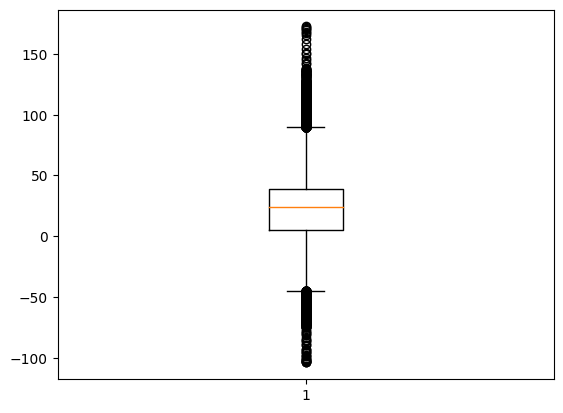




       hand_x_magnetometer data (μT)
count                   2.764560e+06
mean                    2.118536e+01
std                     2.402123e+01
min                    -1.039410e+02
25%                     5.296283e+00
50%                     2.413310e+01
75%                     3.916110e+01
max                     1.725900e+02
feature:  hand_y_magnetometer data (μT)


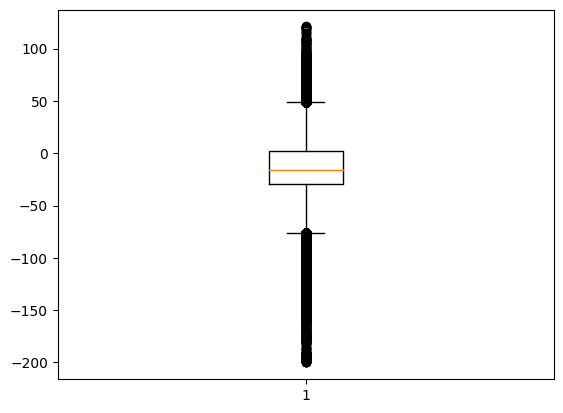




       hand_y_magnetometer data (μT)
count                   2.764560e+06
mean                   -1.434682e+01
std                     2.411807e+01
min                    -2.000430e+02
25%                    -2.949840e+01
50%                    -1.647820e+01
75%                     1.736782e+00
max                     1.211760e+02
feature:  hand_z_magnetometer data (μT)


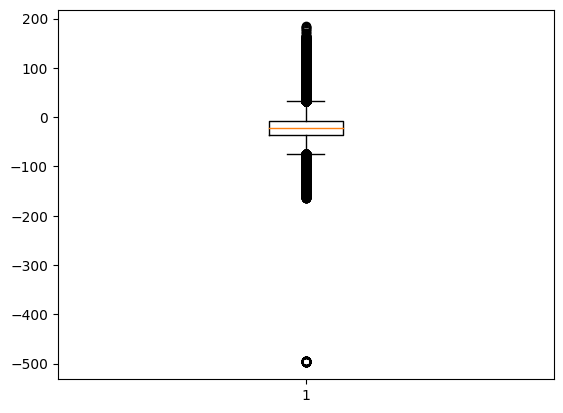




       hand_z_magnetometer data (μT)
count                   2.764560e+06
mean                   -2.164671e+01
std                     2.067739e+01
min                    -4.976320e+02
25%                    -3.532892e+01
50%                    -2.149290e+01
75%                    -8.435627e+00
max                     1.839110e+02
feature:  chest_temperature (°C)


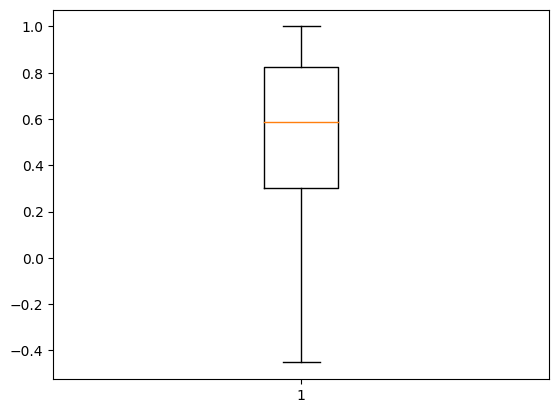




       chest_temperature (°C)
count            2.764560e+06
mean             5.669270e-01
std              3.050382e-01
min             -4.522460e-01
25%              3.016990e-01
50%              5.875755e-01
75%              8.235132e-01
max              1.000000e+00
feature:  chest_x_acceleration (ms-2) scale: ±16g


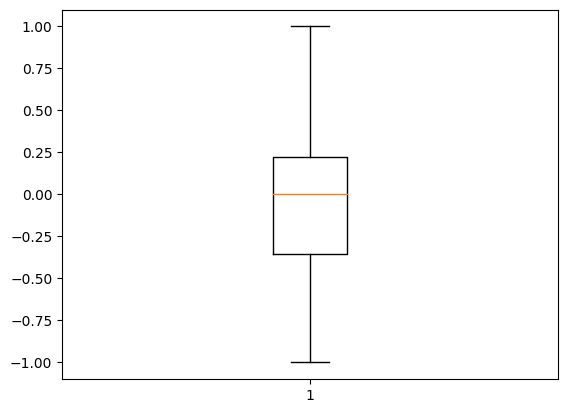




       chest_x_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -5.467422e-02
std                               3.773901e-01
min                              -9.999960e-01
25%                              -3.526110e-01
50%                               0.000000e+00
75%                               2.218200e-01
max                               9.999430e-01
feature:  chest_y_acceleration (ms-2) scale: ±16g


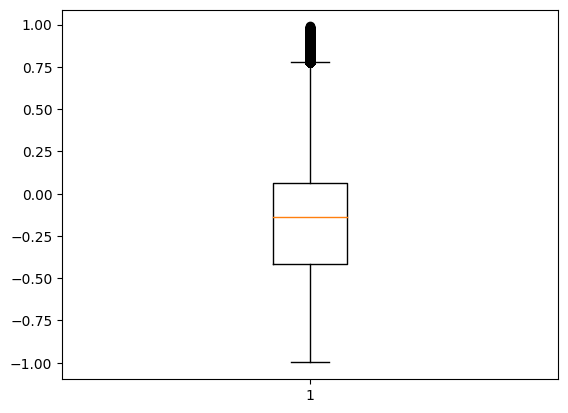




       chest_y_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -1.398759e-01
std                               3.341640e-01
min                              -9.982610e-01
25%                              -4.140570e-01
50%                              -1.380550e-01
75%                               6.301770e-02
max                               9.888270e-01
feature:  chest_z_acceleration (ms-2) scale: ±16g


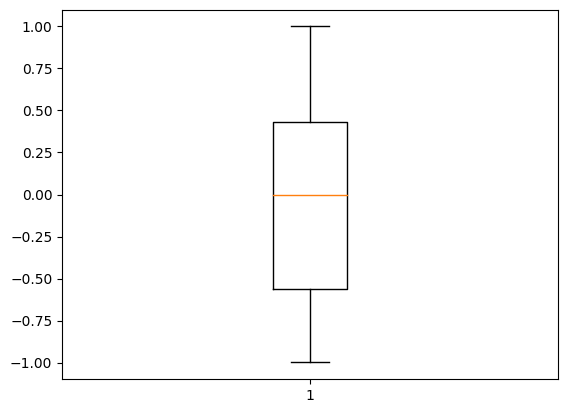




       chest_z_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -3.399915e-02
std                               5.547489e-01
min                              -9.993260e-01
25%                              -5.628243e-01
50%                               0.000000e+00
75%                               4.308460e-01
max                               9.996770e-01
feature:  chest_x_acceleration (ms-2) scale: ±6g


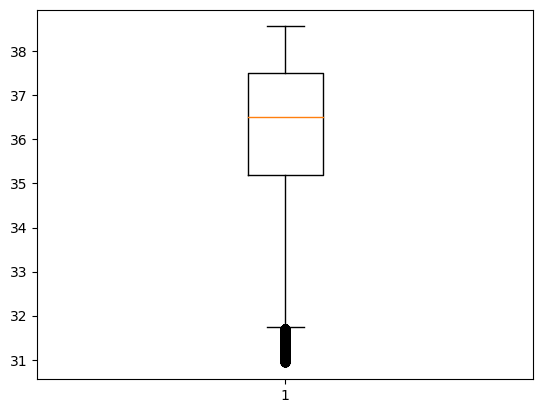




       chest_x_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             3.616458e+01
std                              1.572483e+00
min                              3.093750e+01
25%                              3.518750e+01
50%                              3.650000e+01
75%                              3.750000e+01
max                              3.856250e+01
feature:  chest_y_acceleration (ms-2) scale: ±6g


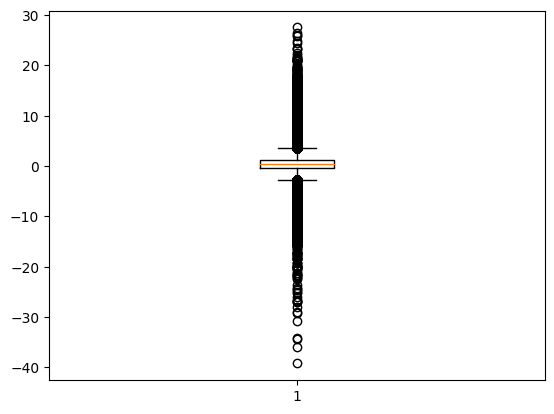




       chest_y_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             3.785917e-01
std                              1.612729e+00
min                             -3.920340e+01
25%                             -4.145040e-01
50%                              4.514290e-01
75%                              1.155060e+00
max                              2.752230e+01
feature:  chest_z_acceleration (ms-2) scale: ±6g


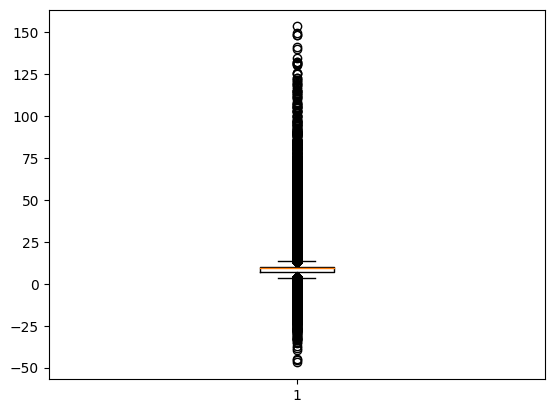




       chest_z_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             8.507493e+00
std                              4.186070e+00
min                             -4.692460e+01
25%                              7.324400e+00
50%                              9.391615e+00
75%                              9.799230e+00
max                              1.535820e+02
feature:  chest_x_gyroscope data (rad/s)


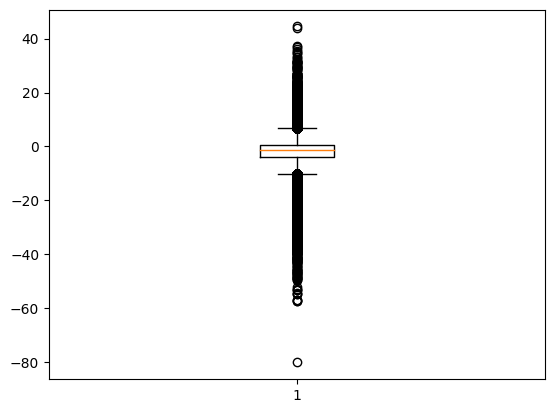




       chest_x_gyroscope data (rad/s)
count                    2.764560e+06
mean                    -1.513107e+00
std                      4.177856e+00
min                     -8.016680e+01
25%                     -3.879833e+00
50%                     -1.287040e+00
75%                      3.963720e-01
max                      4.449890e+01
feature:  chest_y_gyroscope data (rad/s)


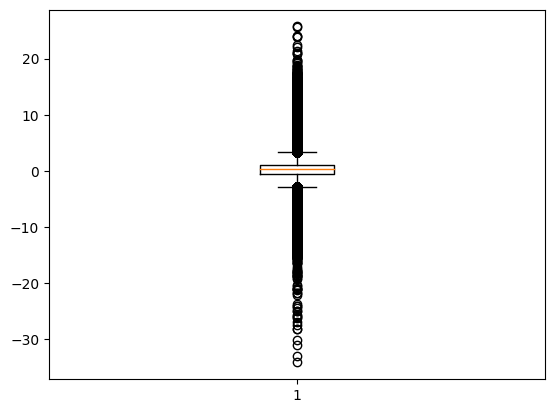




       chest_y_gyroscope data (rad/s)
count                    2.764560e+06
mean                     2.470914e-01
std                      1.611522e+00
min                     -3.420400e+01
25%                     -5.301665e-01
50%                      3.219225e-01
75%                      1.007190e+00
max                      2.573610e+01
feature:  chest_z_gyroscope data (rad/s)


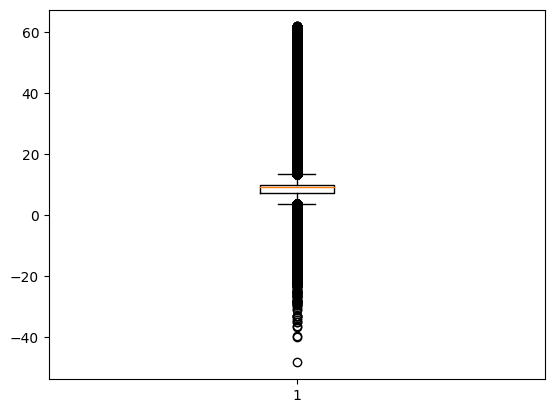




       chest_z_gyroscope data (rad/s)
count                    2.764560e+06
mean                     8.500801e+00
std                      4.154649e+00
min                     -4.825720e+01
25%                      7.309468e+00
50%                      9.355440e+00
75%                      9.811270e+00
max                      6.193730e+01
feature:  chest_x_magnetometer data (μT)


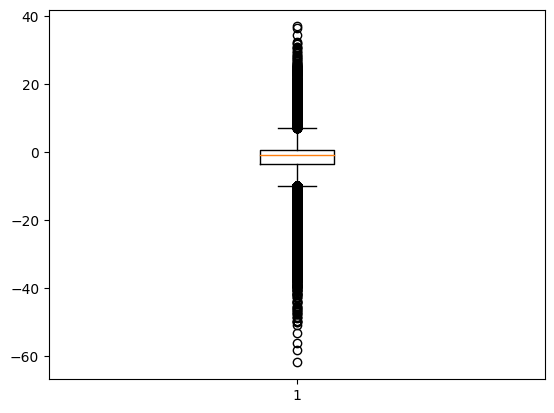




       chest_x_magnetometer data (μT)
count                    2.764560e+06
mean                    -1.177618e+00
std                      4.191271e+00
min                     -6.180410e+01
25%                     -3.563073e+00
50%                     -9.218600e-01
75%                      7.613853e-01
max                      3.696760e+01
feature:  chest_y_magnetometer data (μT)


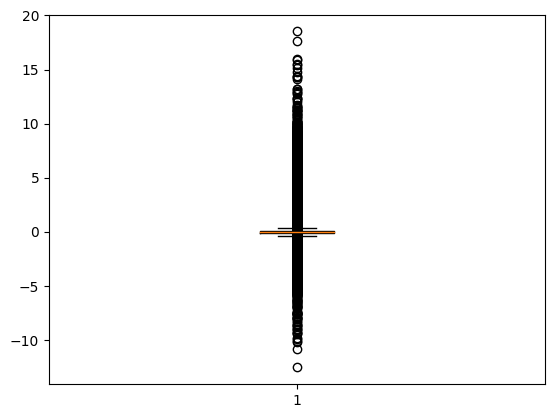




       chest_y_magnetometer data (μT)
count                    2.764560e+06
mean                     5.285176e-03
std                      3.972346e-01
min                     -1.252510e+01
25%                     -9.044355e-02
50%                      3.210540e-03
75%                      9.741375e-02
max                      1.851590e+01
feature:  chest_z_magnetometer data (μT)


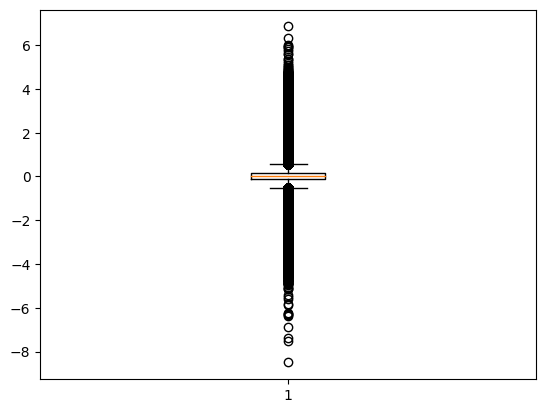




       chest_z_magnetometer data (μT)
count                    2.764560e+06
mean                     8.399839e-03
std                      5.356529e-01
min                     -8.499900e+00
25%                     -1.251002e-01
50%                     -3.447810e-06
75%                      1.448570e-01
max                      6.852570e+00
feature:  ankle_temperature (°C)


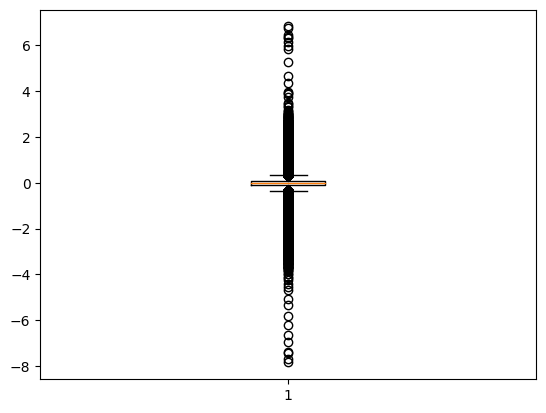




       ankle_temperature (°C)
count            2.764560e+06
mean            -2.120797e-02
std              2.897837e-01
min             -7.851890e+00
25%             -1.111320e-01
50%             -1.633315e-02
75%              6.983453e-02
max              6.824240e+00
feature:  ankle_x_acceleration (ms-2) scale: ±16g


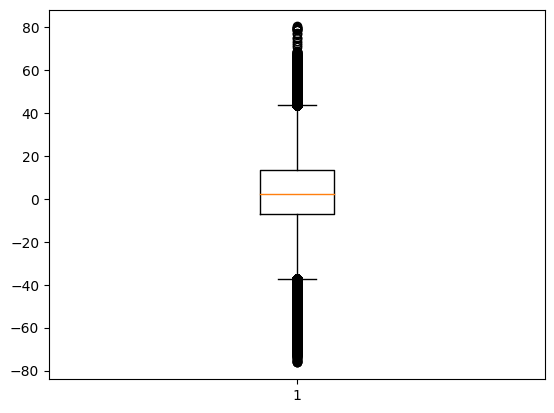




       ankle_x_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                              3.541198e+00
std                               1.649175e+01
min                              -7.624520e+01
25%                              -6.810713e+00
50%                               2.185500e+00
75%                               1.345370e+01
max                               8.047390e+01
feature:  ankle_y_acceleration (ms-2) scale: ±16g


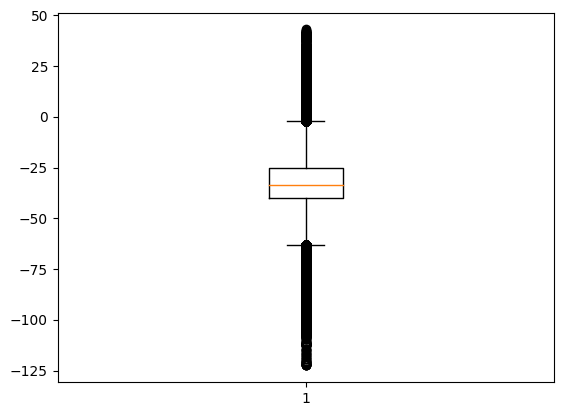




       ankle_y_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                             -3.180226e+01
std                               1.615753e+01
min                              -1.224800e+02
25%                              -4.019810e+01
50%                              -3.344160e+01
75%                              -2.494327e+01
max                               4.306130e+01
feature:  ankle_z_acceleration (ms-2) scale: ±16g


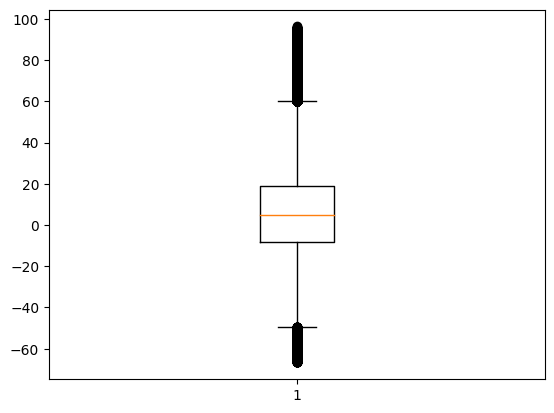




       ankle_z_acceleration (ms-2) scale: ±16g
count                             2.764560e+06
mean                              5.415051e+00
std                               1.995109e+01
min                              -6.668470e+01
25%                              -8.385130e+00
50%                               4.963445e+00
75%                               1.908963e+01
max                               9.635850e+01
feature:  ankle_x_acceleration (ms-2) scale: ±6g


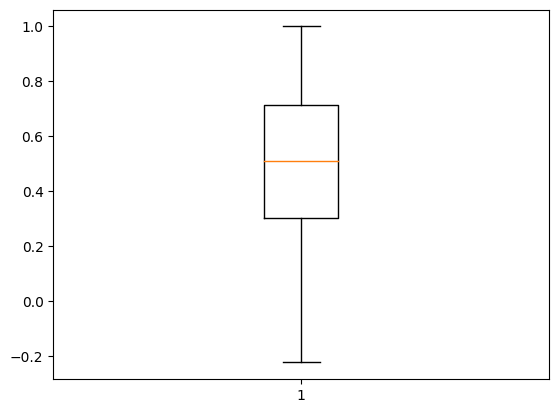




       ankle_x_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             5.320507e-01
std                              2.902368e-01
min                             -2.220890e-01
25%                              3.043260e-01
50%                              5.115265e-01
75%                              7.126200e-01
max                              1.000000e+00
feature:  ankle_y_acceleration (ms-2) scale: ±6g


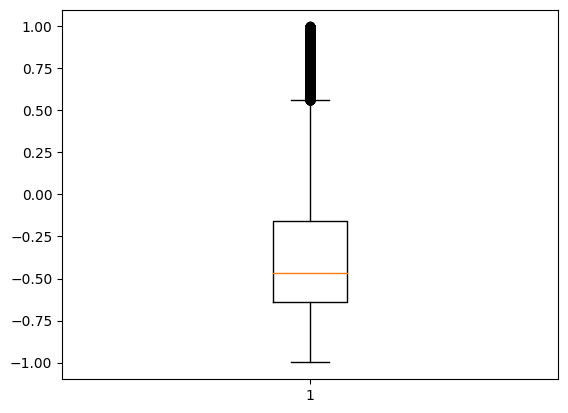




       ankle_y_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                            -4.057228e-01
std                              2.951858e-01
min                             -9.994670e-01
25%                             -6.396870e-01
50%                             -4.666680e-01
75%                             -1.587650e-01
max                              9.992700e-01
feature:  ankle_z_acceleration (ms-2) scale: ±6g


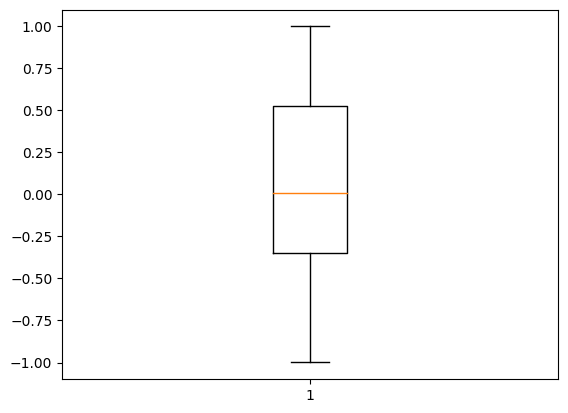




       ankle_z_acceleration (ms-2) scale: ±6g
count                            2.764560e+06
mean                             5.871046e-02
std                              4.762474e-01
min                             -9.996350e-01
25%                             -3.520100e-01
50%                              4.842595e-03
75%                              5.257010e-01
max                              9.968640e-01
feature:  ankle_x_gyroscope data (rad/s)


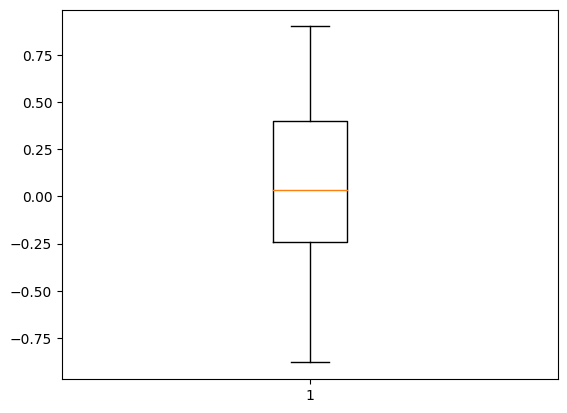




       ankle_x_gyroscope data (rad/s)
count                    2.764560e+06
mean                     5.086170e-02
std                      3.848296e-01
min                     -8.801950e-01
25%                     -2.431970e-01
50%                      3.239005e-02
75%                      3.977762e-01
max                      9.004420e-01
feature:  ankle_y_gyroscope data (rad/s)


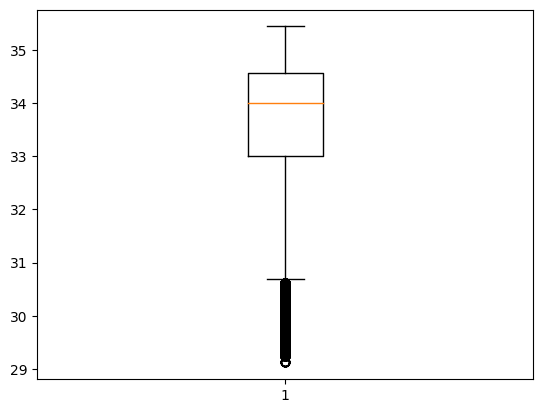




       ankle_y_gyroscope data (rad/s)
count                    2.764560e+06
mean                     3.369502e+01
std                      1.180957e+00
min                      2.912500e+01
25%                      3.300000e+01
50%                      3.400000e+01
75%                      3.456250e+01
max                      3.543750e+01
feature:  ankle_z_gyroscope data (rad/s)


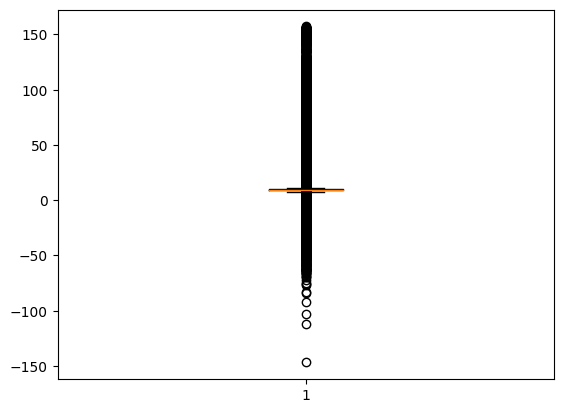




       ankle_z_gyroscope data (rad/s)
count                    2.764560e+06
mean                     9.524099e+00
std                      5.640938e+00
min                     -1.468510e+02
25%                      9.028950e+00
50%                      9.570120e+00
75%                      9.984310e+00
max                      1.572320e+02
feature:  ankle_x_magnetometer data (μT)


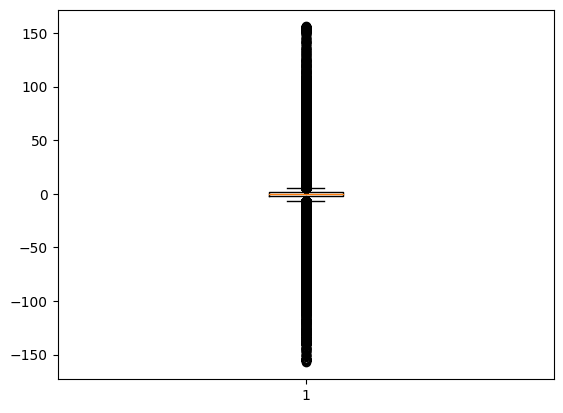




       ankle_x_magnetometer data (μT)
count                    2.764560e+06
mean                    -1.477653e-01
std                      6.763676e+00
min                     -1.574430e+02
25%                     -1.759150e+00
50%                     -2.826150e-01
75%                      1.236950e+00
max                      1.561900e+02
feature:  ankle_y_magnetometer data (μT)


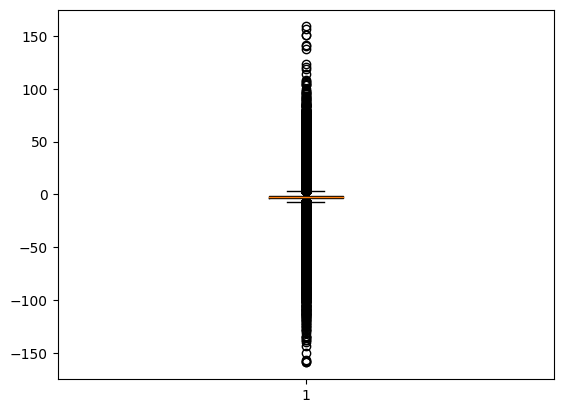




       ankle_y_magnetometer data (μT)
count                    2.764560e+06
mean                    -2.461350e+00
std                      3.500487e+00
min                     -1.589260e+02
25%                     -3.639520e+00
50%                     -2.360390e+00
75%                     -1.064180e+00
max                      1.588720e+02
feature:  ankle_z_magnetometer data (μT)


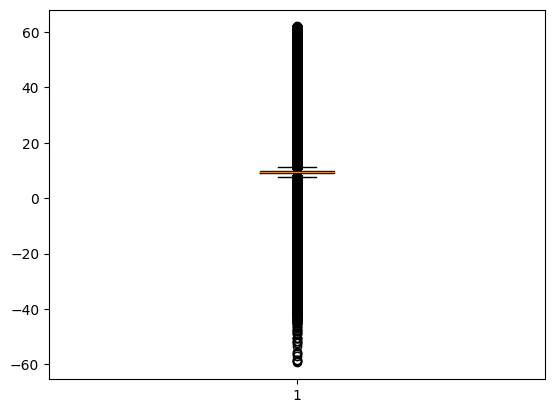




       ankle_z_magnetometer data (μT)
count                    2.764560e+06
mean                     9.501129e+00
std                      5.287274e+00
min                     -5.931200e+01
25%                      9.003530e+00
50%                      9.581700e+00
75%                      9.972360e+00
max                      6.198610e+01
feature:  heart_rate


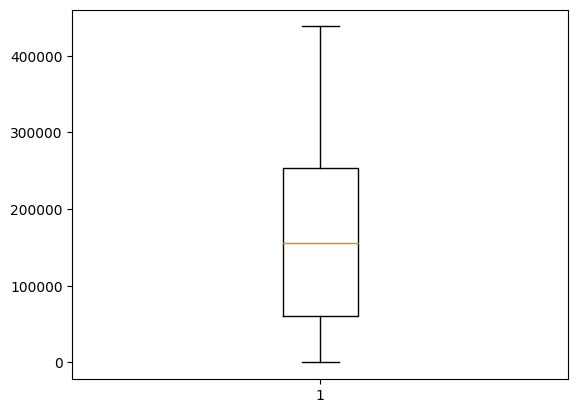




         heart_rate
count  2.764560e+06
mean   1.620095e+05
std    1.149161e+05
min    0.000000e+00
25%    6.039300e+04
50%    1.559110e+05
75%    2.536830e+05
max    4.381649e+05
   Getting train-test datasets   
Fit-transform normalise
Column renaming: activity_id --> label
Fit-transform
Train-test split
Normalise train
Normalise test
Train schema: 
root
 |-- activity_id: integer (nullable = true)
 |-- hand_temperature (°C): double (nullable = true)
 |-- hand_x_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_y_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_z_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_x_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_y_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_z_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_x_gyroscope data (rad/s): double (nullable = true)
 |-- hand_y_gyroscope data (rad/s): double (nullable = true)
 |

In [ ]:
train, test = fill_values(dfs, 'heart_rate', 'li', True)

##### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

##### Testing

In [ ]:
testing(test,train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_cc46c4a4e4e2
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_287deeeb158f
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|

## Axis feature aggregation and feature selection

### Non-normalised

   Feature aggregation and selection   
Dropping NaNs
Union of DataFrames
Axis aggregation of DataFrames
Concatenation and merge of DataFrames
feature:  heart_rate


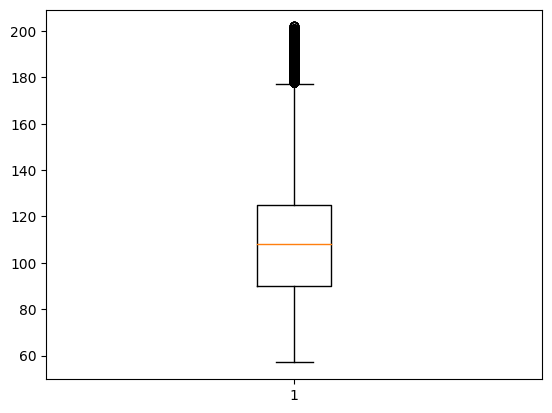




          heart_rate
count  259803.000000
mean      109.754768
std        25.849100
min        57.000000
25%        90.000000
50%       108.000000
75%       125.000000
max       202.000000
feature:  chest_temperature (°C)


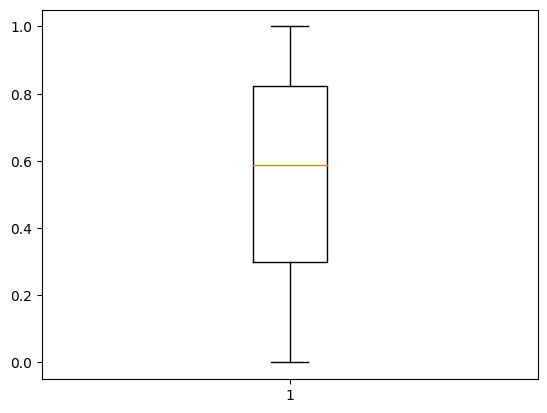




       chest_temperature (°C)
count           259803.000000
mean                 0.566697
std                  0.305419
min                  0.000006
25%                  0.300192
50%                  0.587232
75%                  0.823797
max                  1.000000
feature:  ankle_temperature (°C)


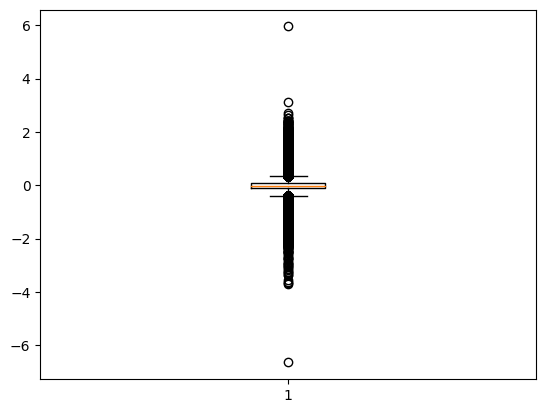




       ankle_temperature (°C)
count           259803.000000
mean                -0.021312
std                  0.291768
min                 -6.640760
25%                 -0.112283
50%                 -0.016381
75%                  0.070927
max                  5.954330
feature:  hand_xyz_acceleration (ms-2) scale: ±16g


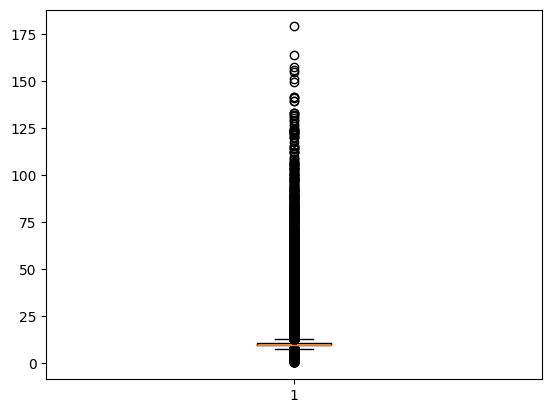




       hand_xyz_acceleration (ms-2) scale: ±16g
count                             259803.000000
mean                                  10.698284
std                                    4.888145
min                                    0.278204
25%                                    9.469274
50%                                    9.799365
75%                                   10.882292
max                                  178.922859
feature:  hand_xyz_acceleration (ms-2) scale: ±6g


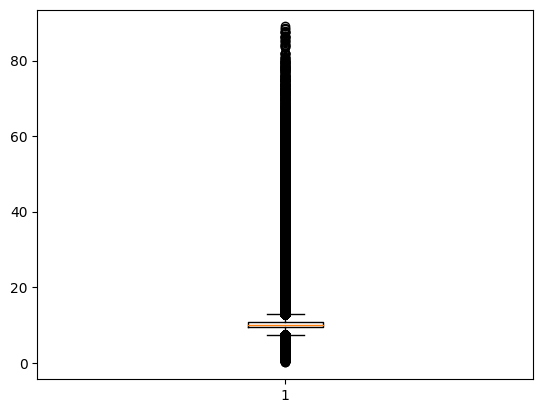




       hand_xyz_acceleration (ms-2) scale: ±6g
count                            259803.000000
mean                                 10.722203
std                                   4.534507
min                                   0.080063
25%                                   9.518046
50%                                   9.869343
75%                                  10.916988
max                                  89.012971
feature:  hand_xyz_gyroscope data (rad/s)


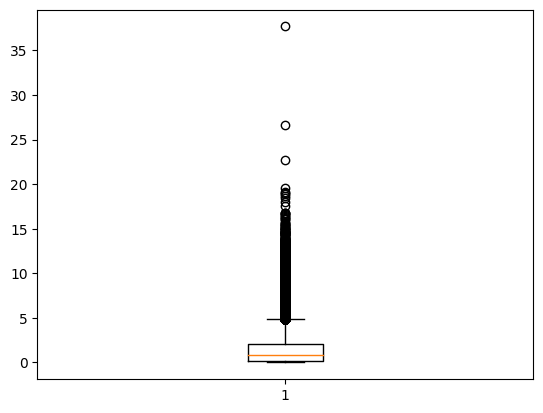




       hand_xyz_gyroscope data (rad/s)
count                    259803.000000
mean                          1.387454
std                           1.629137
min                           0.001186
25%                           0.145589
50%                           0.856285
75%                           2.036583
max                          37.679163
feature:  hand_xyz_magnetometer data (μT)


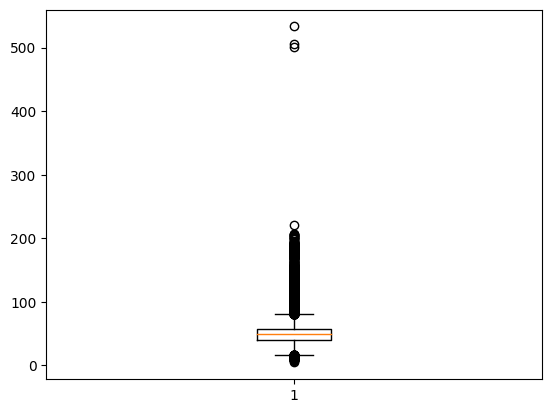




       hand_xyz_magnetometer data (μT)
count                    259803.000000
mean                         49.896792
std                          14.699415
min                           4.583435
25%                          40.403455
50%                          48.648996
75%                          56.853679
max                         533.160343
feature:  chest_xyz_acceleration (ms-2) scale: ±16g


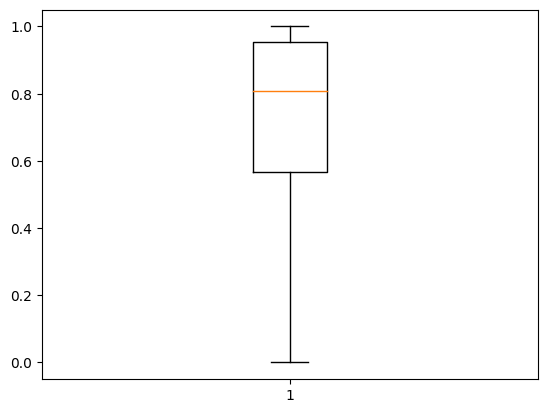




       chest_xyz_acceleration (ms-2) scale: ±16g
count                              259803.000000
mean                                    0.693785
std                                     0.322858
min                                     0.000000
25%                                     0.566885
50%                                     0.809419
75%                                     0.953879
max                                     1.000001
feature:  chest_xyz_acceleration (ms-2) scale: ±6g


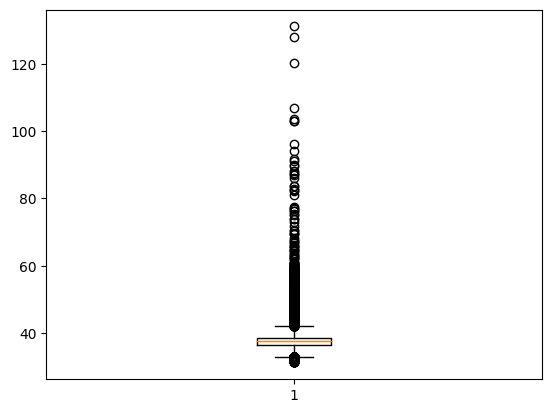




       chest_xyz_acceleration (ms-2) scale: ±6g
count                             259803.000000
mean                                  37.397308
std                                    2.065152
min                                   31.251219
25%                                   36.309301
50%                                   37.597682
75%                                   38.666053
max                                  131.096332
feature:  chest_xyz_gyroscope data (rad/s)


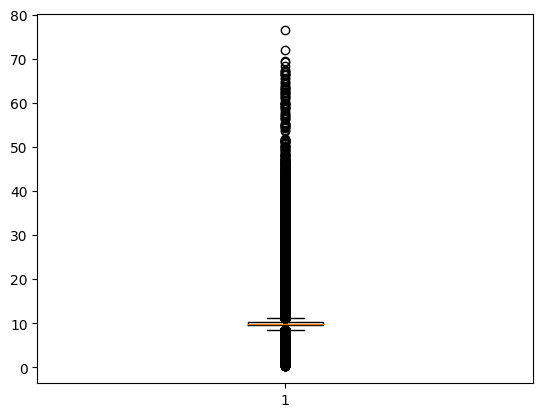




       chest_xyz_gyroscope data (rad/s)
count                     259803.000000
mean                          10.099595
std                            3.240765
min                            0.210149
25%                            9.530252
50%                            9.839599
75%                           10.234805
max                           76.439401
feature:  chest_xyz_magnetometer data (μT)


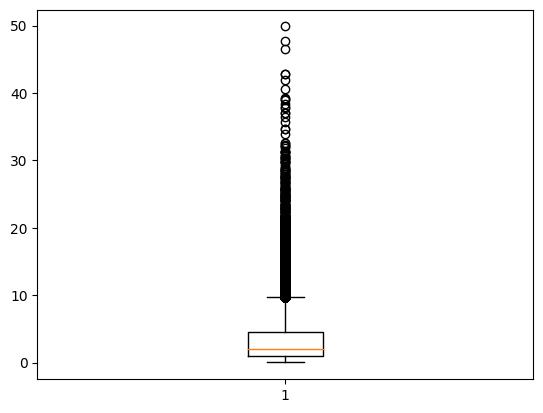




       chest_xyz_magnetometer data (μT)
count                     259803.000000
mean                           3.217936
std                            3.021003
min                            0.007052
25%                            0.991765
50%                            2.008039
75%                            4.486587
max                           49.858776
feature:  ankle_xyz_acceleration (ms-2) scale: ±16g


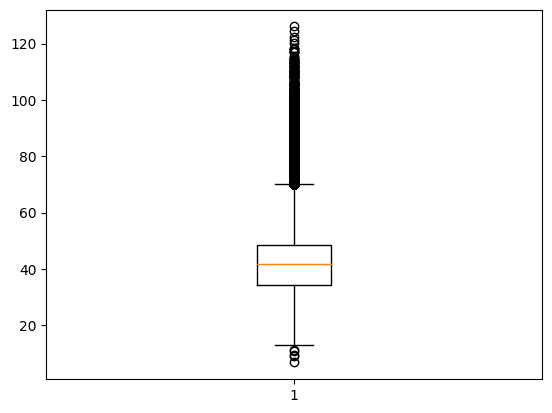




       ankle_xyz_acceleration (ms-2) scale: ±16g
count                              259803.000000
mean                                   42.784595
std                                    12.431922
min                                     6.771665
25%                                    34.206943
50%                                    41.772978
75%                                    48.520981
max                                   126.075428
feature:  ankle_xyz_acceleration (ms-2) scale: ±6g


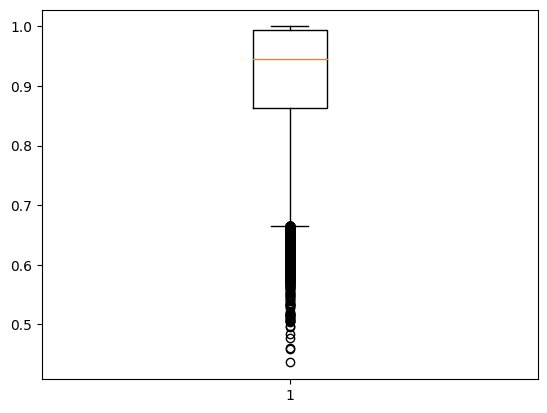




       ankle_xyz_acceleration (ms-2) scale: ±6g
count                             259803.000000
mean                                   0.917645
std                                    0.087371
min                                    0.435841
25%                                    0.862440
50%                                    0.944929
75%                                    0.994120
max                                    1.000001
feature:  ankle_xyz_gyroscope data (rad/s)


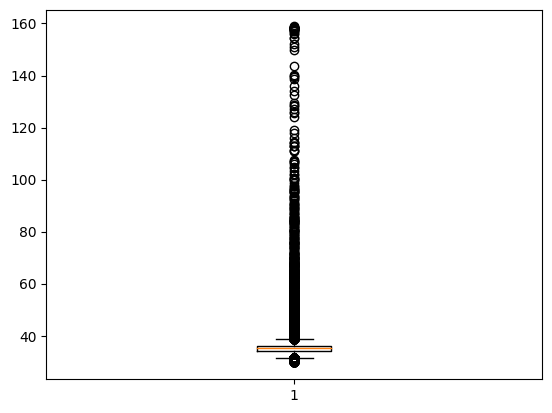




       ankle_xyz_gyroscope data (rad/s)
count                     259803.000000
mean                          35.392171
std                            2.857142
min                           29.713653
25%                           34.280525
50%                           35.321394
75%                           36.128597
max                          158.847927
feature:  ankle_xyz_magnetometer data (μT)


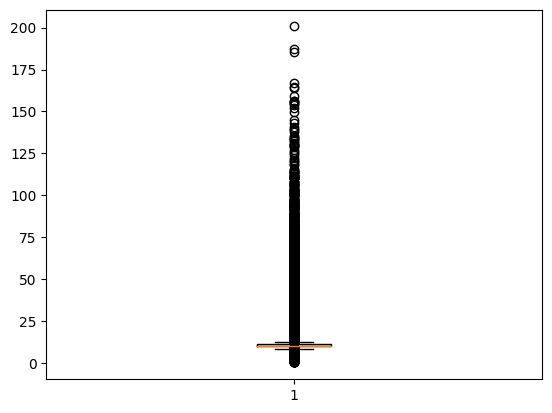




       ankle_xyz_magnetometer data (μT)
count                     259803.000000
mean                          11.889757
std                            6.571051
min                            0.180050
25%                            9.869415
50%                            9.998909
75%                           10.937925
max                          200.704232
Feature selection: features with a variance greater than threshold
Train-test creation
Assembly
Train-test splitting
Assembly-normalise train
Assembly-normalise test
Train schema: 
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)

Test schema: 
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
train, test = axisAggregation_featureSelection(dfs_nts, False)

#### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

In [ ]:
train_results

#### Testing

In [ ]:
testing(test,train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_941eb662f089
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_decee2ca9258
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|

### Normalised

   Feature aggregation and selection   
Dropping NaNs
Union of DataFrames
Axis aggregation of DataFrames
Concatenation and merge of DataFrames
feature:  heart_rate


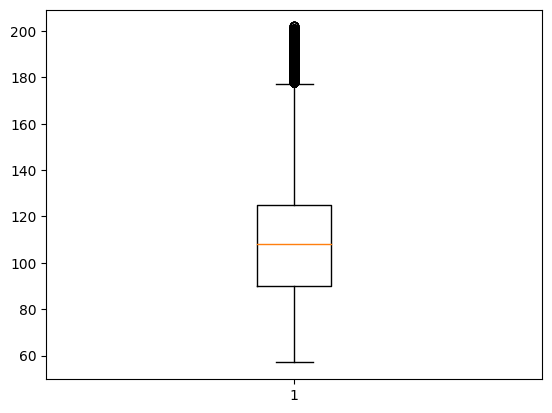




          heart_rate
count  259803.000000
mean      109.754768
std        25.849100
min        57.000000
25%        90.000000
50%       108.000000
75%       125.000000
max       202.000000
feature:  chest_temperature (°C)


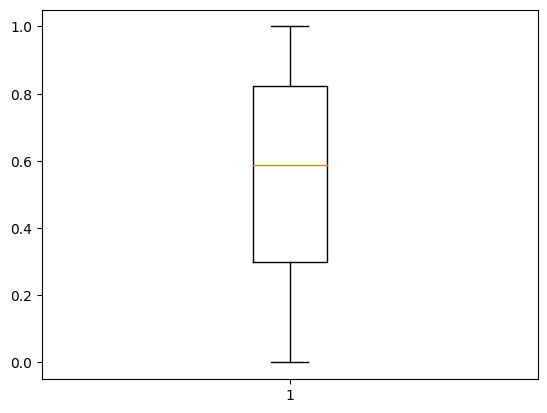




       chest_temperature (°C)
count           259803.000000
mean                 0.566697
std                  0.305419
min                  0.000006
25%                  0.300192
50%                  0.587232
75%                  0.823797
max                  1.000000
feature:  ankle_temperature (°C)


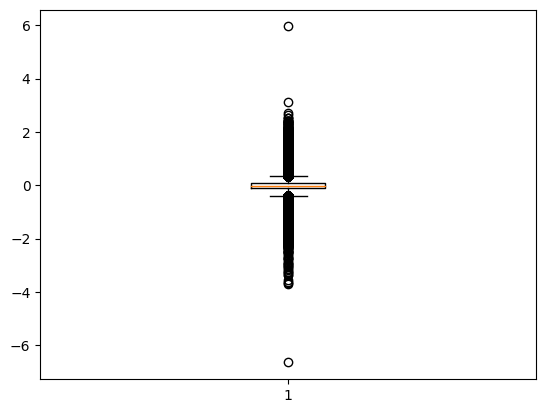




       ankle_temperature (°C)
count           259803.000000
mean                -0.021312
std                  0.291768
min                 -6.640760
25%                 -0.112283
50%                 -0.016381
75%                  0.070927
max                  5.954330
feature:  hand_xyz_acceleration (ms-2) scale: ±16g


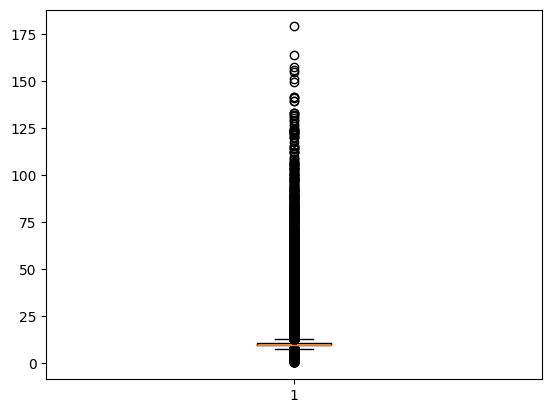




       hand_xyz_acceleration (ms-2) scale: ±16g
count                             259803.000000
mean                                  10.698284
std                                    4.888145
min                                    0.278204
25%                                    9.469274
50%                                    9.799365
75%                                   10.882292
max                                  178.922859
feature:  hand_xyz_acceleration (ms-2) scale: ±6g


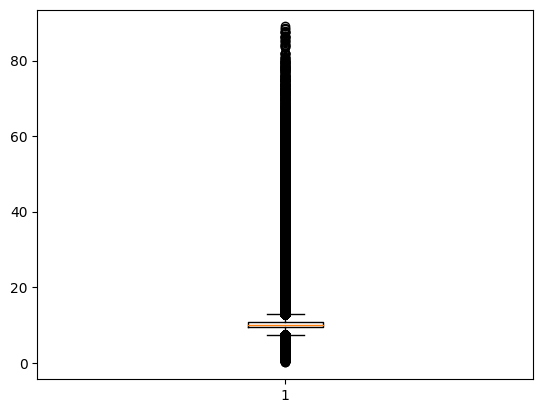




       hand_xyz_acceleration (ms-2) scale: ±6g
count                            259803.000000
mean                                 10.722203
std                                   4.534507
min                                   0.080063
25%                                   9.518046
50%                                   9.869343
75%                                  10.916988
max                                  89.012971
feature:  hand_xyz_gyroscope data (rad/s)


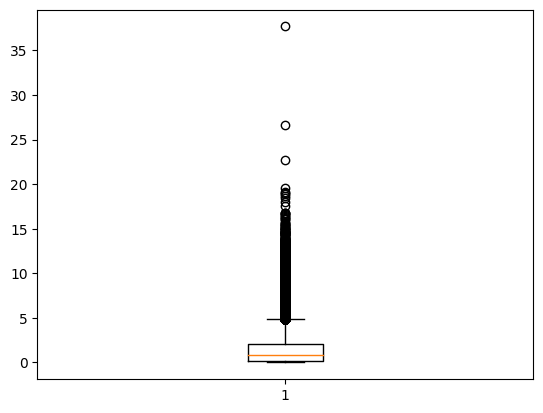




       hand_xyz_gyroscope data (rad/s)
count                    259803.000000
mean                          1.387454
std                           1.629137
min                           0.001186
25%                           0.145589
50%                           0.856285
75%                           2.036583
max                          37.679163
feature:  hand_xyz_magnetometer data (μT)


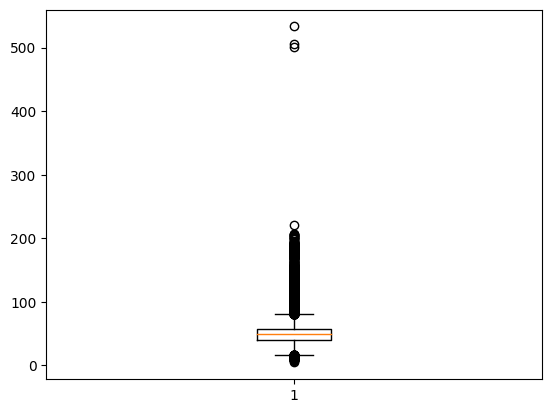




       hand_xyz_magnetometer data (μT)
count                    259803.000000
mean                         49.896792
std                          14.699415
min                           4.583435
25%                          40.403455
50%                          48.648996
75%                          56.853679
max                         533.160343
feature:  chest_xyz_acceleration (ms-2) scale: ±16g


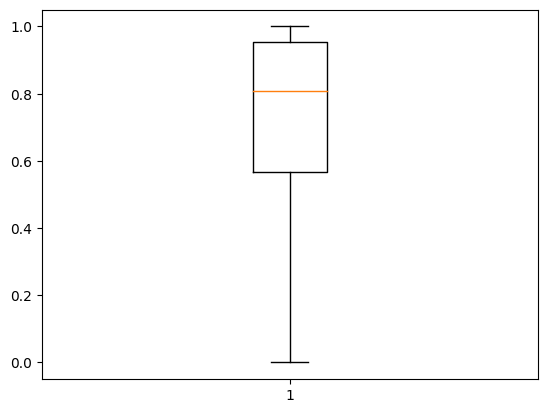




       chest_xyz_acceleration (ms-2) scale: ±16g
count                              259803.000000
mean                                    0.693785
std                                     0.322858
min                                     0.000000
25%                                     0.566885
50%                                     0.809419
75%                                     0.953879
max                                     1.000001
feature:  chest_xyz_acceleration (ms-2) scale: ±6g


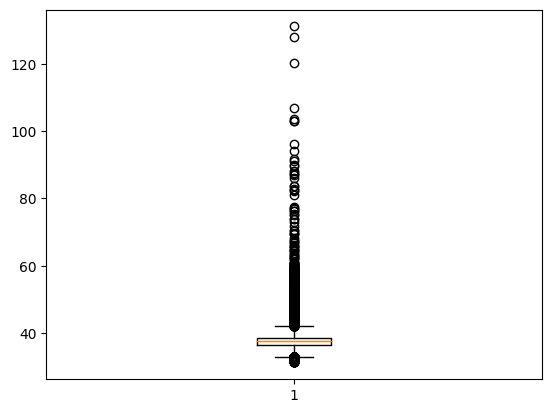




       chest_xyz_acceleration (ms-2) scale: ±6g
count                             259803.000000
mean                                  37.397308
std                                    2.065152
min                                   31.251219
25%                                   36.309301
50%                                   37.597682
75%                                   38.666053
max                                  131.096332
feature:  chest_xyz_gyroscope data (rad/s)


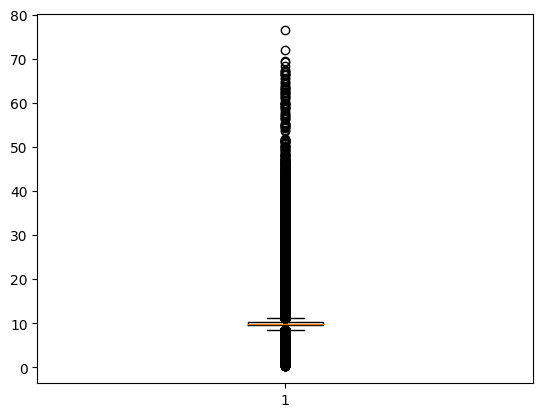




       chest_xyz_gyroscope data (rad/s)
count                     259803.000000
mean                          10.099595
std                            3.240765
min                            0.210149
25%                            9.530252
50%                            9.839599
75%                           10.234805
max                           76.439401
feature:  chest_xyz_magnetometer data (μT)


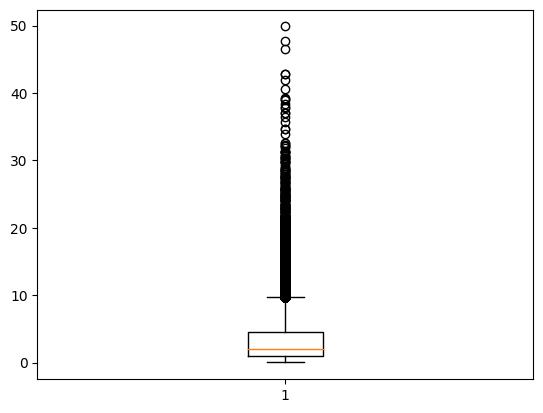




       chest_xyz_magnetometer data (μT)
count                     259803.000000
mean                           3.217936
std                            3.021003
min                            0.007052
25%                            0.991765
50%                            2.008039
75%                            4.486587
max                           49.858776
feature:  ankle_xyz_acceleration (ms-2) scale: ±16g


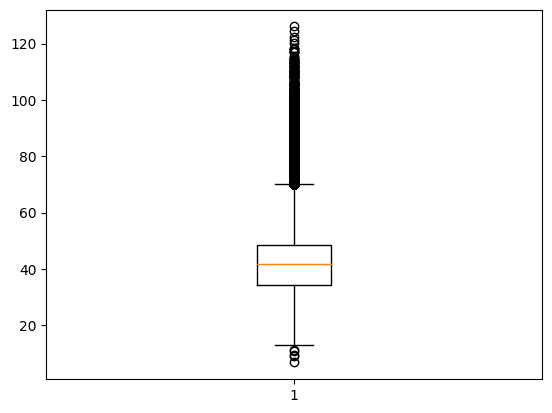




       ankle_xyz_acceleration (ms-2) scale: ±16g
count                              259803.000000
mean                                   42.784595
std                                    12.431922
min                                     6.771665
25%                                    34.206943
50%                                    41.772978
75%                                    48.520981
max                                   126.075428
feature:  ankle_xyz_acceleration (ms-2) scale: ±6g


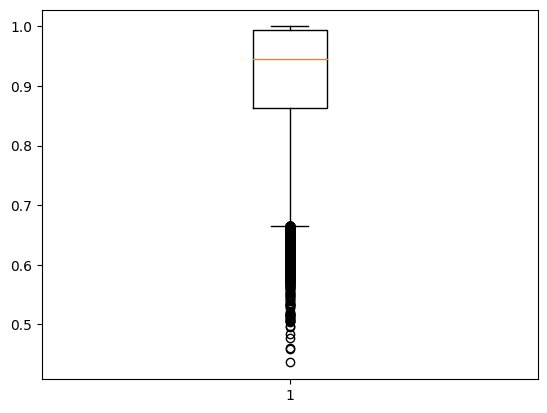




       ankle_xyz_acceleration (ms-2) scale: ±6g
count                             259803.000000
mean                                   0.917645
std                                    0.087371
min                                    0.435841
25%                                    0.862440
50%                                    0.944929
75%                                    0.994120
max                                    1.000001
feature:  ankle_xyz_gyroscope data (rad/s)


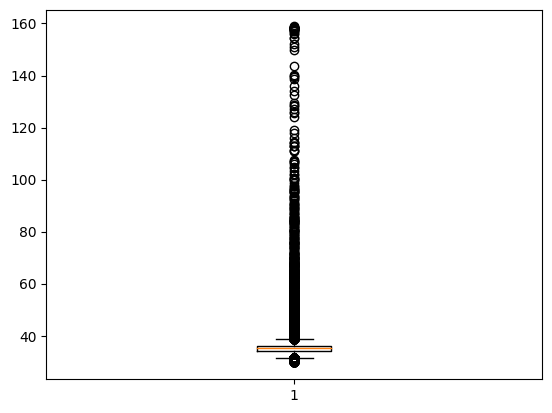




       ankle_xyz_gyroscope data (rad/s)
count                     259803.000000
mean                          35.392171
std                            2.857142
min                           29.713653
25%                           34.280525
50%                           35.321394
75%                           36.128597
max                          158.847927
feature:  ankle_xyz_magnetometer data (μT)


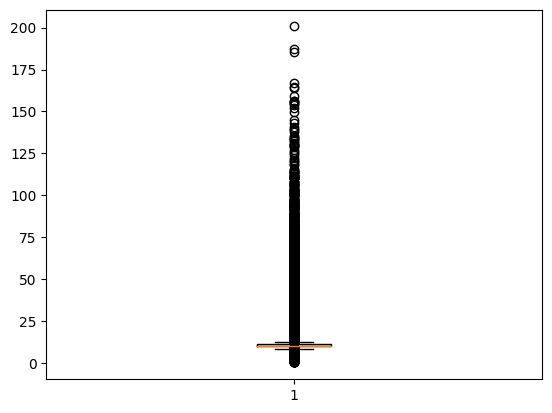




       ankle_xyz_magnetometer data (μT)
count                     259803.000000
mean                          11.889757
std                            6.571051
min                            0.180050
25%                            9.869415
50%                            9.998909
75%                           10.937925
max                          200.704232
Feature selection: features with a variance greater than threshold
Train-test creation
Assembly-normalise
Train-test splitting
Assembly-normalise train
Assembly-normalise test
Train schema: 
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)

Test schema: 
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
train, test = axisAggregation_featureSelection(dfs_nts, True)

#### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

#### Testing

In [ ]:
testing(test,train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_9bc6756aaaa0
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_17133a10fccd
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|

## Axis feature aggregation, feature selection and body parts aggregation

### Non-normalised

In [ ]:
train, test = axisAggregation_bodyPartsAccumulation_featureSelection(dfs_nts, False)

   Feature aggregation and selection   
Dropping NaNs
Union of DataFrames
Axis aggregation of DataFrames
Time features computation
Body parts weighted accumulation
Concatenation and merge of DataFrames
Feature selection: features with a variance greater than threshold
Train-test creation
Assembly
Train-test splitting
Assembly-normalise train
Assembly-normalise test
Train schema: 
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)

Test schema: 
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



#### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

#### Testing

In [ ]:
testing(test,train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_4b138858f4fc
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_28caf17ab2c4
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|

### Normalised

In [ ]:
train, test = axisAggregation_bodyPartsAccumulation_featureSelection(dfs_nts, True)

   Feature aggregation and selection   
Dropping NaNs
Union of DataFrames
Axis aggregation of DataFrames
Time features computation
Body parts weighted accumulation
Concatenation and merge of DataFrames
Feature selection: features with a variance greater than threshold
Train-test creation
Fit-transform normalise
Column renaming: activity_id --> label
Fit-transform
Train-test split
Normalise train
Normalise test
Train schema: 
root
 |-- activity_id: double (nullable = true)
 |-- heart_rate: double (nullable = true)
 |-- hand_xyz_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_xyz_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_xyz_gyroscope data (rad/s): double (nullable = true)
 |-- hand_xyz_magnetometer data (μT): double (nullable = true)
 |-- chest_xyz_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- chest_xyz_gyroscope data (rad/s): double (nullable = true)
 |-- chest_xyz_magnetometer data (μT): double (nullable = true)
 |-- ankle_x

#### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

#### Testing

In [ ]:
testing(test,train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_8e528431fe89
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_14f67c4bbe81
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|

## Dropping Heart-rate column and then dropping rows with NaNs

### Non-normalised

In [ ]:
train, test = dropping_hr_nans(dfs_nts, False)

   Dropping heart-rate column and then dropping rows with NaNs   
Union of DataFrames
Dropping heart_rate column
Before dropping rows with NaNs: 
number of rows:  2872533
After dropping rows with NaNs: 
number of rows:  2844868
Fit-transform
Train-test split
Train schema: 
root
 |-- activity_id: integer (nullable = true)
 |-- hand_temperature (°C): double (nullable = true)
 |-- hand_x_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_y_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_z_acceleration (ms-2) scale: ±16g: double (nullable = true)
 |-- hand_x_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_y_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_z_acceleration (ms-2) scale: ±6g: double (nullable = true)
 |-- hand_x_gyroscope data (rad/s): double (nullable = true)
 |-- hand_y_gyroscope data (rad/s): double (nullable = true)
 |-- hand_z_gyroscope data (rad/s): double (nullable = true)
 |-- hand_x_magnetometer

#### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

#### Testing

In [ ]:
testing(test,train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_67bf4ab2b30c
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_8be7c014f866
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|

### Normalised

In [ ]:
train, test = dropping_hr_nans(dfs_nts, True)

   Dropping heart-rate column and then dropping rows with NaNs   
Union of DataFrames
Dropping heart_rate column
Before dropping rows with NaNs: 
number of rows:  2872533
After dropping rows with NaNs: 
number of rows:  2844868
Assembly-normalise
Train-test splitting
Assembly-normalise train
Assembly-normalise test
Train schema: 
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)

Test schema: 
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



#### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

#### Testing

In [ ]:
testing(test,train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_aa551f223927
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_94aa5377d575
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|

## Time domain and frequency domain features extraction

### Non-normalised

In [ ]:
train, test = time_frequency_features_extraction(dfs_nts, subjects, False, fromFile = False)

   Time domain and frequency domain features extraction   
Train test splitting
Training-set label extraction
Training-set label --> number of samples for each subject
Training-set label --> total number of samples
Training-set number of labels computation
Training-set majority label computation
Reduction of training set
Reduction of test set
Training-set feature extraction
Before dropping rows with NaNs: 
number of rows of df_0 : 10965
number of rows of df_1 : 12449
number of rows of df_2 : 7494
number of rows of df_3 : 9835
number of rows of df_4 : 11065
number of rows of df_5 : 10710
number of rows of df_6 : 9452
number of rows of df_7 : 11734
number of rows of df_8 : 37
The number of rows of the dataset is equal to:  None
After dropping NaNs:
number of rows of df_0 : 2722
number of rows of df_1 : 3310
number of rows of df_2 : 1725
number of rows of df_3 : 1823
number of rows of df_4 : 1714
number of rows of df_5 : 1489
number of rows of df_6 : 2046
number of rows of df_7 : 3699
num

#### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

#### Testing

In [ ]:
test_results = testing(test, train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_612597033c00
+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_63f4a180bc81
+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|

### Normalised

In [ ]:
train, test = time_frequency_features_extraction(dfs_nts, subjects, True, fromFile = False)

   Time domain and frequency domain features extraction   
Train test splitting
Training-set label extraction
Training-set label --> number of samples for each subject
Training-set label --> total number of samples
Training-set number of labels computation
Training-set majority label computation
Reduction of training set
Reduction of test set
Training-set feature extraction
Before dropping rows with NaNs: 
number of rows of df_0 : 10965
number of rows of df_1 : 12449
number of rows of df_2 : 7494
number of rows of df_3 : 9835
number of rows of df_4 : 11065
number of rows of df_5 : 10710
number of rows of df_6 : 9452
number of rows of df_7 : 11734
number of rows of df_8 : 37
The number of rows of the dataset is equal to:  None
After dropping NaNs:
number of rows of df_0 : 2722
number of rows of df_1 : 3310
number of rows of df_2 : 1725
number of rows of df_3 : 1823
number of rows of df_4 : 1714
number of rows of df_5 : 1489
number of rows of df_6 : 2046
number of rows of df_7 : 3699
num

#### Training

In [ ]:
train_results = training(train, activity_id_name)

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous feat

#### Testing

In [ ]:
test_results = testing(test, train_results, activity_id_name)

   Testing   
Classifier:  DecisionTreeClassifier_6f66e37d8201
+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows

Classifier:  RandomForestClassifier_db44c7267e0a
+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|